<font size="20">

# LET measurements

<font size="3">
    
> __Author:__ Alexander Backis
<br/>__Institutes:__ University of Glasgow, European Spallation Source
<br/>__Dates:__ 2/10-2020 to 16/10-2020

_Abstract:_
This notebook contains the data-analysis tools used for the measurements at the LET instrument at ISIS. It describes how the analysis was performed, and summarizes the results.

# Contents
    
* [1. Introduction](#INTRODUCTION)
    * [1.1 Packages](#PACKAGES)
    * [1.2 Parameters](#PARAMETERS)
    * [1.3 Functions](#FUNCTIONS)
* [2. Data](#DATA)
    * [2.1 Paths](#PATHS)
    * [2.2 Extract](#EXTRACT)
    * [2.3 Load](#LOAD)
* [3. Filters](#FILTER)
* [4. Plotting](#PLOTTING)
    * [4.1. Multi-Grid detector](#PLOTMG)
    * [4.2. Helium-3 tubes](#PLOTHE3)
* [5. Distance calibration](#CALIBRATION)
* [6. Analysis](#ANALYSIS)
    * [6.1. Background](#BACKGROUND)
    * [6.2. Utgård comparison](#UTGARD)
* [7. Additional calculations](#ADDCALC)

# 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

Notebook showing the analysis of the LET measurements.

## 1.1 Packages<a class="anchor" id="PACKAGES"></a>

Import all necessary packages.

In [1]:
# Autoload packages when doing an external change
%load_ext autoreload
%autoreload 2

# Activate matplotlib in interactive notebook mode
%matplotlib notebook

# General packages
import os
import h5py
import datetime
import numpy as np
import pandas as pd
import plotly as py
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import plotly.graph_objects as go
import scipy.optimize as sci_opt
import scipy.signal as sci_sig
from plotly.offline import iplot, plot
from IPython.display import Image

# Warning management
plt.rcParams.update({'figure.max_open_warning': 0})

# Data handling
import mg.file_handling.read as mg_read
import he3_let.read as he3_read
import bm_let.read as bm_read
import he3.read as he3_mca4_read

# Plotting
import mg_let.basic_plot as mg_basic_plot

# Helper functions
import mg.helper_functions.misc as mg_hf

## 1.2 Parameters<a class="anchor" id="PARAMETERS"></a>

In [2]:
# Declare all global parameters
MG_RAW_FOLDER = '../data/let_measurements/mg/raw/'
MG_PROCESSED_FOLDER = '../data/let_measurements/mg/processed/'
HE3_FOLDER = '../data/let_measurements/he3/'

# Instrument definition
MODERATOR_TO_SAMPLE_IN_M = 25 # m

# Convertion factors
MG_TDC_TO_US = 62.5e-9 * 1e6
MG_H_TO_TDC = (1 / (62.5e-9)) * 60 * 60

## 1.3 Functions<a class="anchor" id="FUNCTIONS"></a>

Declare all functions used in the analysis.

## Multi-Grid detector

### Plotting

In [3]:
def mg_plot_basic(run, clusters_unfiltered, events, df_filter, bus_start, bus_stop, number_rows, area):
    """
    Function to plot all basic plots for SEQUOIA detector,
    such as PHS, Coincidences and rate.
    
    Ordering of plotting is:
    
    PHS 2D - NOT FILTERED
    MULTIPLICITY - FILTERED
    PHS 1D - FILTERED AND NOT FILTERED
    COINCIDENCES 2D - FILTERED
    PHS CORRELATION - FILTERED
    RATE - FILTERED
    TOF - FILTERED
    
    Note that all plots are filtered except the PHS 2D.
    
    Args:
        run (str): File run
        clusters_unfiltered (DataFrame): Unfiltered clusteres
        events (DataFrame): Individual events
        df_filter (dict): Dictionary specifying the filter which will be used on the clustered data
        bus_start (int): First bus to plot
        bus_stop (int): Last bus to plot
        number_rows (int): Number of rows in plots (number of rows must be larger than number_buses/3)
        area (float): Area in m^2 of the active detector surface

    Yields:
        Plots the basic analysis
    
    """
    
    mg_hf.set_thick_labels(12)
    
    # Filter clusters
    clusters = mg_read.filter_data(clusters_unfiltered, df_filter)
    
    # Declare parameters
    duration = (clusters_unfiltered.time.values[-1] - clusters_unfiltered.time.values[0]) * 62.5e-9
    #print(duration)
    duration = (clusters.time.values[-1] - clusters.time.values[0]) * 62.5e-9
    #print(duration)
    
    # PHS - 2D
    vmin = 1
    vmax = events.shape[0] // 1000 + 100
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        events_bus = events[events.bus == bus]
        if events_bus.shape[0] > 0:
            mg_basic_plot.phs_2d_plot(events_bus, bus, vmin, vmax)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_phs_2d.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # Multiplicity
    vmin = None
    vmax = None
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        if clusters_bus.shape[0] > 1:
            mg_basic_plot.multiplicity_plot_perc(clusters_bus, bus, duration)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_multiplicity_2d.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # PHS - 1D
    vmin = None
    vmax = None
    bins_phs_1d = 300
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        clusters_uf_bus = clusters_unfiltered[clusters_unfiltered.bus == bus]
        mg_basic_plot.phs_clusters_1d_plot(clusters_bus, clusters_uf_bus, bins_phs_1d, bus, duration)
        plt.yscale('log')
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_phs_1d.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # Coincidences - 2D
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    if clusters.shape[0] != 0:
        vmin = (1 * 1/duration)
        vmax = (clusters.shape[0] // 450 + 5) * 1/duration
    else:
        duration = 1
        vmin = 1
        vmax = 1
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        # Calculate number of events and rate in a specific bus
        number_events = clusters_bus.shape[0]
        #print(number_events)
        #print(area)
        #print(duration)
        number_events_error = np.sqrt(clusters_bus.shape[0])
        events_per_s = number_events/duration
        events_per_s_m2 = events_per_s/area
        events_per_s_m2_error = number_events_error/(duration*area)
        title = ('Bus %d\n(%d events, %.3f±%.3f events/s/m$^2$)' % (bus, number_events,
                                                                    events_per_s_m2, events_per_s_m2_error))
        if number_events > 1:
            mg_basic_plot.clusters_2d_plot(clusters_bus, title, vmin, vmax, duration)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_coincidences_2d.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # Coincidences - PHS
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    if clusters.shape[0] != 0:
        vmin = 1/duration
        vmax = (clusters.shape[0] // 450 + 1000) / duration
    else:
        duration = 1
        vmin = 1
        vmax = 1
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        if clusters_bus.shape[0] > 1:
            mg_basic_plot.clusters_phs_plot(clusters_bus, bus, duration, vmin, vmax)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_coincidences_phs.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # Rate 
    number_bins = 40
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        mg_basic_plot.rate_plot(clusters_bus, number_bins, bus, area)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_rate.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
    # TIME-OF-FLIGHT
    number_bins = 300
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(4*number_rows)
    for i, bus in enumerate(np.arange(bus_start, bus_stop+1, 1)):
        plt.subplot(number_rows, 3, i+1)
        clusters_bus = clusters[clusters.bus == bus]
        mg_basic_plot.tof_histogram(clusters_bus, number_bins, bus)
    plt.tight_layout()
    
    # Save data
    output_path = '../output/%s_tof.png' % run
    fig.savefig(output_path, bbox_inches='tight')

In [4]:
def mg_plot_basic_bus(run, bus, clusters_unfiltered, events, df_filter, area, plot_title=''):
    """
    Function to plot all basic plots for SEQUOIA detector, for a single bus,
    such as PHS, Coincidences and rate.
    
    Ordering of plotting is:
    
    PHS 2D - NOT FILTERED
    PHS 1D - FILTERED AND NOT FILTERED
    MULTIPLICITY - FILTERED
    PHS CORRELATION - FILTERED
    COINCIDENCES 2D - FILTERED
    RATE - FILTERED
    UNIFORMITY (WIRES) - FILTERED
    UNIFORMITY (GRIDS) - FILTERED
    
    Note that all plots are filtered except the PHS 2D.
    
    Args:
        run (str): File run
        bus (int): Bus to plot
        clusters_unfiltered (DataFrame): Unfiltered clusteres
        events (DataFrame): Individual events
        df_filter (dict): Dictionary specifying the filter which will be used on the clustered data
        area (float): Area in m^2 of the active detector surface
        plot_title (str): Title of 

    Yields:
        Plots the basic analysis
    
    """
    
    mg_hf.set_thick_labels(18)
    
    # Filter clusters
    clusters = mg_read.filter_data(clusters_unfiltered, df_filter)
    
    # Declare parameters
    duration_unf = (clusters_unfiltered.time.values[-1] - clusters_unfiltered.time.values[0]) * 62.5e-9
    duration = (clusters.time.values[-1] - clusters.time.values[0]) * 62.5e-9

    # Filter data from only one bus
    events_bus = events[events.bus == bus]
    clusters_bus = clusters[clusters.bus == bus]
    clusters_uf_bus = clusters_unfiltered[clusters_unfiltered.bus == bus]
    
    fig = plt.figure()
    plt.suptitle(plot_title, fontsize=15, fontweight='bold', y=1.00005)
    # PHS - 2D
    plt.subplot(4, 2, 1)
    vmin = 1
    vmax = events.shape[0] // 1000 + 100
    if events_bus.shape[0] > 0:
        mg_basic_plot.phs_2d_plot(events_bus, bus, vmin, vmax)
    plt.title('PHS vs Channel')
    

        
    # PHS - 1D
    plt.subplot(4, 2, 2)
    bins_phs_1d = 300
    mg_basic_plot.phs_clusters_1d_plot(clusters_bus, clusters_uf_bus, bins_phs_1d, bus, duration)
    plt.yscale('log')
    plt.title('PHS')

    
    # Coincidences - 2D
    plt.subplot(4, 2, 5)
    if clusters.shape[0] != 0:
        vmin = (1 * 1/duration)
        vmax = (clusters.shape[0] // 450 + 5) * 1/duration
    else:
        duration = 1
        vmin = 1
        vmax = 1

    number_events = clusters_bus.shape[0]
    number_events_error = np.sqrt(clusters_bus.shape[0])
    events_per_s = number_events/duration
    events_per_s_m2 = events_per_s/area
    events_per_s_m2_error = number_events_error/(duration*area)
    title = ('Coincidences\n(%d events, %.3f±%.3f events/s/m$^2$)' % (number_events,
                                                                      events_per_s_m2, events_per_s_m2_error))
    if number_events > 1:
        mg_basic_plot.clusters_2d_plot(clusters_bus, title, vmin, vmax, duration)
        
    
    # Rate
    plt.subplot(4, 2, 6)
    number_bins = 40
    mg_basic_plot.rate_plot(clusters_bus, number_bins, bus, area)
    plt.title('Rate vs time')
    
    # Multiplicity
    plt.subplot(4, 2, 3)
    if clusters_bus.shape[0] > 1:
        mg_basic_plot.multiplicity_plot_perc(clusters_bus, bus, duration)
    plt.title('Event multiplicity')
    
    # Coincidences - PHS
    plt.subplot(4, 2, 4)
    if clusters.shape[0] != 0:
        vmin = 1/duration
        vmax = (clusters.shape[0] // 450 + 1000) / duration
    else:
        duration = 1
        vmin = 1
        vmax = 1
    if clusters_bus.shape[0] > 1:
        mg_basic_plot.clusters_phs_plot(clusters_bus, bus, duration, vmin, vmax)
    plt.title('Charge coincidences')
    
    # Uniformity - grids
    plt.subplot(4, 2, 8)
    mg_basic_plot.grid_histogram(clusters_bus, bus, duration)
    plt.title('Uniformity - grids')
    
    # Uniformity - wires
    plt.subplot(4, 2, 7)
    mg_basic_plot.wire_histogram(clusters_bus, bus, duration)
    plt.title('Uniformity - wires')
    
    # Save data
    fig.set_figwidth(13)
    fig.set_figheight(20)
    plt.tight_layout()
    output_path = '../output/%s_summary_bus_%d.png' % (run, bus)
    fig.savefig(output_path, bbox_inches='tight')

In [76]:
# Misc. plotting features for the Multi-Grid
def mg_compare_phs(run, buses, labels, df_unf, df_filter):
    mg_hf.set_thick_labels(12)
    # Filter clusters
    df_f = mg_read.filter_data(df_unf, df_filter)
    # Declare parameters
    duration = (df_f.time.values[-1] - df_f.time.values[0]) * 62.5e-9
    number_bins = 300
    # Plot data
    fig = plt.figure()
    plt.subplot(2, 2, 1)
    for i, (df, is_filtered) in enumerate(zip([df_unf, df_f], ['Unfiltered', 'Filtered'])):
        for j, (xadc, wire_or_grid) in enumerate(zip(['gadc', 'wadc'], ['Grids', 'Wires'])):
            plt.subplot(2, 2, 2*i + j + 1)
            plt.title('%s - %s' % (wire_or_grid, is_filtered))
            for j, (bus, label) in enumerate(zip(buses, labels)):
                df_bus = df[df.bus == bus]
                plt.hist(df_bus[xadc], bins=number_bins, histtype='step',
                         zorder=5,
                         range=[0, 8000],
                         label=label,
                         weights=(1/duration)*np.ones(len(df_bus[xadc])))
                plt.legend()
                plt.xlabel('Charge (ADC channels)')
                plt.ylabel('Counts/s')
                plt.grid(True, which='major', linestyle='--', zorder=0)
                plt.grid(True, which='minor', linestyle='--', zorder=0)
                plt.ylim(1e-5, 1)
                plt.yscale('log')
    # Save data
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.tight_layout()
    output_path = '../output/%s_phs_comparison.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    
def mg_hist_side(run, df_unf, df_filter):
    mg_hf.set_thick_labels(12)
    # Filter clusters
    df_f = mg_read.filter_data(df_unf, df_filter)
    # Declare parameters
    duration = (df_f.time.values[-1] - df_f.time.values[0]) * 62.5e-9
    # Plot data
    fig = plt.figure()
    fig.suptitle(run, y=1.02)
    background_indices = np.arange(1, 13, 1)
    signal_indices = np.arange(13, 20, 1)
    plt.subplot(1, 2, 1)
    hist, bin_edges = np.histogram(df_f.wch % 20 + 0.5,
                                   weights=np.ones(df_f.shape[0]) * (1/duration),
                                   range=[0.5, 20.5], bins=20)
    plt.xlabel('Layer')
    plt.ylabel('Rate (counts/s)')
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.bar(bin_edges[:-1]+0.5, hist, color='grey', edgecolor='green', zorder=10, width=0.5, label='?')
    plt.bar(bin_edges[background_indices]+0.5,
            hist[background_indices], color='grey', edgecolor='red', zorder=10, width=0.5, label='Background')
    plt.bar(bin_edges[signal_indices]+0.5,
            hist[signal_indices], color='grey', edgecolor='blue', zorder=10, width=0.5,
            label='Signal+Background')
    plt.legend(title='Region')
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    plt.title('All data')
    plt.subplot(1, 2, 2)
    average_back = sum(hist[background_indices])/len(background_indices)
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.xlabel('Layer')
    plt.ylabel('Rate (counts/s)')
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.bar(bin_edges[signal_indices]+0.5,
            hist[signal_indices]-average_back, color='grey', edgecolor='black', zorder=10, width=0.5,
            label='Background reduced signal')
    fig.set_figheight(4)
    fig.set_figwidth(10)
    plt.title('Background reduced data from back layers')
    plt.legend(title='Data')
    plt.tight_layout()
    # Save data
    output_path = '../output/%s_side_hist_normalized_comparison.png' % run
    fig.savefig(output_path, bbox_inches='tight')

### Normalization

### Distance calibration

In [ ]:
def distance_calibration(df, E_in_meV, number_bins=100):
    """
    Function to calibrate the distance to each voxel in the MG from the sample. Data is collected
    from a monochromatic neutron beam incident on a small vanadium sample. The script histograms
    data from each voxel, takes the tof corrsponding to the peak maximum, and calculates the 
    sample-detector distance based on this.
    
    Args:
        df (pd.DataFrame): DataFrame containing the Multi-Grid data
        E_in_meV (float): Incident energy of neutrons
        number_bins (int): Number of bins for histogram

    Returns:
        distances (np.array): A 3D-array containing the '(bus, wch, gch) -> distance'-mapping
    
    """
    
    # Define parameters
    buses = np.array([0, 1])
    whcs = np.arange(0, 80, 1)
    gchs = np.arange(80, 120, 1)
    # Calculate velocity of incident neutrons
    v_in_m_per_s = np.sqrt((E_in_meV/5.227)) * 1e3 # From Squires (p. 3)
    tof_moderator_to_sample_in_s = (MODERATOR_TO_SAMPLE_IN_M/v_in_m_per_s)
    # Declare 3-dimensional numpy array
    distances = np.zeros((len(buses), 80, 120), dtype='float')
    # Iterate through all voxels
    for bus in buses:
        for wch in whcs:
            for gch in gchs:
                # Get data from a single voxel
                voxel_data = df[(df.bus == bus) &
                                (df.wch == wch) &
                                (df.gch == gch)]
                # Histogram tof data
                hist, bin_edges = np.histogram(voxel_data['tof'], bins=number_bins)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                # Get tof corresponding to peak maximum
                idx_max_value = np.argmax(hist)
                tof_in_s = bin_centers[idx_max_value] * 1e-6
                # Get distance corresponding to tof
                tof_sample_to_detection_in_s = tof_in_s - tof_moderator_to_sample_in_s
                distance_in_m = v_in_m_per_s * tof_sample_to_detection_in_s
                # Save in distances 3D-matrix
                distances[bus, wch, gch] = distance_in_m
    return distances


### File handling

In [ ]:
def merge_files(dfs):
    """
    Function to merge DataFrames containing Multi-Grid data. When subsequent files are appended, the
    timestampe is updateded on each file such that the first file has the time=0 reference.
    
    Args:
        dfs (np.array): Array of DataFrames containing the Multi-Grid data

    Returns:
        df_full (pd.DataFrame): DataFrame containing appended Multi-Grid data
    
    """
    
    # Declare first element and get max time
    df_full = dfs[0]
    start = df_full.shape[0]
    max_time = df_full.tail(1)['time'].array[0]
    # Append all files while making sure that subsequent files get an increased timestamp
    for df in dfs[1:]:
        df_full = df_full.append(df, ignore_index=True)
        df_full['time'].loc[start:] = df_full['time'].loc[start:] + max_time
        max_time = df_full.tail(1)['time'].array[0]
        start = df_full.shape[0]
    return df_full

## Helium-3 tubes

### Plotting

In [ ]:
def he3_plot_coordinates(pixels, region=None):
    """
    Function to plot the positions of all the pixels in the LET helium-3 array, as well as
    highlighting a region of interest.
    
    Args:
        pixels (np.array): Pixel coordinates in Helium-3 array
        region (np.array): Pixel ID's corresponding to a small region in the Helium-3 array
                           which is to be highlighted.

    Yields:
        A 3D plot showing all the pixels in the helium-3 array (blue), as well highlightning
        the position of the pixel id's provided in 'region' (green), and showing the sample
        position (red).
    
    """
    
    # Define labels
    labels = []
    for i in np.arange(0, len(pixels['x']), 1):
        labels.append('ID: %d<br>θ: %.2f°<br>φ: %.2f°' % (i, pixels['theta'][i], pixels['phi'][i]))
    trace_1 = go.Scatter3d(
        x=pixels['x'],
        y=pixels['y'],
        z=pixels['z'],
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                color='rgba(0, 0, 255, 1)',
                width=1.0
            ),
            opacity=1.0
        ),
        name='Helium-3 tubes',
        text=labels
    )
    
    trace_2 = go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                color='rgba(255, 0, 0, 1)',
                width=5.0
            ),
            opacity=1.0
        ),
        name='Sample'
    )
    
    if region is not None:
        # Define labels
        labels = []
        for i in region:
            labels.append('ID: %d<br>θ: %.2f°<br>φ: %.2f°' % (i, pixels['theta'][i], pixels['phi'][i]))
        trace_3 = go.Scatter3d(
                            x=pixels['x'][region],
                            y=pixels['y'][region],
                            z=pixels['z'][region],
                            mode='markers',
                            marker=dict(
                                    size=4,
                                    line=dict(
                                            color='rgba(0, 255, 0, 1)',
                                            width=1.0
                                            ),
                                    opacity=1.0
                            ),
                            name='Multi-Grid sized region',
                            text=labels
                            )

        
    
    camera = dict(
        up=dict(x=0, y=1, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1.5, y=1.5, z=-1.5)
    )

    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene=dict(
                camera=camera,
                xaxis = dict(
                        title='x (m)'),
                yaxis = dict(
                        title='y (m)'),
                zaxis = dict(
                        title='z (m)'),)
    )
    py.offline.init_notebook_mode()
    if region is None:
        data = [trace_1, trace_2]
    else:
        data = [trace_1, trace_2, trace_3]
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)
    
    
def he3_plot_3D_histogram(df, mapping, region_edges=None):
    """
    Function to plot a 3D histogram of the hit-positions of neutrons in the helium-3 array.
    
    Args:
        df (pd.DataFrame): Helium-3 data
        mapping (np.array): Helium-3 'pixel_id->(x, y, z)'->mapping
        region (np.array): Pixel ID's corresponding to the edges of a small region in the Helium-3 array
                           which is to be highlighted.

    Yields:
        A 3D histgram showing the distribution of hit-positions on the helium-3 array.
    """
    
    # Histogram data
    hist, __ = np.histogram(df['pixel_id'], bins=len(mapping['x']), range=[0, len(mapping['x'])])
    hist_non_zero_indices = np.where(hist != 0)[0]
    # Define labels
    labels = []
    for i in np.arange(0, len(mapping['x']), 1):
        labels.append('ID: %d<br>Counts: %d<br>θ: %.2f°<br>φ: %.2f°' % (i, hist[i], mapping['theta'][i], mapping['phi'][i]))
    labels = np.array(labels)
    # Plot
    trace_1 = go.Scatter3d(
        x=mapping['x'][hist_non_zero_indices],
        y=mapping['y'][hist_non_zero_indices],
        z=mapping['z'][hist_non_zero_indices],
        mode='markers',
        marker=dict(
            size=4,
            color=np.log10(hist[hist_non_zero_indices]),
            colorscale='Jet',
            opacity=1,
            colorbar=dict(thickness=20,
                          title='log10(counts)'
                          ),
        ),
        name='Helium-3 tubes',
        text=labels[hist_non_zero_indices]
    )
    
    if region_edges is not None:
        trace_2 = go.Scatter3d(
                    x=mapping['x'][region_edges]-0.05,
                    y=mapping['y'][region_edges],
                    z=mapping['z'][region_edges]-0.05,
                    mode='lines',
                    line=dict(color='rgba(0, 0, 0, 1)',
                              width=5),
                    name='Region of interest',
                    )
    
    trace_3 = go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                color='rgba(255, 0, 0, 1)',
                width=5.0
            ),
            opacity=1.0
        ),
        name='Sample'
    )
    
    camera = dict(
        up=dict(x=0, y=1, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1.5, y=1.5, z=-1.5)
    )
    
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene=dict(
                camera=camera,
                xaxis = dict(
                        title='x (m)'),
                yaxis = dict(
                        title='y (m)'),
                zaxis = dict(
                        title='z (m)'),)
    )
    py.offline.init_notebook_mode()
    if region_edges is not None:
        data = [trace_1, trace_2, trace_3]
    else:
        data = [trace_2, trace_3]
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    py.offline.iplot(fig)
    

### Normalization

In [ ]:
def he3_get_area(number_pixels, pixels_per_tube=256):
    """
    Get area covered by the specified number of pixels in the helium-3 tubes.
    
    Args:
        number_pixels (np.array): Number of pixels
        pixels_per_tube (int): Number of pixels per tube

    Return:
        area_in_m2 (float): Area in m^2 covered by pixels
    """
    
    tube_length = 4 # [m]
    tube_diameter = 0.0254 # [m]
    segment_area = (tube_length*tube_diameter)/pixels_per_tube
    area_in_m2 = segment_area * number_pixels
    return area_in_m2

def he3_get_solid_angle(pixels, pixels_per_tube=256):
    """
    Get solid angle covered by the specified pixels in the helium-3 tubes.
    
    Args:
        pixels (np.array): Pixel coordinates in Helium-3 array
        pixels_per_tube (int): Number of pixels per tube

    Return:
        solid_angle (float): Solid angle in radians covered by pixels
    """
    
    # Get area of one pixel
    pixel_area = he3_get_area(1)
    # Get solid angle by summing contribution from each pixel
    solid_angle = 0
    for x, y, z, r in zip(pixels['x'], pixels['y'], pixels['z'], pixels['r']):
        projected_area = pixel_area * np.cos(np.arctan(np.absolute(y)/np.sqrt(x**2 + z**2)))
        pixel_solid_angle = projected_area / (r ** 2)
        solid_angle += pixel_solid_angle
    return solid_angle

def get_duration(path):
    """
    Get measurement duration of file.
    
    Args:
        path (str): Path to '.nxs'-file.

    Return:
        duration_in_s (float): Duration of measurements in seconds
    """
    
    nxs = h5py.File(path, 'r')
    duration_in_s = nxs['raw_data_1']['duration'][0] # In seconds
    return duration_in_s
    

## Common

### Energy calculation

In [ ]:
def get_energy(tof_in_us, sample_to_detection_in_m):
    """
    Function to calculate neutron energy by first calculating neutron velocity
    from time-of-flight and flight distance.
    
    Args:
        tof_in_us (np.array): Time-of-flight in micro seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters

    Return:
        energies_in_meV (np.array): Neutron energies
    """
    
    # Energy calculation
    full_distance = MODERATOR_TO_SAMPLE_IN_M + sample_to_detection_in_m
    v_in_km_per_s = (full_distance * 1e-3)/(tof_in_us * 1e-6)
    energies_in_meV = 5.227 * (v_in_km_per_s ** 2) # Calculated according to Squires (p. 3)
    return energies_in_meV

### Energy transfer

In [ ]:
def get_energy_transfer(Ei_in_meV, tof_in_us, sample_to_detection_in_m):
    """
    Function to calculate neutron energy transfer by calculating the initial neutron velocity, v_i, 
    as well as the final neutron velocity, v_f, after the scattering.
    
    Args:
        Ei_in_meV (float): Initial energy in meV
        tof_in_us (np.array): Time-of-flight in micro seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters

    Return:
        delta_E (np.array): Neutron energy transfer (Ei - Ef)
    """
    
    # Get initial neutron velocity
    vi_in_m_per_s = np.sqrt((Ei_in_meV/5.227)) * 1e3 # From Squires (p. 3)
    # Get final neutron velocity
    tof_moderator_to_sample_in_s = (MODERATOR_TO_SAMPLE_IN_M/vi_in_m_per_s)
    tof_sample_to_detection_in_s = (tof_in_us * 1e-6) - tof_moderator_to_sample_in_s
    vf_in_km_per_s = (sample_to_detection_in_m/tof_sample_to_detection_in_s) * 1e-3
    # Get final neutron energy
    Ef_in_meV = 5.227 * (vf_in_km_per_s ** 2) # Calculated according to Squires (p. 3)
    # Calculate energy transfer
    delta_E = Ei_in_meV - Ef_in_meV
    return delta_E

### Fitting

In [ ]:
def fit_data(hist, bins):
    """
    Function to fit a Gaussian distribution.
    
    Args:
        hist (np.array): Histogram
        bins (np.array): Bin centers

    Return:
        a (float): a, as defined below
        x0 (float): x0, as defined below
        sigma (float): sigma, as defined below
        perr (np.array): Array with uncertainites on fit parameters
    """
    
    a_guess, x0_guess, sigma_guess = get_fit_parameters_guesses(hist, bins)
    popt, pcov = sci_opt.curve_fit(Gaussian, bins, hist, p0=[a_guess, x0_guess, sigma_guess])
    a, x0, sigma = popt[0], popt[1], abs(popt[2])
    perr = np.sqrt(np.diag(pcov))
    return a, x0, sigma, perr

def get_fit_parameters_guesses(hist, bins):
    """
    Function to estimate the parameters of a Gaussian.
    
    Args:
        hist (np.array): Histogram
        bins (np.array): Bin centers

    Return:
        a_guess (float): Guess of a
        x0_guess (float): Guess of x0
        sigma_guess (float): Guess of sigma
    """
    
    # Extract relavant parameters
    maximum = max(hist)
    maximum_idx = find_nearest(hist, maximum)
    half_maximum = maximum/2
    half_maximum_idx_1 = find_nearest(hist[:maximum_idx], half_maximum)
    half_maximum_idx_2 = find_nearest(hist[maximum_idx:], half_maximum) + maximum_idx
    FWHM = bins[half_maximum_idx_2] - bins[half_maximum_idx_1]
    # Calculate guesses
    a_guess = maximum
    x0_guess = bins[maximum_idx]
    sigma_guess = FWHM/(2*np.sqrt(2*np.log(2)))
    return a_guess, x0_guess, sigma_guess

def fit_linear(hist, bins):
    """
    Function to fit a Linear distribution.
    
    Args:
        hist (np.array): Histogram
        bins (np.array): Bin centers

    Return:
        k (float): Slope
        m (float): Constant
        perr (np.array): Array with uncertainites on fit parameters
    """
    popt, pcov = sci_opt.curve_fit(Linear, bins, hist)
    k, m = popt[0], popt[1]
    perr = np.sqrt(np.diag(pcov))
    return k, m, perr
    

### Plotting

In [ ]:
def tof_histogram_plot(df, number_bins, label=None, color=None, run=''):
    """
    Function to plot a time-of-flight histogram.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        number_bins (int): Number of bins in the histogram
        label (str): Label on data

    Yields:
        A histogram of time-of-flight
    
    Returns:
        hist (np.array): tof histogram
        bins (np.array): bin edges
    
    """
    
    # Get tof
    tof_in_us = df['tof']
    # Plot
    hist, bins, __ = plt.hist(tof_in_us, range=[0, 100000], bins=number_bins,
                              histtype='step', zorder=10,
                              label=label, color=color
                              )
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.yscale('log')
    plt.title('Time-of-flight histogram')
    plt.xlabel('tof (μs)')
    plt.ylabel('counts')
    # Save data
    output_path = '../output/%s_tof_histogram.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    # Save as text_file
    np.savetxt('../output/tof_%s.txt' % run,
               np.transpose(np.array([bin_centers, hist, np.sqrt(hist)])),
               delimiter=",",header='tof (us), counts, error')
    return hist, bins
    

def energy_histogram_plot(tof_in_us, sample_to_detection_in_m, number_bins,
                          interval=[0, 30], label=None, color=None, run=''):
    """
    Function to plot an energy histogram.
    
    Args:
        tof_in_us (np.array): Time-of-flight values in micro-seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters
        number_bins (int): Number of bins in histogra
        label (str): Label on data

    Yields:
        A histogram of energy
        
    Returns:
        hist (np.array): energy histogram
        bins (np.array): bin edges
    
    """
    
    # Get energies
    energies = get_energy(tof_in_us, sample_to_detection_in_m)
    # Plot
    hist, bins, __ = plt.hist(energies, range=[interval[0], interval[1]], bins=number_bins,
                              histtype='step', zorder=10,
                              label=label, color=color
                              )
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.yscale('log')
    plt.title('Energy histogram')
    plt.xlabel('E (meV)')
    plt.ylabel('counts')
    # Save data
    output_path = '../output/%s_energy_histogram.png' % run
    fig.savefig(output_path, bbox_inches='tight')
    return hist, bins


def energy_transfer_plot(Ei_in_meV, tof_in_us, sample_to_detection_in_m, number_bins,
                         fig, label=None, color=None, run=''):
    """
    Function to plot an energy transfer histogram.
    
    Args:
        Ei_in_meV (float): Initial energy in meV
        tof_in_us (np.array): Time-of-flight in micro seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters
        number_bins (int): Number of bins in histogra
        label (str): Label on data

    Yields:
        A histogram of energy transfer plot
        
    Returns:
        hist (np.array): energy transfer histogram
        bins (np.array): bin edges
    
    """
    
    # Get energy transfer data
    delta_E = get_energy_transfer(Ei_in_meV, tof_in_us, sample_to_detection_in_m)
    # Plot data
    delta_E_limit = Ei_in_meV * 0.2
    hist, bins, __ = plt.hist(delta_E, range=[-delta_E_limit, delta_E_limit],
                              bins=number_bins, histtype='step', zorder=10,
                              label=label, color=color
                              )
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.yscale('log')
    plt.title('Energy transfer histogram, E$_i$=%.2f meV (%.2f Å)' % (Ei_in_meV, meV_to_A(Ei_in_meV)))
    plt.xlabel('E$_i$ - E$_f$ (meV)')
    plt.ylabel('counts')
    plt.xlim(-delta_E_limit, delta_E_limit)
    plt.ylim(min(hist)/2, max(hist)*2)
    # Save data
    output_path = '../output/%s_energy_transfer_histogram_%.2f_meV.png' % (run, Ei_in_meV)
    fig.savefig(output_path, bbox_inches='tight')
    # Save as text_file
    bin_centers = (bins[:-1] + bins[1:]) / 2
    np.savetxt('../output/energy_transfer_Ei_%.2f_meV_run_%s.txt' % (Ei_in_meV, run),
               np.transpose(np.array([bin_centers, hist, np.sqrt(hist)])),
               delimiter=",",header='dE (meV), counts, error')
    return hist, bins
    
def get_all_energy_transfer_plots(tof_in_us, sample_to_detection_in_m, number_bins,
                                  prominence=1e4, run=''):
    """
    Function to plot all energy transfer histogram.
    
    Args:
        tof_in_us (np.array): Time-of-flight in micro seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters
        number_bins (int): Number of bins in histogra
        prominence (float): Peak prominence for the peak search algorithm to find

    Yields:
        All energy transfer histograms
    
    """
    
    # Produce an energy histogram over all energies
    energies = get_energy(tof_in_us, sample_to_detection_in_m)
    hist, bin_edges = np.histogram(energies, bins=1000, range=[0, 30])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Get peaks
    peak_idxs = sci_sig.find_peaks(hist, prominence=prominence)[0]
    Eis_in_meV = bin_centers[peak_idxs]
    # Plot all energy transfer plots
    for Ei_in_meV in Eis_in_meV:
        # Get incident energy to a high resolution
        lower_limit, upper_limit = Ei_in_meV - (Ei_in_meV * 0.2), Ei_in_meV + (Ei_in_meV * 0.2)
        hist, bin_edges = np.histogram(energies, bins=number_bins, range=[lower_limit, upper_limit])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        idx_max_value = np.argmax(hist)
        Ei_in_meV_high_res = bin_centers[idx_max_value]
        # Plot data
        fig = plt.figure()
        energy_transfer_plot(Ei_in_meV_high_res, tof_in_us, sample_to_detection_in_m,
                             number_bins, fig, color='black', run=run)
        plt.show()
        
def all_dE_compare_mg_and_he3(df_mg, df_he3, mapping_mg, mapping_he3, binning, prominence=1e4):
    """
    Function to plot all energy transfer histograms, comparing MG and helium-3 tubes.
    
    Args:
        df_mg (pd.DataFrame): Multi-Grid data
        df_he3 (pd.DataFrame): Helium-3 data
        mapping_mg (np.array): 'voxel->sample_to_detection'-mapping for the Multi-Grid detector
        mapping_he3 (dict): 'pixel->sample_to_detection'-mapping for the helium-3 tubes
        binning (int): Number of bins on

    Yields:
        All energy transfer histograms, overlaying the Multi-Grid and Helium-3 detector
    
    """
    
    # Extract time-of-flight and distances for Multi-Grid and helium-3 tubes
    tof_mg = df_mg['tof'] * MG_TDC_TO_US
    d_mg = mapping_mg[df_mg['bus'], df_mg['wch'], df_mg['gch']]
    tof_he3 = df_he3['tof']
    d_he3 = mapping_he3['r'][df_he3['pixel_id']]
    # Extract Ei for Multi-Grid and helium-3 tubes
    tofs = [tof_mg, tof_he3]
    ds = [d_mg, d_he3]
    Eis_in_meV_vec = np.zeros((1,2), dtype='float')
    for i, (tof, d) in enumerate(zip(tofs, ds)):    
        # Produce an energy histogram over all energies
        hist, bin_edges = energy_histogram_plot(tof_mg, d_mg, 1000)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # Get peaks
        peak_idxs = sci_sig.find_peaks(hist, prominence=prominence)[0]
        Eis_in_meV = bin_centers[peak_idxs]
        Eis_in_meV_vec[i] = Eis_in_meV 
    # Plot all energy transfer plots
    for Ei_in_meV in Eis_in_meV_vec[0]:
        fig = plt.figure()
        energy_transfer_plot(Ei_in_meV, tof_mg, d_mg, number_bins, label='Multi-Grid', color='blue')
        energy_transfer_plot(Ei_in_meV, tof_he3, d_he3, number_bins, label='Helium-3 tube', color='red')
        plt.show()
        
        
def get_all_foms(tof_in_us, sample_to_detection_in_m, number_bins, prominence=1e4, run=''):
    """
    Function to get all figure-of-merits (foms) and visualize the procedure.
    
    Args:
        tof_in_us (np.array): Time-of-flight in micro seconds
        sample_to_detection_in_m (np.array): Sample-to-detection distance in meters
        number_bins (int): Number of bins in histogra
        prominence (float): Peak prominence for the peak search algorithm to find
        run (str): Run identifier

    Returns:
        incident_energies (np.array): Array with incident energies
        fom_values (np.array): Array with foms
        peak_counts (np.array): Array with areas in the peaks 
        shoulder_counts (np.array): Array with areas in shoulder
        
    """
        
    # Produce an energy histogram over all energies
    energies = get_energy(tof_in_us, sample_to_detection_in_m)
    hist, bin_edges = np.histogram(energies, bins=1000, range=[0, 30])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Get peaks
    peak_idxs = sci_sig.find_peaks(hist, prominence=prominence)[0]
    Eis_in_meV = bin_centers[peak_idxs]
    
    # Initiate vector to store figure-of-merit
    fom_values = np.empty(len(Eis_in_meV), dtype=float)  
    peak_counts = np.empty(len(Eis_in_meV), dtype=float) 
    shoulder_counts = np.empty(len(Eis_in_meV), dtype=float) 
    incident_energies = np.empty(len(Eis_in_meV), dtype=float) 
    
    # Plot all energy transfer plots
    for i, Ei_in_meV in enumerate(Eis_in_meV):
        
        # Get incident energy to a high resolution
        lower_limit, upper_limit = Ei_in_meV - (Ei_in_meV * 0.2), Ei_in_meV + (Ei_in_meV * 0.2)
        hist, bin_edges = np.histogram(energies, bins=number_bins, range=[lower_limit, upper_limit])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        idx_max_value = np.argmax(hist)
        Ei_in_meV_high_res = bin_centers[idx_max_value]
       
        # Plot data
        fig = plt.figure()
        hist, bin_edges = energy_transfer_plot(Ei_in_meV_high_res, tof_in_us, sample_to_detection_in_m,
                                               number_bins, fig, color='black', run=run, label='Data')
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Get event-by-event information on energy transfer
        delta_E = get_energy_transfer(Ei_in_meV_high_res, tof_in_us, sample_to_detection_in_m)
        
        # Fit data
        be_s = 6
        be_e = 8
        a, x0, sigma, perr = fit_data(hist, bin_centers)
        print('Gaussian fit parameters')
        print(a, x0, sigma)
        print('Gaussian fit uncertainty')
        print(perr)
        
        # Plot Gaussian peak fit
        min_val, max_val = - 0.2 * Ei_in_meV_high_res, 0.2 * Ei_in_meV_high_res
        xx = np.linspace(min_val, max_val, 1000)
        plt.plot(xx, Gaussian(xx, a, x0, sigma), color='red', zorder=5, label='Gaussian fit')
        
        # Plot deliminaters
        plt.vlines(3*sigma, 1e-3, 1e8, color='blue', label='3σ')
        plt.vlines(5*sigma, 1e-3, 1e8, color='green', label='±5σ')
        plt.vlines(-5*sigma, 1e-3, 1e8, color='green', label=None)
        plt.vlines(be_s*sigma, 1e-3, 1e8, color='orange', label='Background')#label='Background, ±(%.d->%.d)σ' % (be_s, be_e))
        plt.vlines(-be_s*sigma, 1e-3, 1e8, color='orange', label=None)
        plt.vlines(be_e*sigma, 1e-3, 1e8, color='orange', label=None)
        plt.vlines(-be_e*sigma, 1e-3, 1e8, color='orange', label=None)
                
        # Get linear background fit
        left_start, left_end = find_nearest(bin_centers, -be_e*sigma), find_nearest(bin_centers, -be_s*sigma)
        right_start, right_end = find_nearest(bin_centers, be_s*sigma), find_nearest(bin_centers, be_e*sigma)
        background_hist = np.concatenate((hist[left_start:left_end], hist[right_start:right_end]))
        background_bins = np.concatenate((bin_centers[left_start:left_end], bin_centers[right_start:right_end]))
        
        # Plot linear fit
        k, m, ferr = fit_linear(background_hist, background_bins)
        print('Linear fit parameters')
        print(k, m)
        print('Linear fit uncertainty')
        print(ferr)
        plt.plot(xx, Linear(xx, k, m), color='purple', zorder=5, label='Linear\nbackground fit')
        plt.legend(loc=2)
        
        # Define edges
        left_idx_peak, right_idx_peak = find_nearest(bin_centers, -5*sigma), find_nearest(bin_centers, 5*sigma)
        left_idx_shoulder, right_idx_shoulder = find_nearest(bin_centers, 3*sigma), find_nearest(bin_centers, 5*sigma)
        
        # Get background counts
        counts_back_peak = sum(Linear(bin_centers[left_idx_peak:right_idx_peak], k, m))
        counts_back_shoulder = sum(Linear(bin_centers[left_idx_shoulder:right_idx_shoulder], k, m))
        
        # Get total counts
        counts_signal_and_back_peak = len(delta_E[(delta_E > -5*sigma) & (delta_E < 5*sigma)])
        counts_signal_and_back_shoulder = len(delta_E[(delta_E > 3*sigma) & (delta_E < 5*sigma)])
        
        # Get signal
        counts_signal_peak = counts_signal_and_back_peak - counts_back_peak
        counts_signal_shoulder = counts_signal_and_back_shoulder - counts_back_shoulder
        
        # Store shoulder areas, peaks areas, foms and incident energies
        fom_values[i] = counts_signal_shoulder/counts_signal_peak
        peak_counts[i] = counts_signal_peak
        shoulder_counts[i] = counts_signal_shoulder
        incident_energies[i] = Ei_in_meV_high_res
        
        # Cross-checking
        print('---')
        print('Shoulder')
        print('Total: %.2f ' % counts_signal_and_back_shoulder)
        print('Background: %.2f ' % counts_back_shoulder)
        print('Signal: %.2f ' % counts_signal_shoulder)
        print()
        print('Peak')
        print('Total: %.2f ' % counts_signal_and_back_peak)
        print('Background: %.2f ' % counts_back_peak)
        print('Signal: %.2f ' % counts_signal_peak)
        print('---')
        
        # Save data
        output_path = '../output/%s_gaussian_fitting_%.d_meV.png' % (run, Ei_in_meV_high_res*100)
        fig.savefig(output_path, bbox_inches='tight')
        plt.show()
    return incident_energies, fom_values, peak_counts, shoulder_counts
    

### Misc.

In [6]:
def meV_to_A(energy):
    """ Convert energy in meV to wavelength in Angstrom."""
    return np.sqrt(81.81/energy)

def A_to_meV(wavelength):
    """ Convert wavelength in Angstrom to energy in meV."""
    return (81.81/(wavelength ** 2))

def Gaussian(x, a, x0, sigma):
    """ Calculates the value from a gaussian function."""
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def Linear(x, k, m):
    """ Calculates the value from a linear function."""
    return x*k + m
    
def find_nearest(array, value):
    """ Returns closest element in array to value."""
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
A_to_meV(1.8)

# 2. Data<a class="anchor" id="DATA"></a>

## 2.1 Paths<a class="anchor" id="PATHS"></a>

## Multi-Grid detector

In [ ]:
MG_PATHS = {'mg_run_1': MG_RAW_FOLDER + 'mvmelst_212_200401_051232_SEQ1CaveShielded_SEQ2UnshieldedHorizontal_GasInAtTheStartOfTheRun_Continued_NoRHWGnd.zip',
            'mg_run_2': MG_RAW_FOLDER + 'ISIS_Source_FirstRun_mvmelst_241_201104_112406.zip',
            'mg_run_3': MG_RAW_FOLDER + 'ISIS_Source_2RUN_mvmelst_242_201104_115413.zip',
            'mg_run_4': MG_RAW_FOLDER + 'ISIS_Source_3RUN_mvmelst_243_201105_043444.zip',
            'mg_run_5': MG_RAW_FOLDER + 'BG_ISIS_mvmelst_244_201105_064156.zip',
            'mg_run_6': MG_RAW_FOLDER + 'BG_ISIS_OverNight_mvmelst_245_201105_103559.zip',
            'mg_run_7': MG_RAW_FOLDER + 'BG_AtLETTank_RUN0_mvmelst_246_201106_113335.zip',
            'mg_run_8': MG_RAW_FOLDER + 'BG_AtLETTank_RUN1_mvmelst_247_201106_122710.zip',
            'mg_run_9': MG_RAW_FOLDER + 'BG_AtLETTank_RUN2_mvmelst_248_201108_071904.zip',
            'mg_run_10': MG_RAW_FOLDER + 'BG_AtLETTank_RUN3_mvmelst_249_201109_044857.zip',
            'mg_run_11': MG_RAW_FOLDER + 'BG_AtLETTank_RUN4_mvmelst_250_201109_130726.zip'}

## Helium-3 tube

In [ ]:
HE3_PATHS = {'he3_run_1': HE3_FOLDER + 'LET00068153.nxs',
             'he3_run_2': HE3_FOLDER + 'LET00068806.nxs'}

## 2.2 Extract<a class="anchor" id="EXTRACT"></a>

## Multi-Grid detector

In [ ]:
# Note that the 'extract_and_save'-function only needs to performed once.
# After that, the data has been clustered and saved. The data can then
# be accessed using the 'load_clusters_and_events'-function.

#mg_read.extract_and_save('mg_run_1', MG_PATHS['mg_run_1'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_2', MG_PATHS['mg_run_2'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_3', MG_PATHS['mg_run_3'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_4', MG_PATHS['mg_run_4'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_5', MG_PATHS['mg_run_5'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_6', MG_PATHS['mg_run_6'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_7', MG_PATHS['mg_run_7'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_8', MG_PATHS['mg_run_8'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_9', MG_PATHS['mg_run_9'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_10', MG_PATHS['mg_run_10'], MG_PROCESSED_FOLDER)
#mg_read.extract_and_save('mg_run_11', MG_PATHS['mg_run_11'], MG_PROCESSED_FOLDER)

## Helium-3 tube

In [ ]:
# The data is in the format of NeXuS files, provided by the LET team.

## 2.3 Load<a class="anchor" id="LOAD"></a>

## Multi-Grid detector

In [ ]:
mg_clu_run_1, mg_ev_run_1 = mg_read.load_clusters_and_events('mg_run_1', MG_PROCESSED_FOLDER)
mg_clu_run_2, mg_ev_run_2 = mg_read.load_clusters_and_events('mg_run_2', MG_PROCESSED_FOLDER)
mg_clu_run_3, mg_ev_run_3 = mg_read.load_clusters_and_events('mg_run_3', MG_PROCESSED_FOLDER)
mg_clu_run_4, mg_ev_run_4 = mg_read.load_clusters_and_events('mg_run_4', MG_PROCESSED_FOLDER)
mg_clu_run_5, mg_ev_run_5 = mg_read.load_clusters_and_events('mg_run_5', MG_PROCESSED_FOLDER)
mg_clu_run_6, mg_ev_run_6 = mg_read.load_clusters_and_events('mg_run_6', MG_PROCESSED_FOLDER)
mg_clu_run_7, mg_ev_run_7 = mg_read.load_clusters_and_events('mg_run_7', MG_PROCESSED_FOLDER)
mg_clu_run_8, mg_ev_run_8 = mg_read.load_clusters_and_events('mg_run_8', MG_PROCESSED_FOLDER)
mg_clu_run_9, mg_ev_run_9 = mg_read.load_clusters_and_events('mg_run_9', MG_PROCESSED_FOLDER)
mg_clu_run_10, mg_ev_run_10 = mg_read.load_clusters_and_events('mg_run_10', MG_PROCESSED_FOLDER)
mg_clu_run_11, mg_ev_run_11 = mg_read.load_clusters_and_events('mg_run_11', MG_PROCESSED_FOLDER)

## Helium-3 tubes

In [ ]:
he3_mapping_1 = he3_read.get_pixel_to_xyz_mapping(HE3_PATHS['he3_run_1'])
df_he3_run_1 = he3_read.import_data(HE3_PATHS['he3_run_1'])
he3_mapping_2 = he3_read.get_pixel_to_xyz_mapping(HE3_PATHS['he3_run_2'])
df_he3_run_2 = he3_read.import_data(HE3_PATHS['he3_run_2'])

## Beam monitors

In [ ]:
bm_he3_run_1 = bm_read.import_data(HE3_PATHS['he3_run_1'])

# 3. Filters<a class="anchor" id="FILTER"></a>

Declare filters which can be used on the data. Below are a few template filters.

## Multi-Grid detector

In [ ]:
"""
Filters are declared in the following format: {'PARAMETER': [MIN_VALUE, MAX_VALUE, IS_ACTIVATE]}
"""

# Declare filters for SEQUOIA module
mg_filter_basic = {'wm': [1, 1, True],                   # Wire multiplicity
                   'gm': [1, 5, True],                   # Grid multiplicity
                   'wadc': [800, np.inf, True],         # Wire charge
                   'gadc': [800, np.inf, True],         # Grid charge
                   'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                   'time': [0, np.inf, True],            # Time (TDC channels)
                   'bus': [0, 8, True],                  # Bus
                   'flag': [0, 1, False],                # =1 if different buses within same coincidence
                   'layer': [0, 19, False],              # Layer, front=0 to back=19
                   'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                   'gch': [81, 118, True]}               # Grid channel, bottom=80 to top=119     

mg_filter_none  = {'wm': [1, 1, False],                  # Wire multiplicity
                   'gm': [1, 5, False],                  # Grid multiplicity
                   'wadc': [600, np.inf, False],         # Wire charge
                   'gadc': [600, np.inf, False],         # Grid charge
                   'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                   'time': [0, np.inf, False],           # Time (TDC channels)
                   'bus': [0, 8, False],                 # Bus
                   'flag': [0, 1, False],                # =1 if different buses within same coincidence
                   'layer': [0, 19, False],              # Layer, front=0 to back=19
                   'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                   'gch': [80, 119, False]}              # Grid channel, bottom=80 to top=119       

## Helium-3 tubes

In [ ]:
# Declare region of interest
pixels = []
start_pixel = 38400+1 # As the Multi-Grid detector is elevated a few centimeters from the ground
height = 58
diff_tubes = 256
number_tubes = 32
number_rows = 4
for i in np.arange(0, number_rows, 1):
    start = start_pixel+diff_tubes*i
    stop = start_pixel+diff_tubes*i + height
    for j in np.arange(start, stop):
        pixels.append(j)
region_of_interest = np.array(pixels)

# Declare region edges
region_edges = np.zeros(5, dtype='int')
region_edges[0] = region_of_interest[0]
region_edges[1] = region_of_interest[height-1]
region_edges[2] = region_of_interest[number_rows*height-1]
region_edges[3] = region_of_interest[number_rows*height-height]
region_edges[4] = region_of_interest[0]

# 4. Plotting<a class="anchor" id="PLOTTING"></a>

## 4.1 Multi-Grid detector<a class="anchor" id="PLOTMG"></a>

### run_1: (test data from preparations at Utgård)

In [ ]:
area = 0.0225*0.0225*4*40
mg_plot_basic('run_1', mg_clu_run_1, mg_ev_run_1, mg_filter_basic, 0, 2, 1, area)

### run_2: (ISIS_Source_FirstRun_mvmelst_241_201104_112406.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'ISIS_Source_FirstRun_mvmelst_241_201104_112406.zip'
mg_plot_basic_bus('run_2', bus, mg_clu_run_2, mg_ev_run_2, mg_filter_basic, area, plot_title)

### run_3: (ISIS_Source_2RUN_mvmelst_242_201104_115413.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'ISIS_Source_2RUN_mvmelst_242_201104_115413.zip'
mg_plot_basic_bus('run_3', bus, mg_clu_run_3, mg_ev_run_3, mg_filter_basic, area, plot_title)

### run_4: (ISIS_Source_3RUN_mvmelst_243_201105_043444.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'ISIS_Source_3RUN_mvmelst_243_201105_043444.zip'
mg_plot_basic_bus('run_4', bus, mg_clu_run_4, mg_ev_run_4, mg_filter_basic, area, plot_title)

### run_5: (BG_ISIS_mvmelst_244_201105_064156.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_ISIS_mvmelst_244_201105_064156.zip'
mg_plot_basic_bus('run_5', bus, mg_clu_run_5, mg_ev_run_5, mg_filter_basic, area, plot_title)

### run_6: (BG_ISIS_OverNight_mvmelst_245_201105_103559.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_ISIS_OverNight_mvmelst_245_201105_103559.zip'
mg_plot_basic_bus('run_6', bus, mg_clu_run_6, mg_ev_run_6, mg_filter_basic, area, plot_title)

### run_7: (BG_AtLETTank_RUN0_mvmelst_246_201106_113335.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_AtLETTank_RUN0_mvmelst_246_201106_113335.zip'
mg_plot_basic_bus('run_7', bus, mg_clu_run_7, mg_ev_run_7, mg_filter_basic, area, plot_title)

### run_8: (BG_AtLETTank_RUN1_mvmelst_247_201106_122710.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_AtLETTank_RUN1_mvmelst_247_201106_122710.zip'
mg_plot_basic_bus('run_8', bus, mg_clu_run_8, mg_ev_run_8, mg_filter_basic, area, plot_title)

### run_9: (BG_AtLETTank_RUN2_mvmelst_248_201108_071904.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_AtLETTank_RUN2_mvmelst_248_201108_071904.zip'
mg_plot_basic_bus('run_9', bus, mg_clu_run_9, mg_ev_run_9, mg_filter_basic, area, plot_title)

### run_10: (BG_AtLETTank_RUN3_mvmelst_249_201109_044857.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_AtLETTank_RUN3_mvmelst_249_201109_044857.zip'
mg_plot_basic_bus('run_10', bus, mg_clu_run_10, mg_ev_run_10, mg_filter_basic, area, plot_title)

### run_11: (BG_AtLETTank_RUN4_mvmelst_250_201109_130726.zip)

In [ ]:
area = 0.0225*0.0225*4*38
bus = 0
plot_title = 'BG_AtLETTank_RUN4_mvmelst_250_201109_130726.zip'
mg_plot_basic_bus('run_11', bus, mg_clu_run_11, mg_ev_run_11, mg_filter_basic, area, plot_title)

## 4.2 Helium-3 tubes<a class="anchor" id="PLOTHE3"></a>

### Selection of region of interest

In [ ]:
he3_plot_3D_histogram(df_he3_run_1, he3_mapping_1, region_edges=region_edges)

In [ ]:
he3_plot_coordinates(he3_mapping_1, region=region_of_interest)

### run_1: (first test data sent from Ross)

In [ ]:
# Declare parameters
number_bins = 500

# Make geometrical cut
df_he3_run_1_cut = df_he3_run_1[df_he3_run_1['pixel_id'].isin(region_of_interest)]

# Plot
fig = plt.figure()
mg_hf.set_thick_labels(12)
tof_histogram_plot(df_he3_run_1, number_bins, color='red', run='LET00068153.nxs', label='Full array')
tof_histogram_plot(df_he3_run_1_cut, number_bins, color='blue', run='LET00068153.nxs', label='Region of interest')
plt.legend(title='Data')
output_path = '../output/he3_tof_histogram.png'
fig.savefig(output_path, bbox_inches='tight')
plt.show()
fig = plt.figure()
energy_histogram_plot(df_he3_run_1_cut['tof'],
                      he3_mapping_1['r'][df_he3_run_1_cut['pixel_id']],
                      number_bins, color='black', run='LET00068153.nxs', interval=[0, 350])
plt.show()

# Get all energy transfer plots
#get_all_energy_transfer_plots(df_he3_run_1_cut['tof'],
#                              he3_mapping_1['r'][df_he3_run_1_cut['pixel_id']],
#                              number_bins, prominence=1e2, run='LET00068153')

# Get all shoulder areas
Eis, foms_partial, peak_areas, shoulder_areas = get_all_foms(df_he3_run_1_cut['tof'],
                                                     he3_mapping_1['r'][df_he3_run_1_cut['pixel_id']], 500,
                                                     prominence=1e2, run='LET00068153_small')

Eis, foms_full, peak_areas, shoulder_areas = get_all_foms(df_he3_run_1['tof'],
                                                     he3_mapping_1['r'][df_he3_run_1['pixel_id']], 500,
                                                     prominence=1e4, run='LET00068153_large')

# Plot foms
mg_hf.set_thick_labels(15)
fig = plt.figure()
plt.plot(Eis, foms_partial, 'o', color='red', label='Full array')
plt.plot(Eis, foms_full, 'o', color='blue', label='Multi-Grid sized region')
plt.xlabel('Energy (meV)')
plt.ylabel('fom')
plt.legend(title='Data')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
#plt.title('Figure-of-merit vs incident neutron energy')
output_path = '../output/fom_vs_energy.png'
fig.savefig(output_path, bbox_inches='tight')

fig = plt.figure()
plt.plot(Eis, peak_areas, '.')

fig = plt.figure()
plt.plot(Eis, shoulder_areas, '.')

### run_2: (second test data sent from Ross)

In [ ]:
# Declare parameters
number_bins = 500

# Make geometrical cut
df_he3_run_2_cut = df_he3_run_2 # df_he3_run_2[df_he3_run_2['pixel_id'].isin(region_of_interest)]

# Plot
fig = plt.figure()
tof_histogram_plot(df_he3_run_2_cut, number_bins, color='black', run='LET00068806.nxs')
plt.show()
#fig = plt.figure()
#energy_histogram_plot(df_he3_run_2_cut['tof'],
#                      he3_mapping_2['r'][df_he3_run_2_cut['pixel_id']],
#                      number_bins, color='black', run='LET00068806.nxs')
#plt.show()

# Get all energy transfer plots
get_all_energy_transfer_plots(df_he3_run_2_cut['tof'],
                              he3_mapping_2['r'][df_he3_run_2_cut['pixel_id']],
                              number_bins, prominence=1e4, run='LET00068806.nxs')

# Get all shoulder areas
#get_all_shoulder_areas(df_he3_run_2_cut['tof'],
#                       he3_mapping_2['r'][df_he3_run_2_cut['pixel_id']], number_bins,
#                       prominence=1e4, run='LET00068806.nxs')

# 5. Distance calibration<a class="anchor" id="CALIBRATION"></a>

# 6. Analysis<a class="anchor" id="ANALYSIS"></a>

## 6.1. Background<a class="anchor" id="BACKGROUND"></a>

For background analysis, the focus will be on the longest runs conducted, which were in the LET tank. Two long runs were conducted over the weekend, 40h+20h. These two data sets will be appendend and then analyzed. The filters will be applied one after the other, and the effect on background rate will be investigated.

For the background study, three numbers are required: active detector area, measurement duration, and total number of neutron events registered. Here, the active area is defined as the area covered by the surface voxels on the front of the detector, as shown in Fig. 1 below. The measurement duration is defined as the time from the first neutron event registered in the detector to the last event registered, while the total number of neutron events is the sum of events which pass a filter. The filter is designed to remove as many false events as possible, such as gammas and electronic noises, while keeping the highest possible number of real neutron events.

<table><tr><td><img src=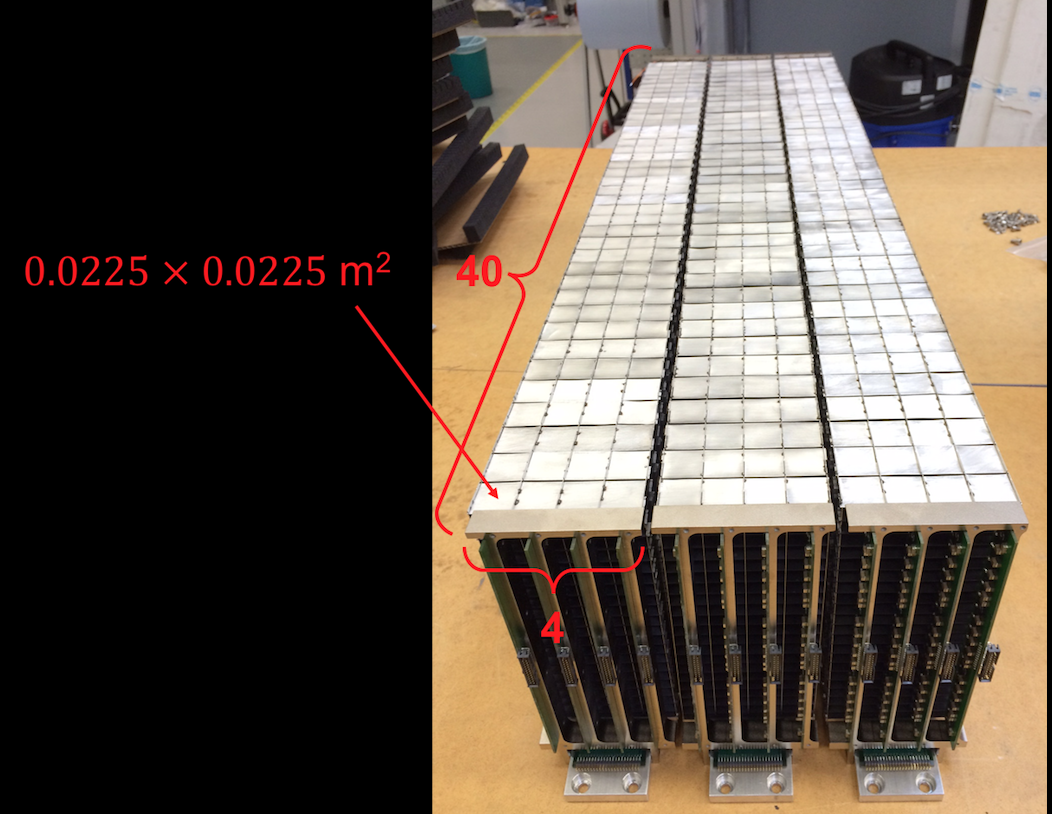
 height="400" width="500"><figcaption>Figure 1. Surface area calculation of the Multi-Grid detector.</figcaption></td></tr></table>



### Appending of data

First, the data is appended. As the time-stamp is reset at the begining of each measurement, the value of the last time-stamp from the first measurement is added to the time-stamps of the second measurement.

In [ ]:
clu_full = merge_files([mg_clu_run_8, mg_clu_run_9])
ev_full = merge_files([mg_ev_run_8, mg_ev_run_9])

### Data without filters

As a first step, the background data is studied without any filters.

In [ ]:
mg_filter = {'wm': [1, 1, False],                  # Wire multiplicity
             'gm': [1, 5, False],                  # Grid multiplicity
             'wadc': [600, np.inf, False],         # Wire charge
             'gadc': [600, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [80, 119, False]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*40
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_full, ev_full, mg_filter, area)

Looking at the plots, there are a few feautures that are noticed:
- **PHS vs Channel**: A few wires, such as ~channel 30, are much more active than the average, and the same is true of the top and bottom grid (80 and 119), especially the top. In addition to this, there seems to be a few hot spots over the grid column, such as that around channel 100, where the counts are locally higher. This is most obvious at the lower PHS values.
- **Even multiplicity**: A high percentage of wires firing without a grid in coincidence (20% of all registered clusters).
- **Charge coincidences**: There is a second straight line, with less statistics, with a lower inclination (about 1/4 the inclination of the main line) with respect to the grid charge.
- **Coincidences**: There is a large hot spot for a few wires at the top grid.
- **Rate vs time**: The rate drops over the first ten hours and is then stabilized.

### Removing top and bottom grid...

It is known from previous measurements that the exessive counts in the top and bottom grid is due to activity in the soldering material on the PCBs. The emissions from the soldering will be blocked in the final detector, removing these false events. Therefore, to get a more fair comparison to the rate that will be found in the final detector, data from these grids are removed and the area calculation is adjusted accordingly. Note that the 'PHS vs channel'-plot is not affected by the filters, as the data diplayed in that plot is from the raw events, not the clusters.

In [ ]:
mg_filter = {'wm': [1, 1, False],                  # Wire multiplicity
             'gm': [1, 5, False],                  # Grid multiplicity
             'wadc': [600, np.inf, False],         # Wire charge
             'gadc': [600, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_full, ev_full, mg_filter, area)

By removing the top and bottom grid, many of the spurious features first observed in data are removed: (1) there are no more wire events without a grid in coincidence, (2) the additional line the charge coincidences was removed (perhaps this was due to the fact that this was the top/bottom grid, and on average half of the emitted alphas and Li ions would be emitted in a direction out of the top/bottom of the detector?), (3) the time-dependence in the rate vs time plot was removed. Note that the color scale on the plots have change between different runs of plots to accomodoate the change in statistics.

A few observations of the new plots are made:
- **PHS**: Strong reduction in low energy events, the spectra now have clear plataues both for the wires and the grids.
- **Even multiplicity**: Approximately 2% of the remaining clusters are events with 2 wires in coincidence.
- **Coincidences and Uniformity**: There are a few hotspots, most notably every 20 wire channel (corresponding to the front of the detector) and a few regions of grids (~90, 100 and 115).

### ...while also removing high multiplicity events...

Another type of events we want to remove are those with more than 1 wire in coincidence (should be suppressed as the wires are physcially separated by the blades), as well as events with high a number of grids in coincidence (the upper limit is limited by the maximum path length of the alpha particles). Here, we select this limit as between 1 and 5 grids in coincidence, and only 1 wire in coincidence.

As seen from the previous series of plots, these events only constitute about 2% of all clusters after the top/bottom grids were removed. However, it is still important that they are removed.

In [ ]:
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [600, np.inf, False],         # Wire charge
             'gadc': [600, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_full, ev_full, mg_filter, area)

By adding the multiplicity filter, no appearant changes are seen in the plots, except a removal of higher multiplicity events and a lowering of the rate by approximately 0.03 Hz/m^2.

### ...as well as low ADC events.

The next type of events removed are low ADC events. Although true neutron events are also present in this region, there is an over-representation of gamma and electronic noises with low ADC values. Therefore, in the interest of achiveing the highest possible signal-to-noise ratio, these events are cut. Looking at the PHS, the threshold is put just at the base of the intial peak, at the start of the plateau. This is seen in figure 2 below, where a few possible thresholds (from left to right, 600, 800 and 1000 ADC channels) are displayed as black vertical lines. By visual inspection, 800 ADC channels appears to be an appropriate choice.

<table><tr><td><img src=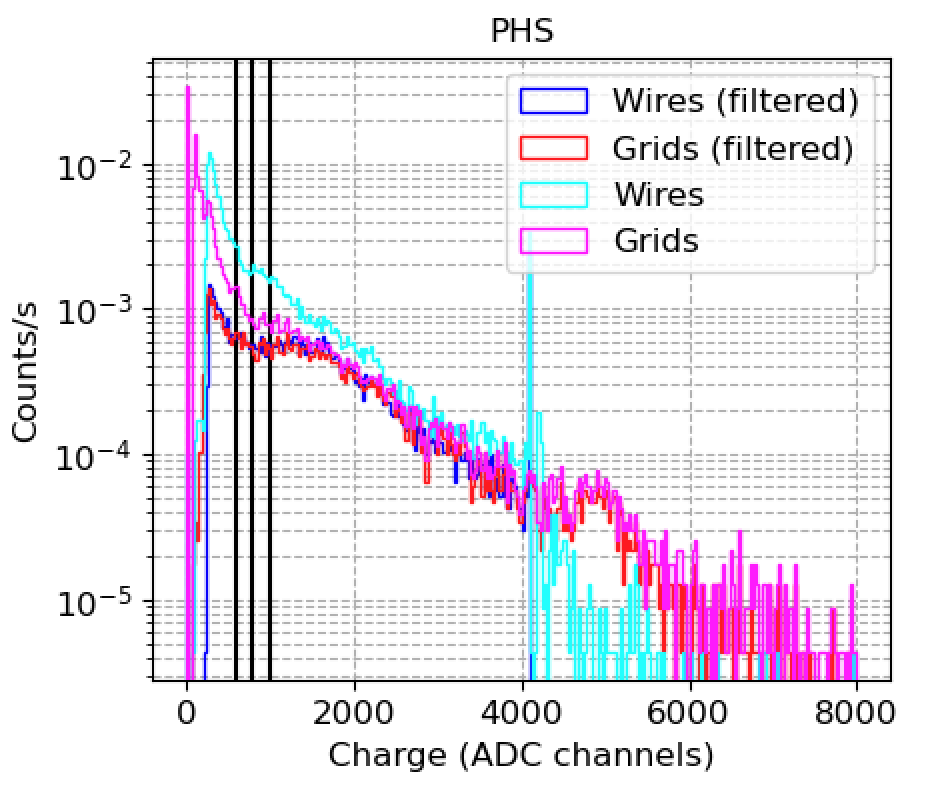
 height="400" width="500"><figcaption>Figure 2. Decision on threshold for the data. Starting from left to right, the vertical black lines are at 600, 800 and 1000 ADC channels.</figcaption></td></tr></table>

In [ ]:
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   
area = 0.0225*0.0225*4*38
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_full, ev_full, mg_filter, area)

By applying the ADC threshold, the rate was reduced by approximately 0.23 Hz/m^2. However, as seen in the coincidences and uniformity plots, there are still regions were the grids and wires have an elevated count rate. Therefore, the next step would be to investigate the events in these regions.

### Investigation of high rate grids

Data is selected only from the high rate grids and investigated. The comparison is made between grid 115 (which have the highest excessive counts), a few grids with excessive counts (88, 89, 97, 100, 112, 113, 114) and a low rate grid (channel 93). Each block below is for one of these filters, in the same order as they were mentioned here. The remaining plots are then examined to see if there are any differences between the high count grids and low counts grids, for example in PHS or multiplicity.

In [ ]:
# Basic filter
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
# Extra filter removing everything except the grids of choice
clu_temp = clu_full[clu_full.gch == 115]
area = 0.0225*0.0225*4*1
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_temp, ev_full, mg_filter, area)

In [ ]:
# Basic filter
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
# Extra filter removing everything except the grids of choice
, 89, 97, 100, 112, 113, 114
clu_temp = clu_full[(clu_full.gch == 88) |
                    (clu_full.gch == 89) |
                    (clu_full.gch == 97) |
                    (clu_full.gch == 100) |
                    (clu_full.gch == 112) |
                    (clu_full.gch == 113) |
                    (clu_full.gch == 114)]
area = 0.0225*0.0225*4*7
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_temp, ev_full, mg_filter, area)

In [ ]:
# Basic filter
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
# Extra filter removing everything except the grids of choice
clu_temp = clu_full[clu_full.gch == 93]
area = 0.0225*0.0225*4*1
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_temp, ev_full, mg_filter, area)

Unfortuntely, there was no clear signature found which separates the high count grids from the low count grids in terms of ADC or multiplicity.

### Investigation of high rate wires

Next, the same analysis that was done for the grids are conducted for the high rate wires, i.e. channels 0, 20, 40 and 60. Note that in this analysis, the count rate cannot be direcly compared, as the depth has changed from 20 to 1 wire. The rate can be approximately compared by scaling the observed rate by a factor 20, which would account for the depth difference.

In [ ]:
# Basic filter
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
# Extra filter removing everything except the grids of choice
clu_temp = clu_full[(clu_full.wch == 0) |
                    (clu_full.wch == 20) |
                    (clu_full.wch == 40) |
                    (clu_full.wch == 60)]
area = 0.0225*0.0225*4*38
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_temp, ev_full, mg_filter, area)

As in the case for the grids, no clear signature is seen for the wires. However, the middle grid is suspicously active, as seen in the grid uniformity plot.

### Removal of regions with high rates

To investigate what the rate in the detector would be in a scenario without the noisy regions, these regions are removed and the rate is calculated. Here, the first wire row is removed (channels, 0, 20, 40 and 60) along with grid 115.

In [ ]:
# Basic filter
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
# Extra filter removing everything except the grids of choice
clu_temp = clu_full[(clu_full.gch != 115) &
                    (clu_full.wch != 0) &
                    (clu_full.wch != 20) &
                    (clu_full.wch != 40) &
                    (clu_full.wch != 60)]

area = 0.0225*0.0225*4*37
bus = 0
mg_plot_basic_bus('run_8_and_9', bus, clu_temp, ev_full, mg_filter, area)

By removing these regions, the rate is reduced to the acceptable level of 0.4 Hz/m^2, which for a 16 layer detector would approximately be 0.4 * (16/19) = 0.34 Hz/m^2. Note that there appears to be a small gradient on wires from front to back, which would indicate neutrons entering from the front. Therefore, the true intrinsic background would most likely be lower than the one recorded here.

## 6.2. Utgård comparison<a class="anchor" id="UTGARD"></a>

To investigate some the feautures seen in the LET data, the previous measurements at Utgård are studied. First, the paths are declared, then data is clustered and/or loaded. After that, the data is plotted with the specified filter.

### Declare paths

In [7]:
RAW_FOLDER_UTGARD = '../data/let_preparations/raw/'
PROCESSED_FOLDER_UTGARD = '../data/let_preparations/processed/'

In [8]:
UTGARD_PATHS = {'utgard_run_1': RAW_FOLDER_UTGARD + 'mvmelst_191_200305_111506_utgard_first_run.zip',
                'utgard_run_2': RAW_FOLDER_UTGARD + 'mvmelst_193_200306_040827_mirrobor_covering_front_and_sides.zip',
                'utgard_run_3': RAW_FOLDER_UTGARD + 'mvmelst_194_200307_102939_unshielded.zip',
                'utgard_run_4': RAW_FOLDER_UTGARD + 'mvmelst_195_200309_033822_mirrorbor_shielding_opening_in_middle.zip',
                'utgard_run_5': RAW_FOLDER_UTGARD + 'mvmelst_196_200311_121940_mirrorbor_shielding_opening_at_top.zip',
                'utgard_run_6': RAW_FOLDER_UTGARD + 'mvmelst_197_200312_045631_unshielded_first_t0_test.zip',
                'utgard_run_7': RAW_FOLDER_UTGARD + 'mvmelst_198_200312_075113_unshielded_second_t0_test.zip',
                'utgard_run_8': RAW_FOLDER_UTGARD + 'mvmelst_199_200312_084636_unshielded_no_t0_signals_sent.zip',
                'utgard_run_9': RAW_FOLDER_UTGARD + 'mvmelst_200_200312_103913_unshielded_LVgournding_to_be_changed.zip',
                'utgard_run_10': RAW_FOLDER_UTGARD + 'mvmelst_201_200312_123407_unshielded_RWLVGndC_no_t0.zip',
                'utgard_run_11': RAW_FOLDER_UTGARD + 'mvmelst_202_200313_135642_SEQ_1_shielded_in_cave.zip',
                'utgard_run_12': RAW_FOLDER_UTGARD + 'mvmelst_203_200316_052259_SEQ1_shielded_in_cave_SEQ2VerticalShielded.zip',
                'utgard_run_13': RAW_FOLDER_UTGARD + 'mvmelst_204_200317_133017_SEQ1CaveShielded_SEQ2UnshieldedVertical_NewHV_NORHWGnd.zip',
                'utgard_run_14': RAW_FOLDER_UTGARD + 'mvmelst_205_200318_102317_SEQ1CaveShielded_SEQ2UnshieldedVertical_NORHWGnd_GasFlowReducedThenStopped.zip',
                'utgard_run_15': RAW_FOLDER_UTGARD + 'mvmelst_206_200323_050803_SEQ1CaveShielded_SEQ2UnshieldedVertical_NoRHWGnd_GasFlowResumed.zip',
                'utgard_run_16': RAW_FOLDER_UTGARD + 'mvmelst_207_200324_054624EQ1CaveShieldedwithGas_SEQ2UnshieldedVerticalTopHatOpen_NoRHWGnd_.zip',
                'utgard_run_17': RAW_FOLDER_UTGARD + 'mvmelst_210_200325_111153_SEQ1CaveShielded_SEQ2UnshieldedVertical_GasInThenBottleFinished_NoRHWGnd.zip',
                'utgard_run_18': RAW_FOLDER_UTGARD + 'mvmelst_211_200330_083628_SEQ1CaveShielded_SEQ2UnshieldedVertical_GasInThenBottleFinished_Continued_NoRHWGnd.zip',
                'utgard_run_19': RAW_FOLDER_UTGARD + 'mvmelst_212_200401_051232_SEQ1CaveShielded_SEQ2UnshieldedHorizontal_GasInAtTheStartOfTheRun_Continued_NoRHWGnd.zip',
                'utgard_run_20': RAW_FOLDER_UTGARD + 'mvmelst_213_200408_044106_SEQ1CaveShielded_SEQ2ShieldedHorizontal_FloatingGnd_NoRHWGnd.zip',
                'utgard_run_21': RAW_FOLDER_UTGARD + 'mvmelst_229_200902_110641_1stRunSep2020-MGSEQ1inCave_MGSEQ2B4CShielded.zip',
                'utgard_run_22': RAW_FOLDER_UTGARD + 'mvmelst_214_200902_051721.zip',
                'utgard_run_23': RAW_FOLDER_UTGARD + 'mvmelst_231_200911_051736_3RunSep2020-MGSEQ1CaveShielded_MGSEQ2B4CSielded_cardUnplugedPluged_CrateGround.zip',
                'utgard_run_24': RAW_FOLDER_UTGARD + 'mvmelst_232_200918_111747_4RunSep2020-MGSEQ1CaveShielded_MGSEQ2B4CShielded_FloatingGnd.zip',
                'utgard_run_25': RAW_FOLDER_UTGARD + 'mvmelst_233_200923_105950-MGSEQ1undertableSomeB4C_MGSEQ2B4CShielded_floatingGnd.zip',
                'utgard_run_26': RAW_FOLDER_UTGARD + 'mvmelst_265_201210_120808.zip',
                'utgard_run_27': RAW_FOLDER_UTGARD + 'bgUtgard_GasFlowStopped_mvmelst_266_201211_084940.zip',
                'utgard_run_28': RAW_FOLDER_UTGARD + 'bgUtgard_GasFlowResumed_mvmelst_267_201214_080608.zip',
                'utgard_run_29': RAW_FOLDER_UTGARD + 'bgUtgard_LongRun_mvmelst_267_201216_080826.zip',
                'utgard_run_30': RAW_FOLDER_UTGARD + 'XmasHolidayLongRun_mvmelst_269_201223_092541.zip',
                'utgard_run_31': RAW_FOLDER_UTGARD + 'bgUtgard_LongRun_NewB4CVessel_mvmelst_271_210121_131744.zip',
                'utgard_run_32': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4Vessel_GasFlowFixed_mvmelst_273_210128_112409.zip',
                'utgard_run_33': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip',
                'utgard_run_34': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip',
                'utgard_run_35': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip',
                'utgard_run_36': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_279_210211_153557.zip',
                'utgard_run_37': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_281_210219_155146.zip',
                'utgard_run_38': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_Transformer.zip',
                'utgard_run_39': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_GasFlowFixed_Transformer_mvmelst_284_210312_154900.zip',
                'utgard_run_40': RAW_FOLDER_UTGARD + 'mvmelst_177_191115_095131_SEQUOIA__II_15_11_2019_to_18_11_2019_mirrorbor_covering_detector_front.zip',
                'utgard_run_41': RAW_FOLDER_UTGARD + 'mvmelst_179_191118_065800_SEQUOIA_II_18_11_2019_to_20_11_2019_no_mirrorbor_shielding.zip',
                'utgard_run_42': RAW_FOLDER_UTGARD + 'mvmelst_181_191120_100402_SEQUOIA__II_20_11_2019_to_22_11_2019_mirrorbor_shielding_top_and_bottom.zip',
                'utgard_run_43': RAW_FOLDER_UTGARD + 'mvmelst_182_191122_102541_SEQUOIA_II_22_11_2019_to_25_11_2019_mirrorbor_shielding_top_and_bottom_setup_2.zip',
                'utgard_run_44': RAW_FOLDER_UTGARD + 'mvmelst_184_191125_054759_SEQUOIA_II_tried_switching_card_3h.zip',
                'utgard_run_45': RAW_FOLDER_UTGARD + 'mvmelst_185_191125_091109_SEQUOIA_II_25_11_2019_to_29_11_2019_mirrorbor_shielding_top_and_bottom_setup_2_attempt_2.zip',
                'utgard_run_46': RAW_FOLDER_UTGARD + 'mvmelst_186_191129_093348_SEQUOIA_II_raised_voltage_1450V_20_min_test.zip',
                'utgard_run_47': RAW_FOLDER_UTGARD + 'mvmelst_187_191129_100050_SEQUOIA_II_1300_V_29_11_2019_to_02_12_2019_mirrorbor_shielding_top_and_bottom_setup_2_no_shielding_on_sequoia_II.zip',
                'utgard_run_48': RAW_FOLDER_UTGARD + 'mvmelst_188_191203_101632_SEQUOIA_II_1350_V_03_12_2019_to_05_12_2019_SEQUOIA_II_shielded_with_polyethylene_and_mirrorbor_sides_and_front.zip',
                'utgard_run_49': RAW_FOLDER_UTGARD + 'mvmelst_189_191205_093810_SEQUOIA_I_06_12_2019_to_09_12_2019_inside_new_cave.zip',
                'utgard_run_50': RAW_FOLDER_UTGARD + 'bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_285_210319_162850.zip',
                'utgard_run_51': RAW_FOLDER_UTGARD + 'bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip'
               }

### Cluster data

In [ ]:
# Note that extract and save function only need to be done ONCE.
#mg_read.extract_and_save('utgard_run_26', UTGARD_PATHS['utgard_run_26'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_27', UTGARD_PATHS['utgard_run_27'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_28', UTGARD_PATHS['utgard_run_28'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_29', UTGARD_PATHS['utgard_run_29'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_30', UTGARD_PATHS['utgard_run_30'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_31', UTGARD_PATHS['utgard_run_31'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_32', UTGARD_PATHS['utgard_run_32'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_33', UTGARD_PATHS['utgard_run_33'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_34', UTGARD_PATHS['utgard_run_34'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_35', UTGARD_PATHS['utgard_run_35'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_36', UTGARD_PATHS['utgard_run_36'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_37', UTGARD_PATHS['utgard_run_37'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_38', UTGARD_PATHS['utgard_run_38'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_39', UTGARD_PATHS['utgard_run_39'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_40', UTGARD_PATHS['utgard_run_40'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_41', UTGARD_PATHS['utgard_run_41'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_42', UTGARD_PATHS['utgard_run_42'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_43', UTGARD_PATHS['utgard_run_43'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_44', UTGARD_PATHS['utgard_run_44'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_45', UTGARD_PATHS['utgard_run_45'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_46', UTGARD_PATHS['utgard_run_46'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_47', UTGARD_PATHS['utgard_run_47'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_48', UTGARD_PATHS['utgard_run_48'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_49', UTGARD_PATHS['utgard_run_49'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_50', UTGARD_PATHS['utgard_run_50'], PROCESSED_FOLDER_UTGARD)
#mg_read.extract_and_save('utgard_run_51', UTGARD_PATHS['utgard_run_51'], PROCESSED_FOLDER_UTGARD)

### Import clusters

In [9]:
clu_utgard_run_1, ev_utgard_run_1 = mg_read.load_clusters_and_events('utgard_run_1', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_2, ev_utgard_run_2 = mg_read.load_clusters_and_events('utgard_run_2', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_3, ev_utgard_run_3 = mg_read.load_clusters_and_events('utgard_run_3', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_4, ev_utgard_run_4 = mg_read.load_clusters_and_events('utgard_run_4', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_5, ev_utgard_run_5 = mg_read.load_clusters_and_events('utgard_run_5', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_6, ev_utgard_run_6 = mg_read.load_clusters_and_events('utgard_run_6', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_7, ev_utgard_run_7 = mg_read.load_clusters_and_events('utgard_run_7', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_8, ev_utgard_run_8 = mg_read.load_clusters_and_events('utgard_run_8', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_9, ev_utgard_run_9 = mg_read.load_clusters_and_events('utgard_run_9', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_10, ev_utgard_run_10 = mg_read.load_clusters_and_events('utgard_run_10', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_11, ev_utgard_run_11 = mg_read.load_clusters_and_events('utgard_run_11', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_12, ev_utgard_run_12 = mg_read.load_clusters_and_events('utgard_run_12', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_13, ev_utgard_run_13 = mg_read.load_clusters_and_events('utgard_run_13', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_14, ev_utgard_run_14 = mg_read.load_clusters_and_events('utgard_run_14', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_15, ev_utgard_run_15 = mg_read.load_clusters_and_events('utgard_run_15', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_16, ev_utgard_run_16 = mg_read.load_clusters_and_events('utgard_run_16', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_17, ev_utgard_run_17 = mg_read.load_clusters_and_events('utgard_run_17', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_18, ev_utgard_run_18 = mg_read.load_clusters_and_events('utgard_run_18', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_19, ev_utgard_run_19 = mg_read.load_clusters_and_events('utgard_run_19', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_20, ev_utgard_run_20 = mg_read.load_clusters_and_events('utgard_run_20', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_21, ev_utgard_run_21 = mg_read.load_clusters_and_events('utgard_run_21', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_22, ev_utgard_run_22 = 0, 0 #mg_read.load_clusters_and_events('utgard_run_22', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_23, ev_utgard_run_23 = mg_read.load_clusters_and_events('utgard_run_23', PROCESSED_FOLDER_UTGARD)

clu_utgard_run_24, ev_utgard_run_24 = mg_read.load_clusters_and_events('utgard_run_24', PROCESSED_FOLDER_UTGARD) # Was commented for some reason

clu_utgard_run_25, ev_utgard_run_25 = mg_read.load_clusters_and_events('utgard_run_25', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_26, ev_utgard_run_26 = mg_read.load_clusters_and_events('utgard_run_26', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_27, ev_utgard_run_27 = mg_read.load_clusters_and_events('utgard_run_27', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_28, ev_utgard_run_28 = mg_read.load_clusters_and_events('utgard_run_28', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_29, ev_utgard_run_29 = mg_read.load_clusters_and_events('utgard_run_29', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_30, ev_utgard_run_30 = mg_read.load_clusters_and_events('utgard_run_30', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_31, ev_utgard_run_31 = mg_read.load_clusters_and_events('utgard_run_31', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_31, ev_utgard_run_31 = mg_read.load_clusters_and_events('utgard_run_31', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_32, ev_utgard_run_32 = mg_read.load_clusters_and_events('utgard_run_32', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_33, ev_utgard_run_33 = mg_read.load_clusters_and_events('utgard_run_33', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_34, ev_utgard_run_34 = mg_read.load_clusters_and_events('utgard_run_34', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_35, ev_utgard_run_35 = mg_read.load_clusters_and_events('utgard_run_35', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_36, ev_utgard_run_36 = mg_read.load_clusters_and_events('utgard_run_36', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_37, ev_utgard_run_37 = mg_read.load_clusters_and_events('utgard_run_37', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_38, ev_utgard_run_38 = mg_read.load_clusters_and_events('utgard_run_38', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_39, ev_utgard_run_39 = mg_read.load_clusters_and_events('utgard_run_39', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_40, ev_utgard_run_40 = mg_read.load_clusters_and_events('utgard_run_40', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_41, ev_utgard_run_41 = mg_read.load_clusters_and_events('utgard_run_41', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_42, ev_utgard_run_42 = mg_read.load_clusters_and_events('utgard_run_42', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_43, ev_utgard_run_43 = mg_read.load_clusters_and_events('utgard_run_43', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_44, ev_utgard_run_44 = mg_read.load_clusters_and_events('utgard_run_44', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_45, ev_utgard_run_45 = mg_read.load_clusters_and_events('utgard_run_45', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_46, ev_utgard_run_46 = mg_read.load_clusters_and_events('utgard_run_46', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_47, ev_utgard_run_47 = mg_read.load_clusters_and_events('utgard_run_47', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_48, ev_utgard_run_48 = mg_read.load_clusters_and_events('utgard_run_48', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_49, ev_utgard_run_49 = mg_read.load_clusters_and_events('utgard_run_49', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_50, ev_utgard_run_50 = mg_read.load_clusters_and_events('utgard_run_50', PROCESSED_FOLDER_UTGARD)
clu_utgard_run_51, ev_utgard_run_51 = mg_read.load_clusters_and_events('utgard_run_51', PROCESSED_FOLDER_UTGARD)

In [ ]:
#clu_utgard_run_31, ev_utgard_run_31 = mg_read.load_clusters_and_events('utgard_run_31', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_32, ev_utgard_run_32 = mg_read.load_clusters_and_events('utgard_run_32', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_33, ev_utgard_run_33 = mg_read.load_clusters_and_events('utgard_run_33', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_34, ev_utgard_run_34 = mg_read.load_clusters_and_events('utgard_run_34', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_35, ev_utgard_run_35 = mg_read.load_clusters_and_events('utgard_run_35', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_36, ev_utgard_run_36 = mg_read.load_clusters_and_events('utgard_run_36', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_37, ev_utgard_run_37 = mg_read.load_clusters_and_events('utgard_run_37', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_38, ev_utgard_run_38 = mg_read.load_clusters_and_events('utgard_run_38', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_39, ev_utgard_run_39 = mg_read.load_clusters_and_events('utgard_run_39', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_40, ev_utgard_run_40 = mg_read.load_clusters_and_events('utgard_run_40', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_41, ev_utgard_run_41 = mg_read.load_clusters_and_events('utgard_run_41', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_42, ev_utgard_run_42 = mg_read.load_clusters_and_events('utgard_run_42', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_43, ev_utgard_run_43 = mg_read.load_clusters_and_events('utgard_run_43', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_44, ev_utgard_run_44 = mg_read.load_clusters_and_events('utgard_run_44', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_45, ev_utgard_run_45 = mg_read.load_clusters_and_events('utgard_run_45', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_46, ev_utgard_run_46 = mg_read.load_clusters_and_events('utgard_run_46', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_47, ev_utgard_run_47 = mg_read.load_clusters_and_events('utgard_run_47', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_48, ev_utgard_run_48 = mg_read.load_clusters_and_events('utgard_run_48', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_49, ev_utgard_run_49 = mg_read.load_clusters_and_events('utgard_run_49', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_50, ev_utgard_run_50 = mg_read.load_clusters_and_events('utgard_run_50', PROCESSED_FOLDER_UTGARD)
#clu_utgard_run_51, ev_utgard_run_51 = mg_read.load_clusters_and_events('utgard_run_51', PROCESSED_FOLDER_UTGARD)

### Plot all Utgård data

<IPython.core.display.Javascript object>


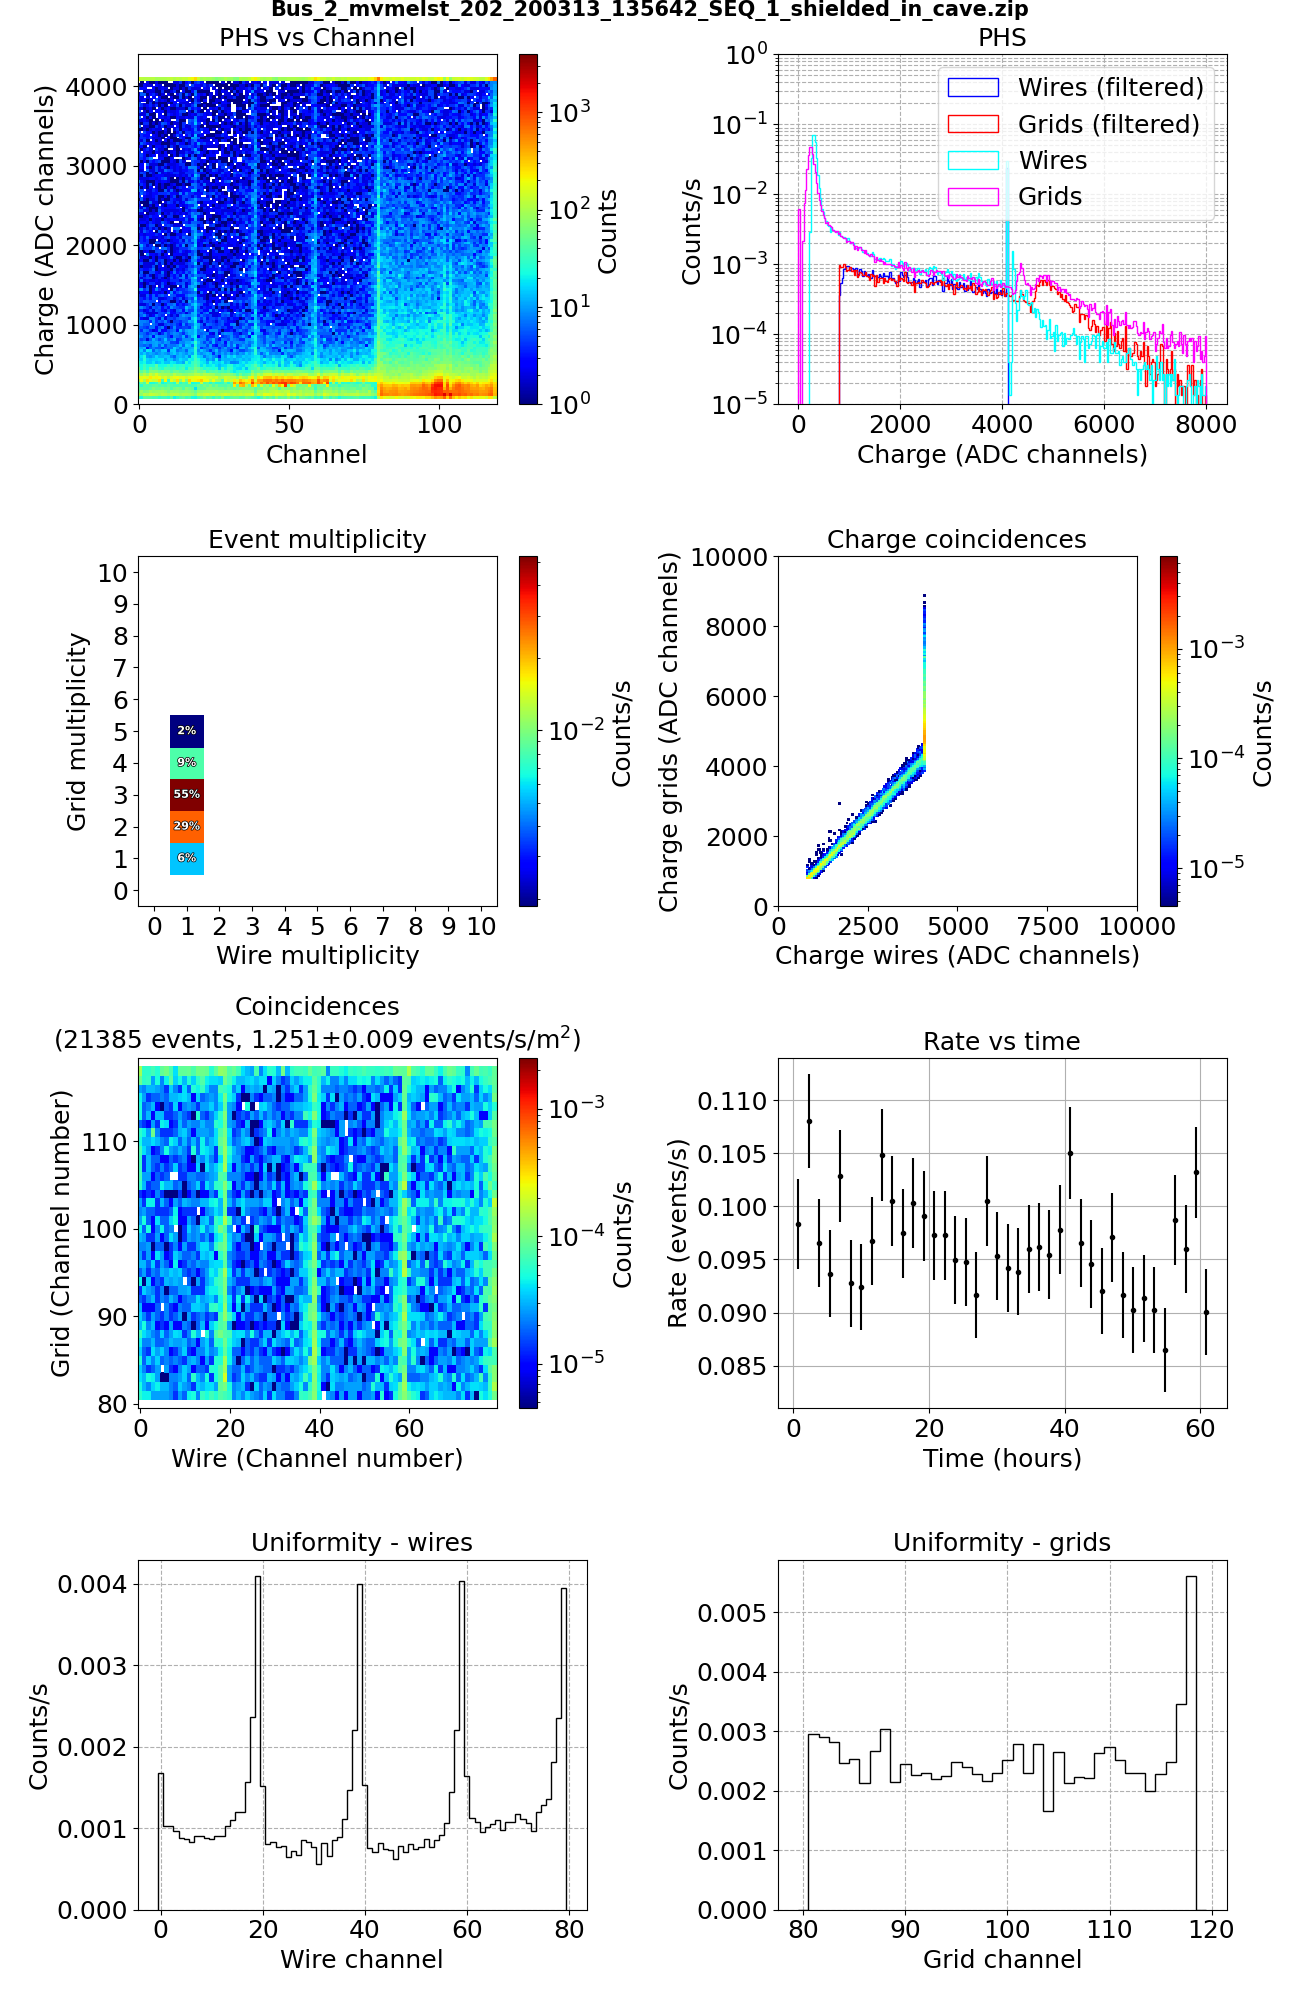

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


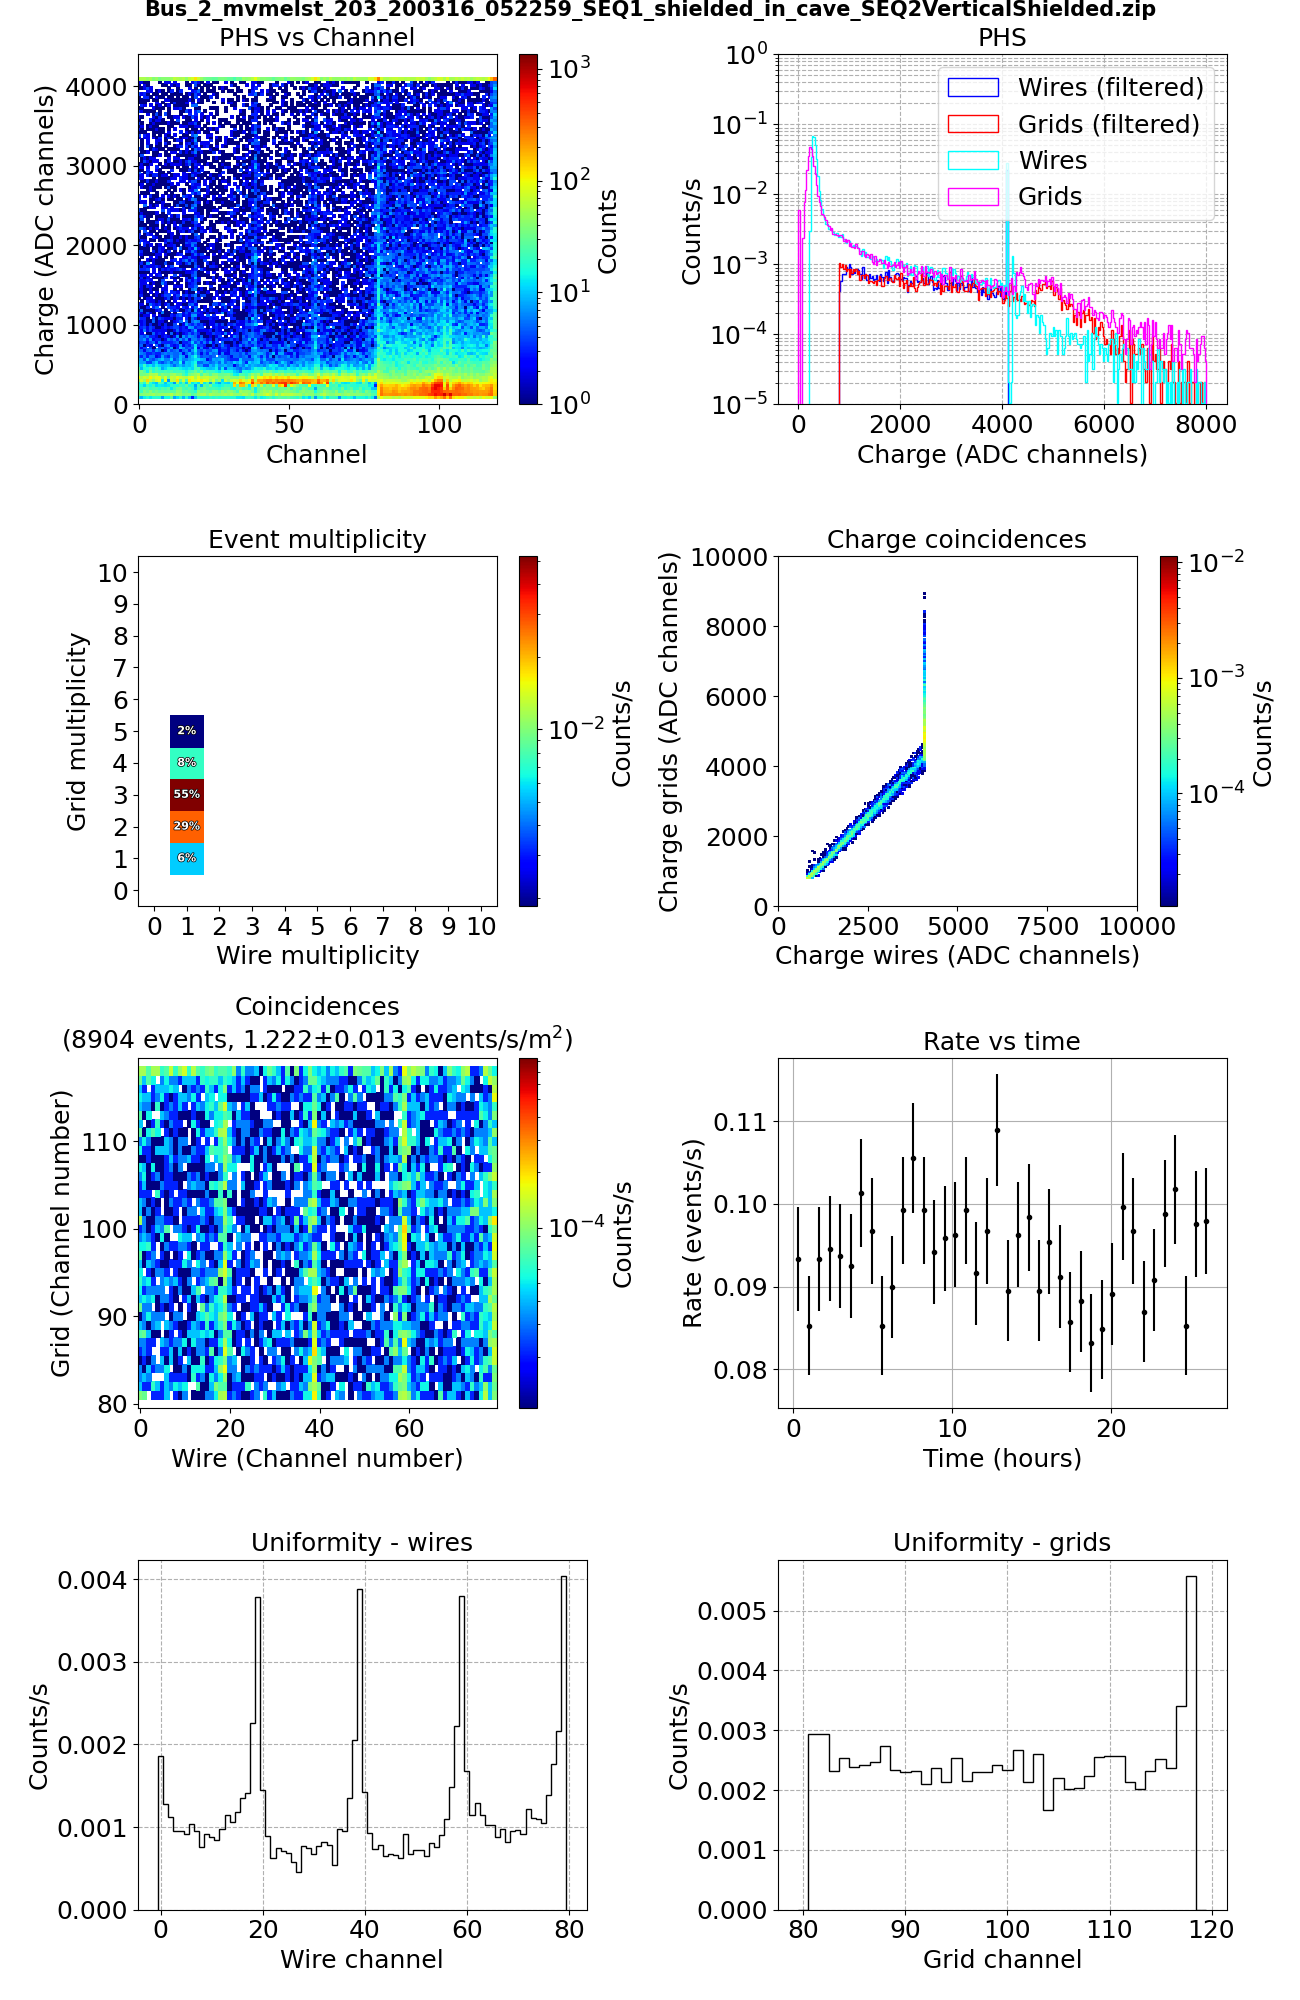

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


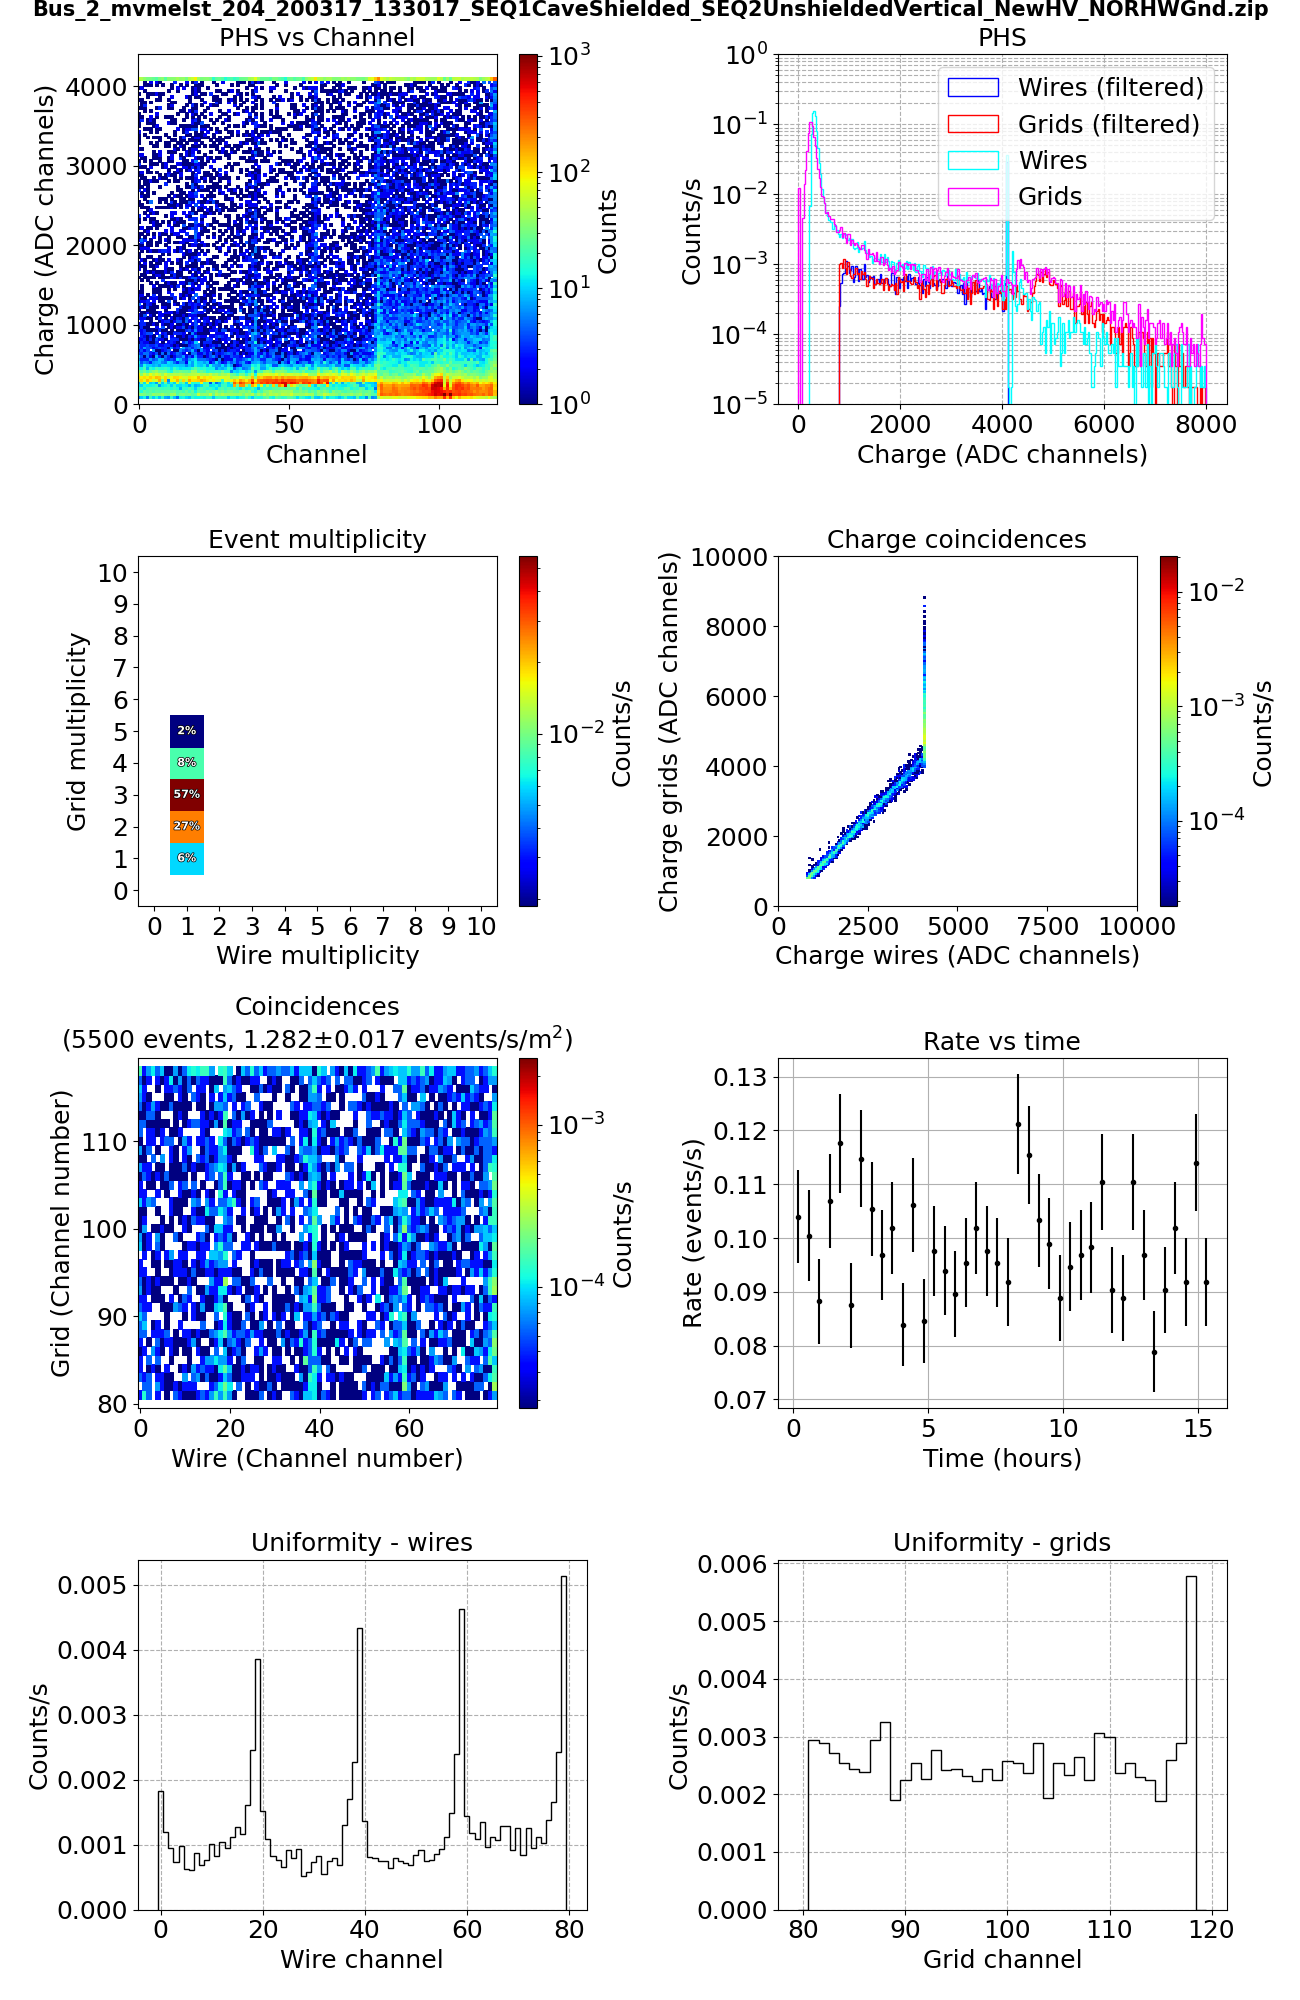

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


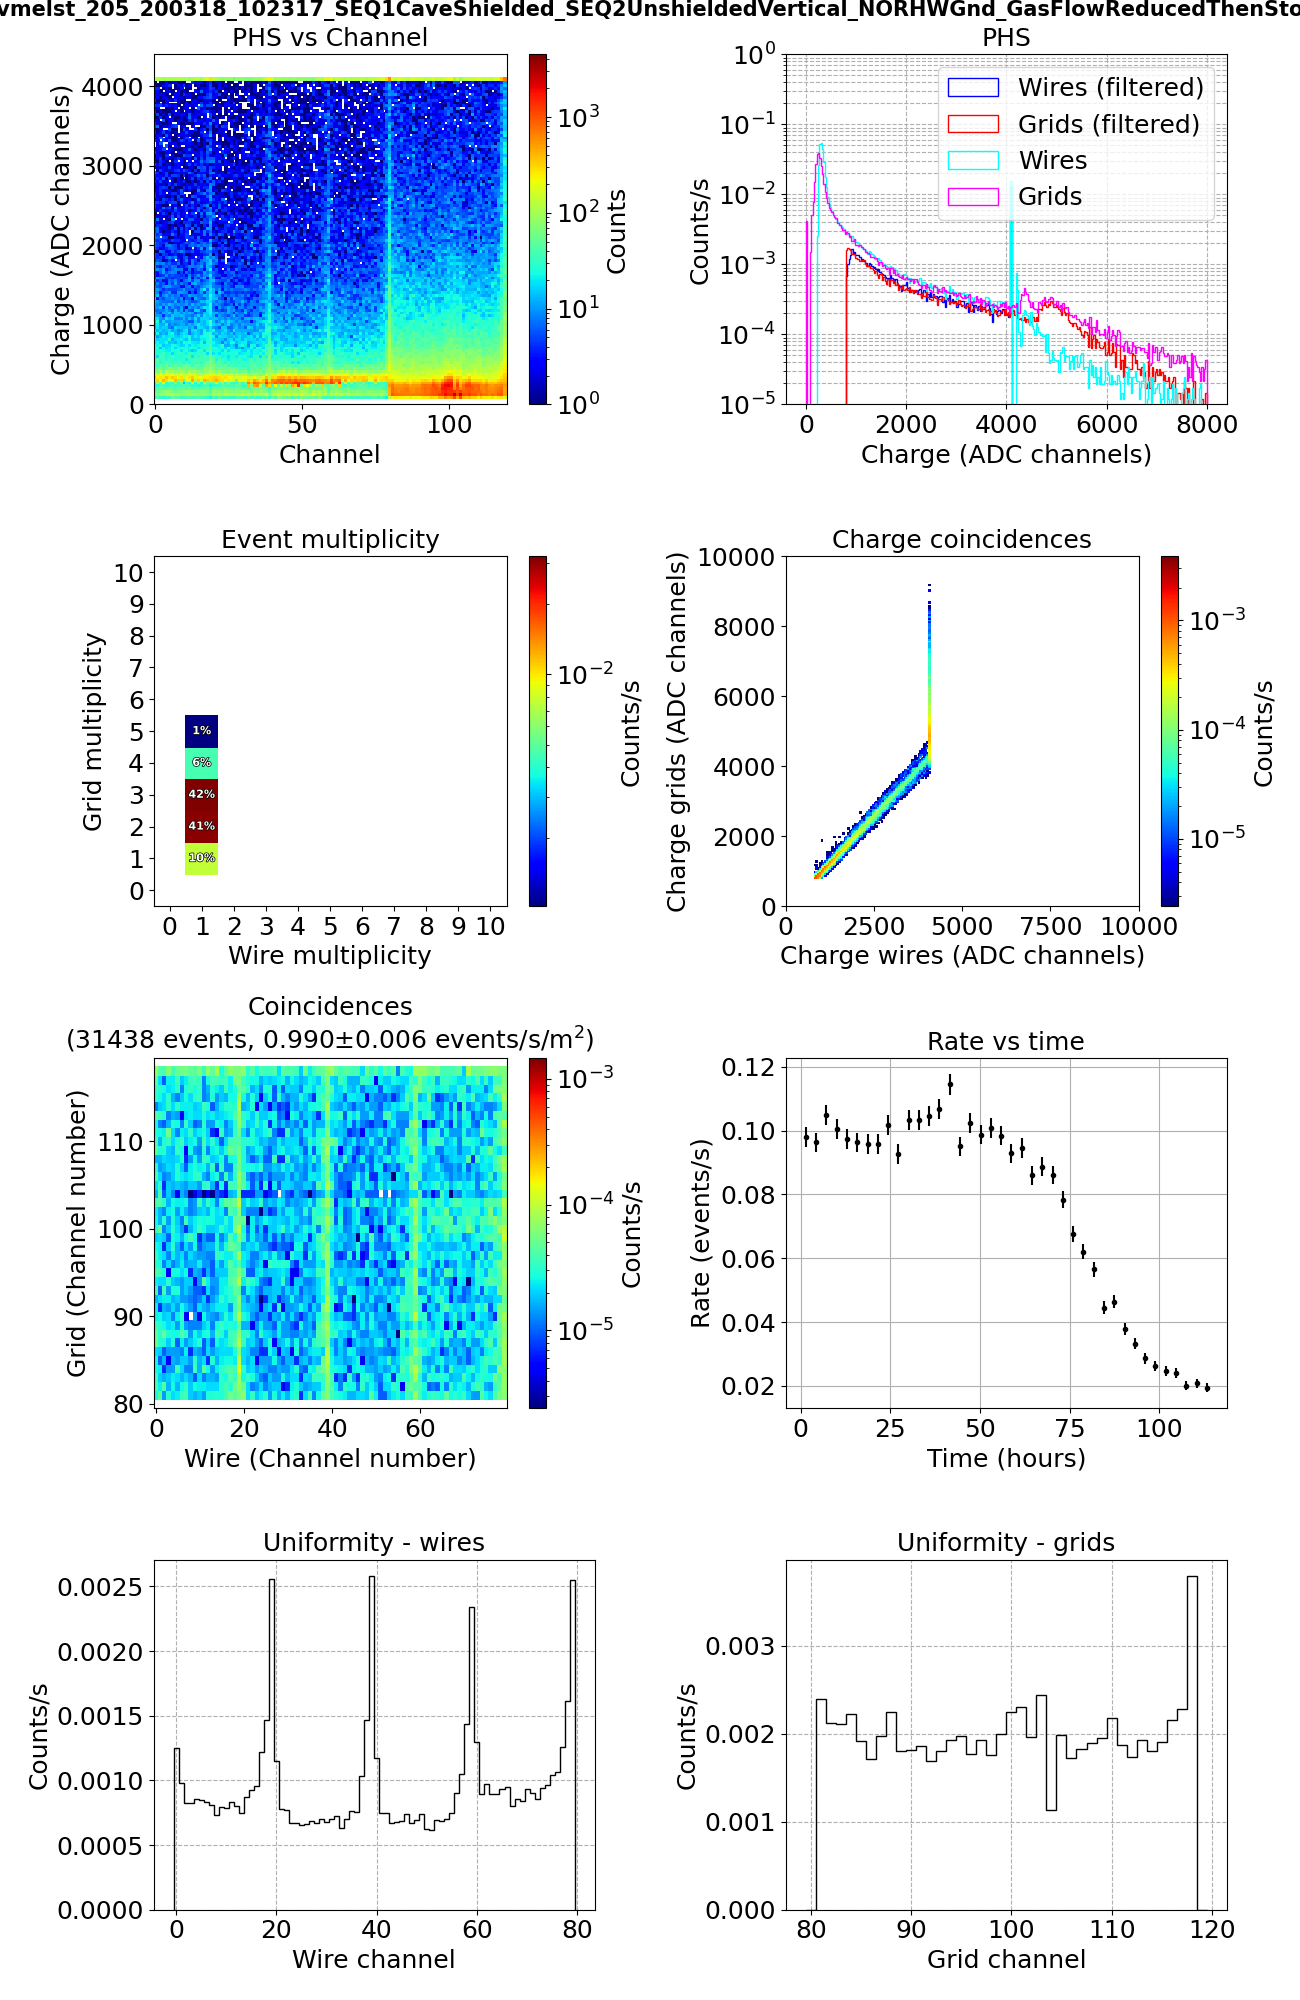

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


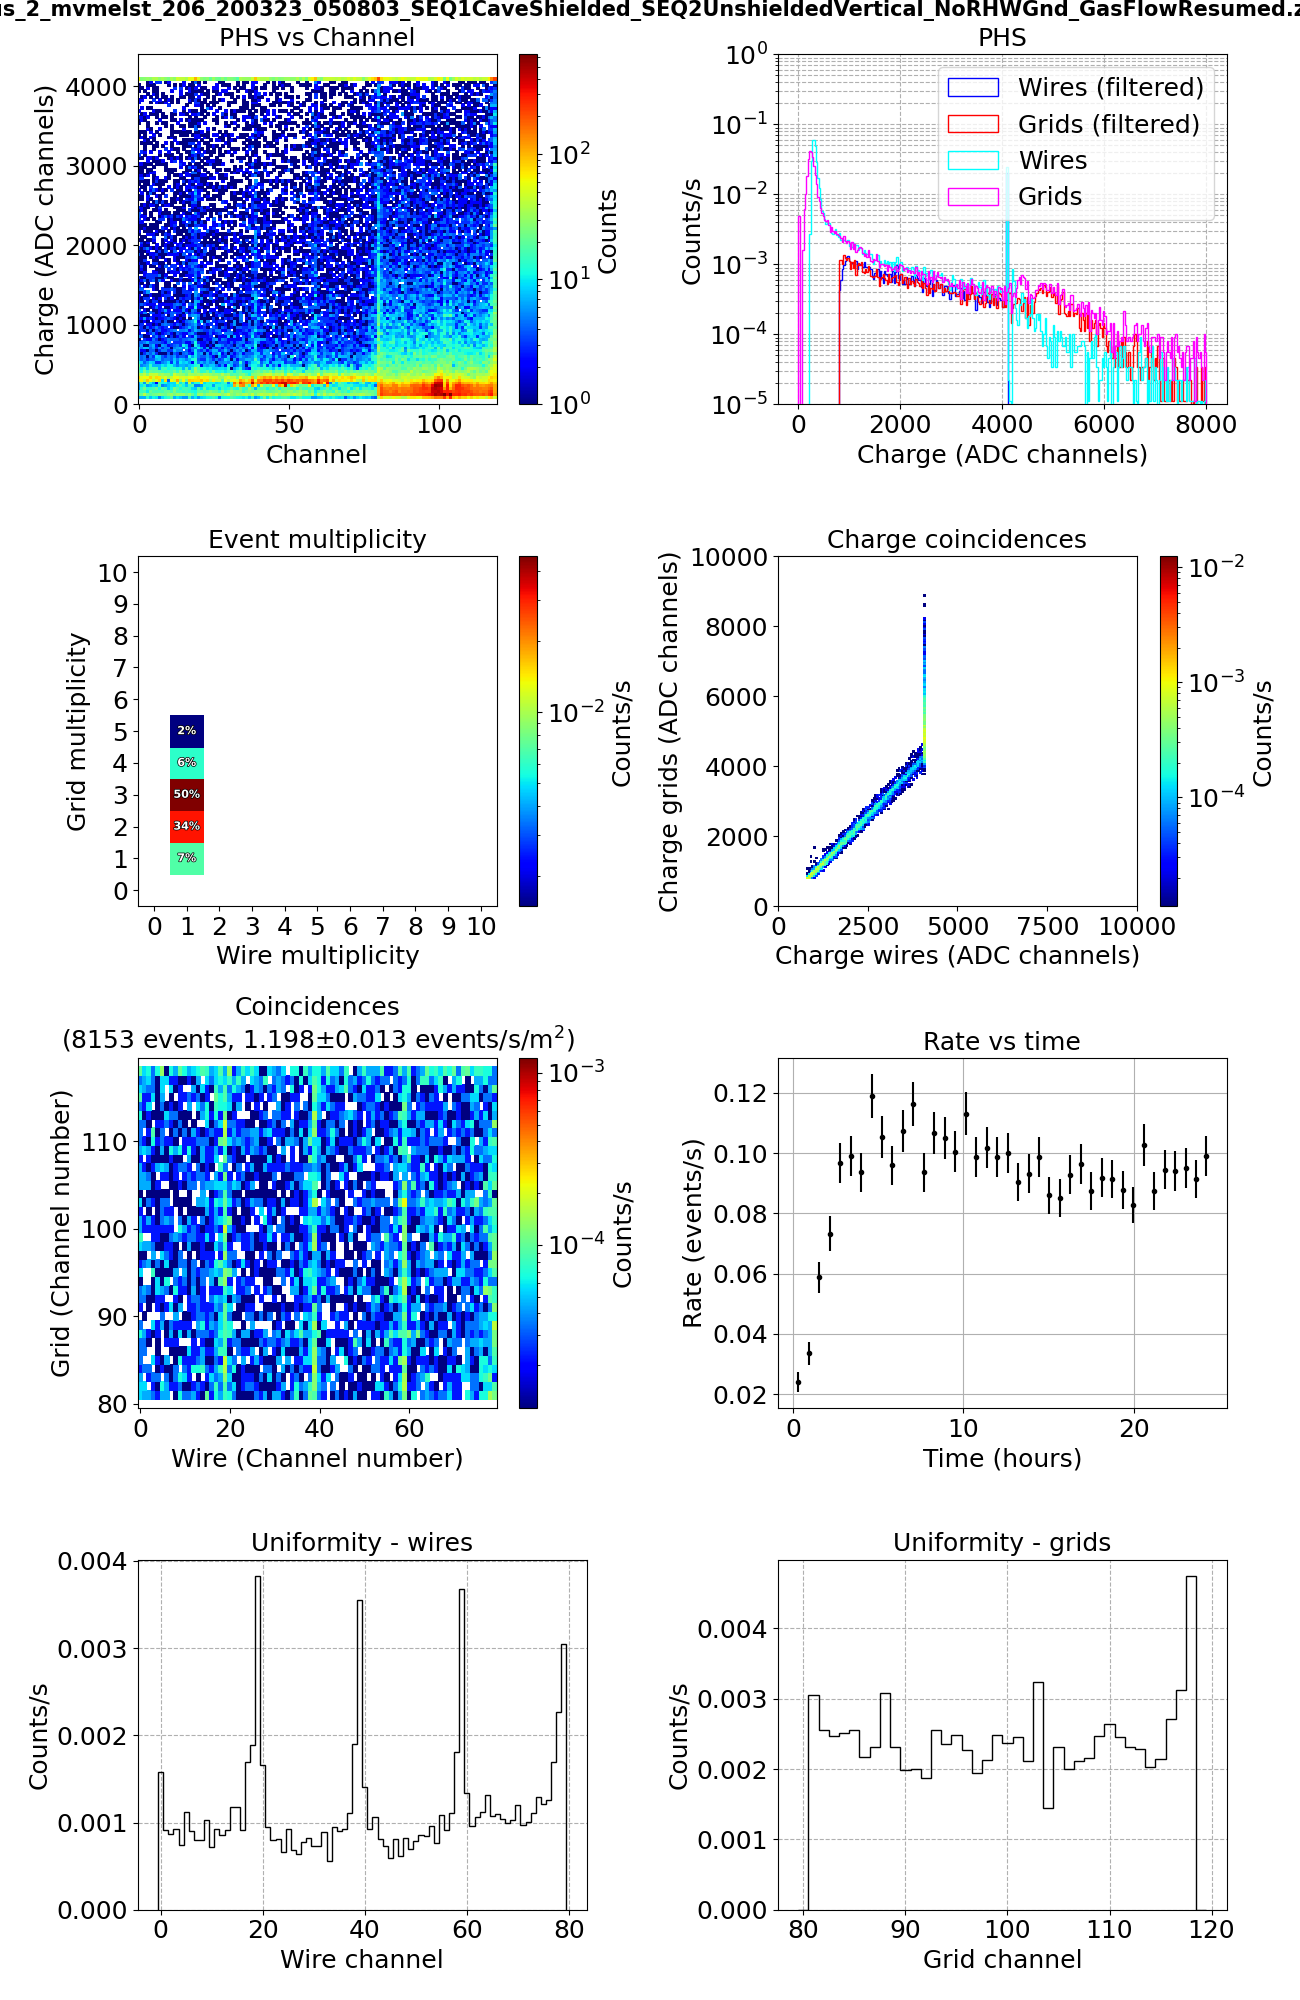

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


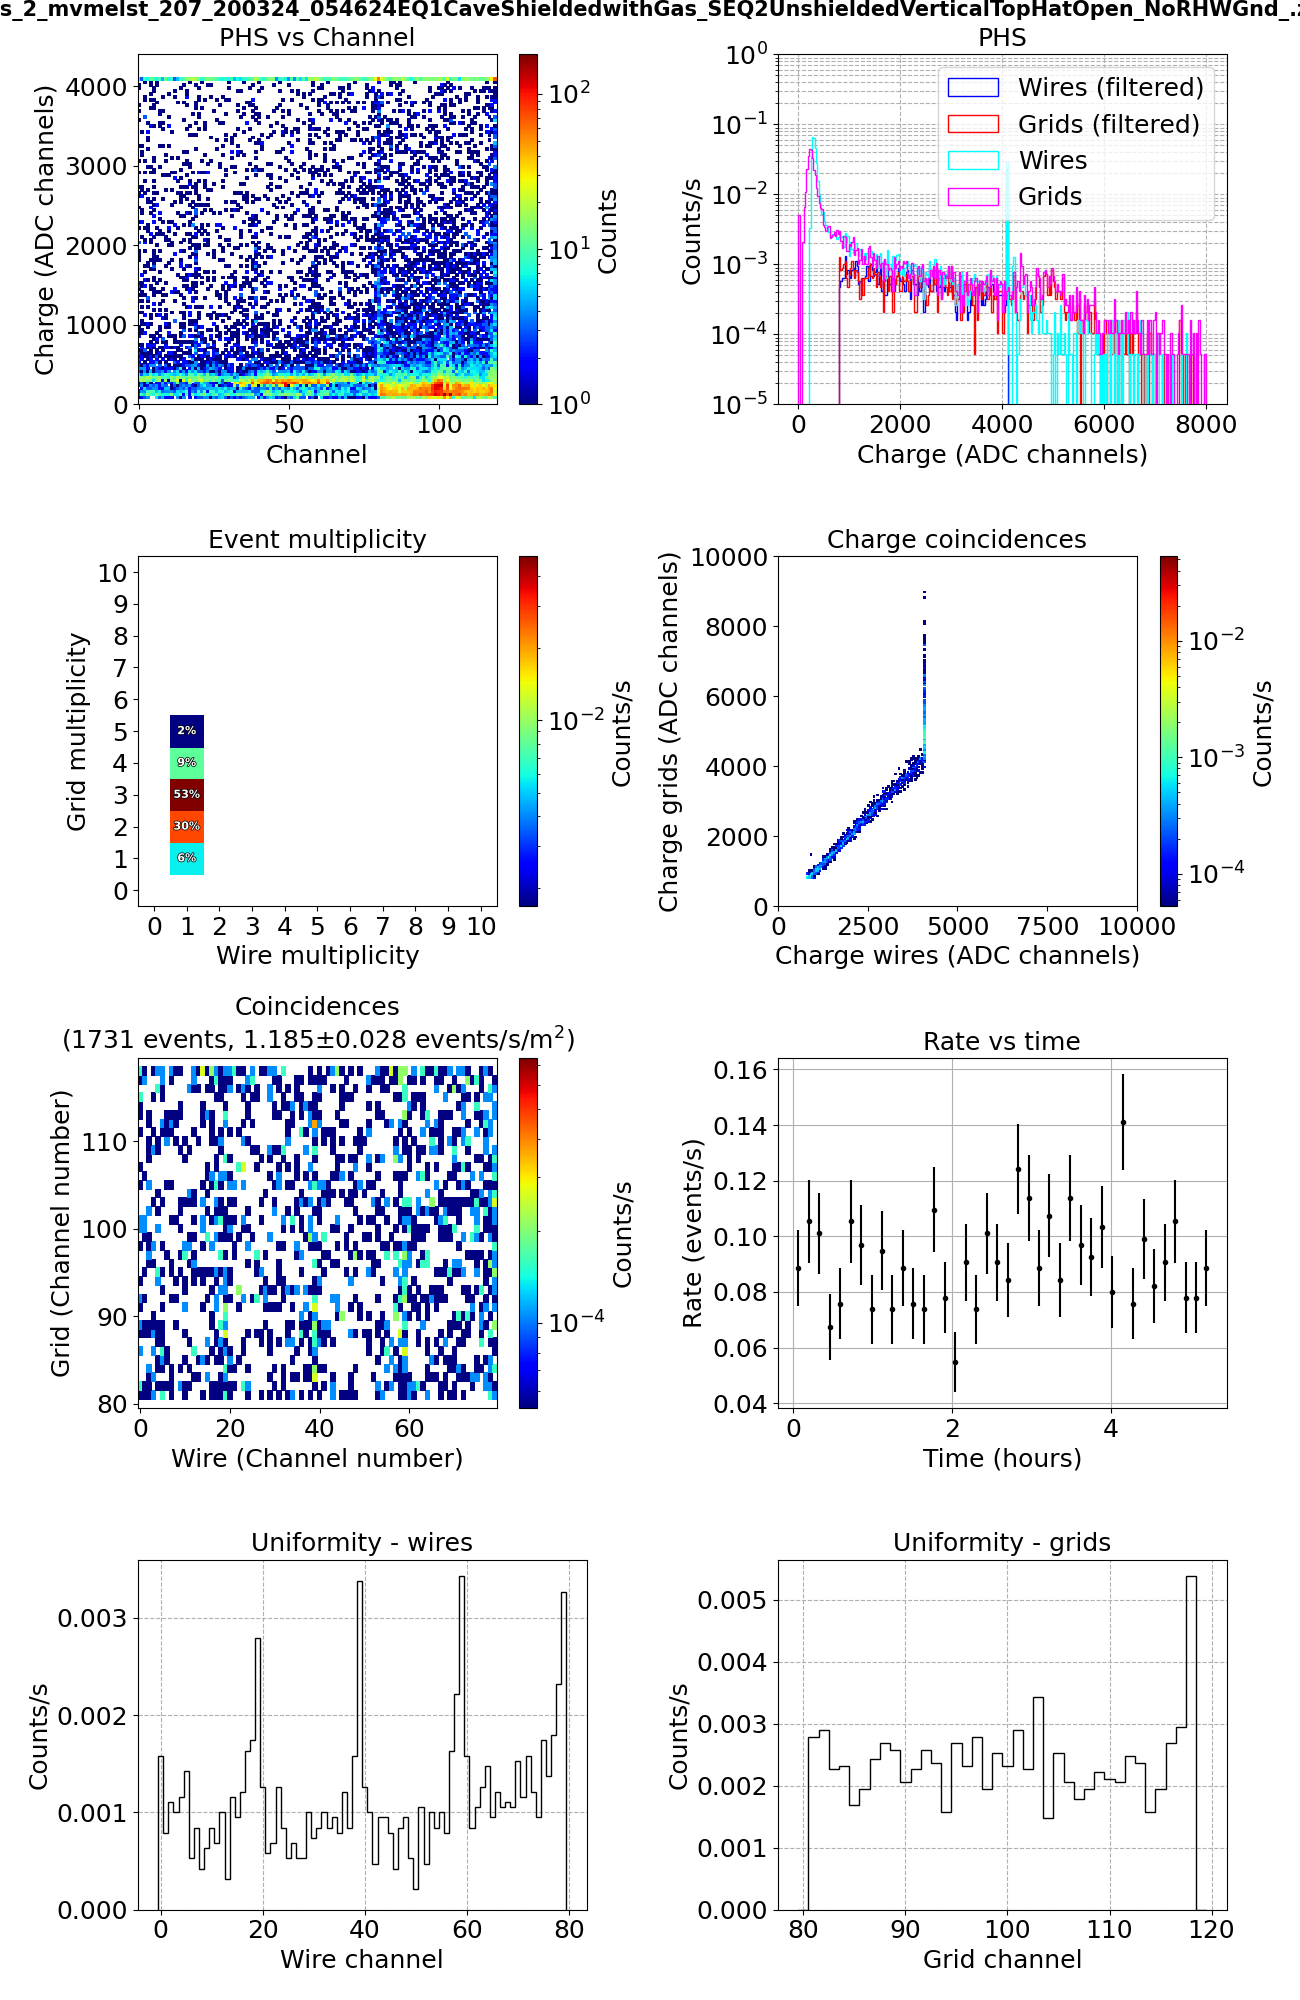

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


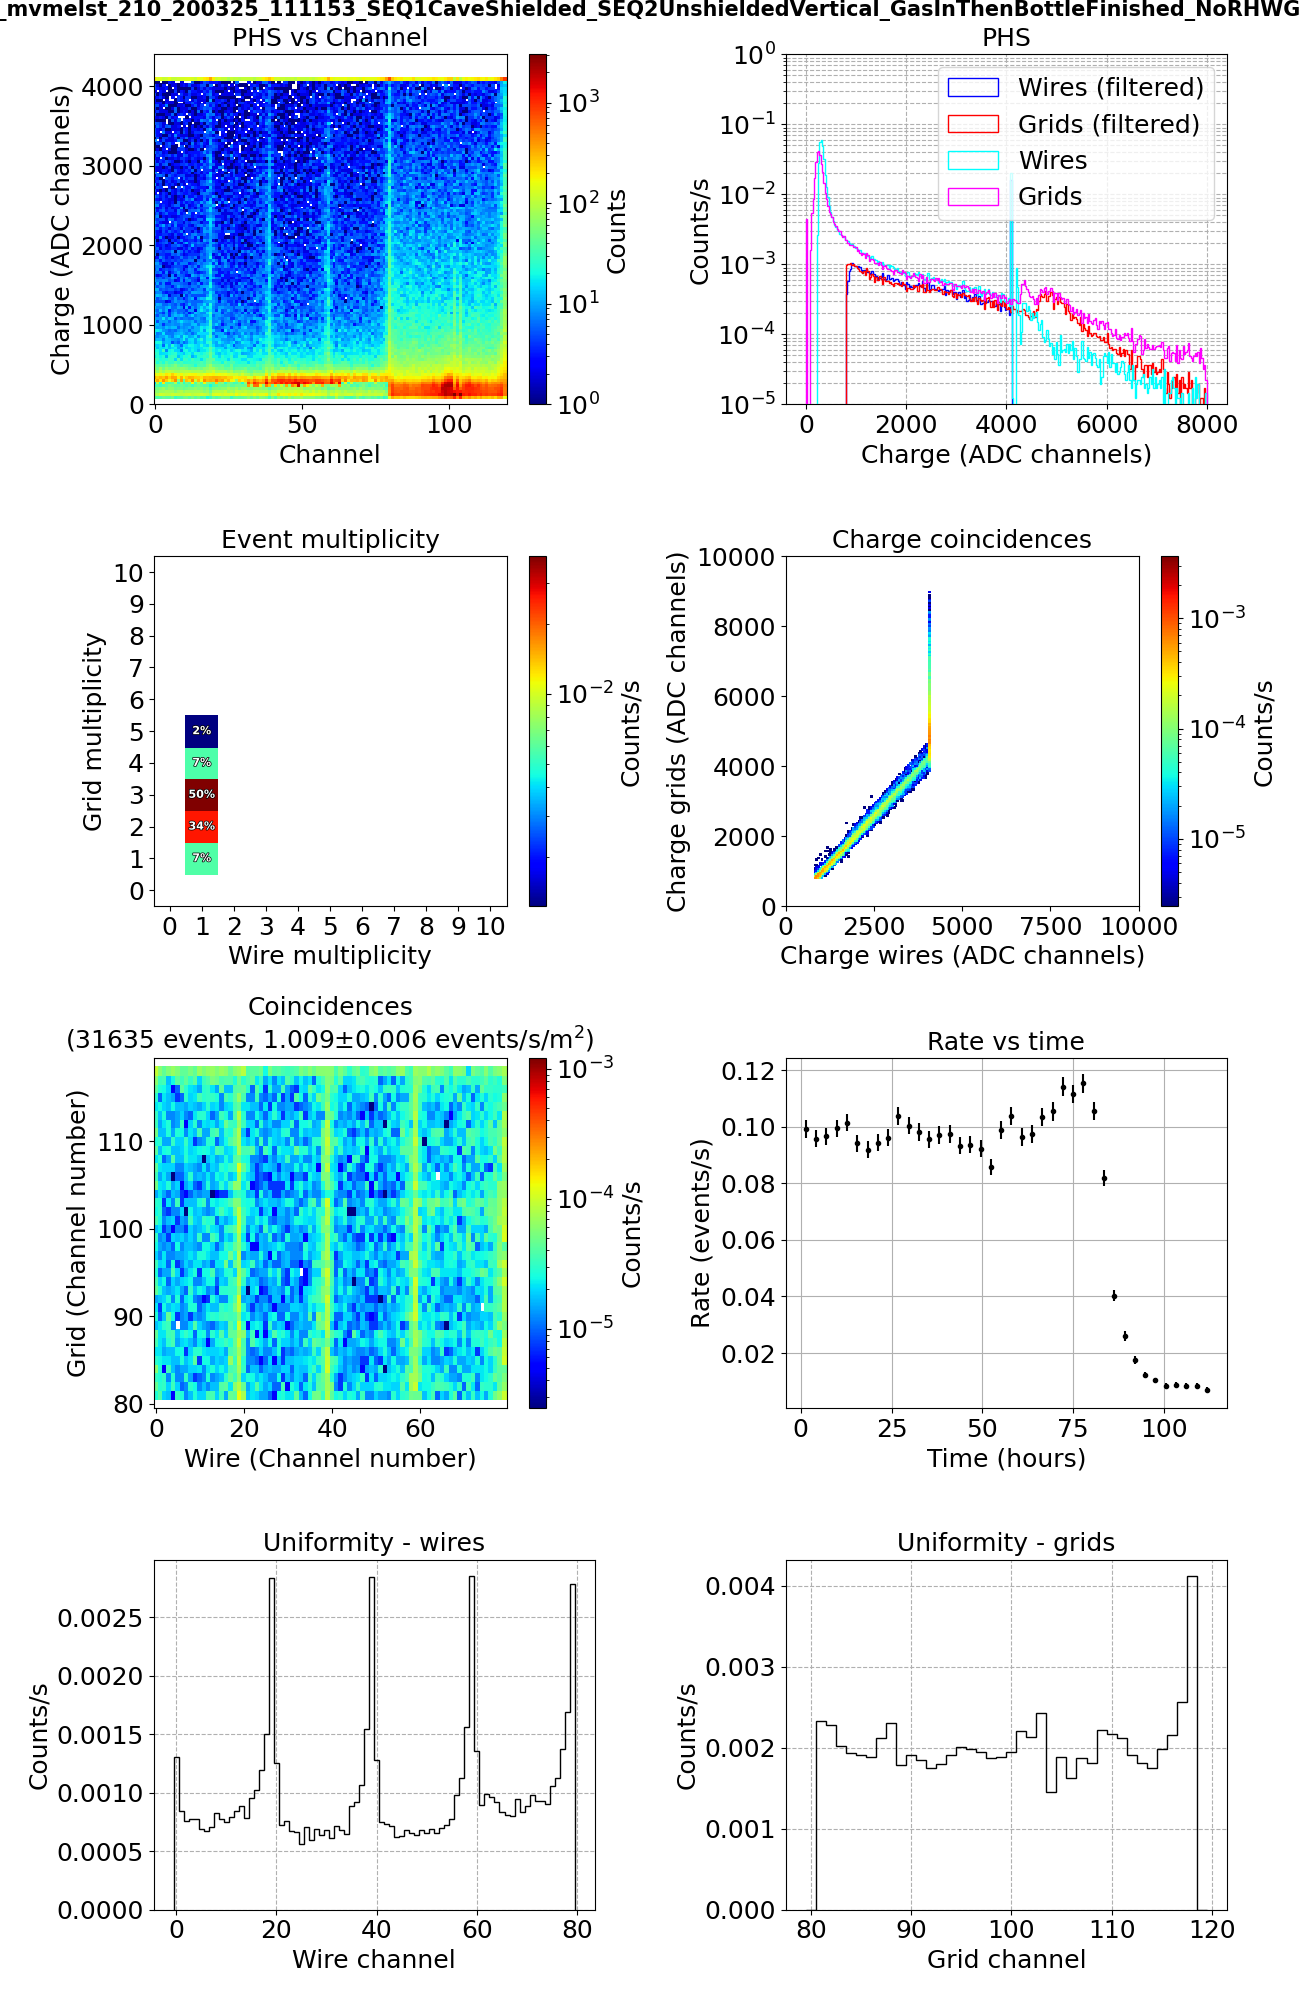

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


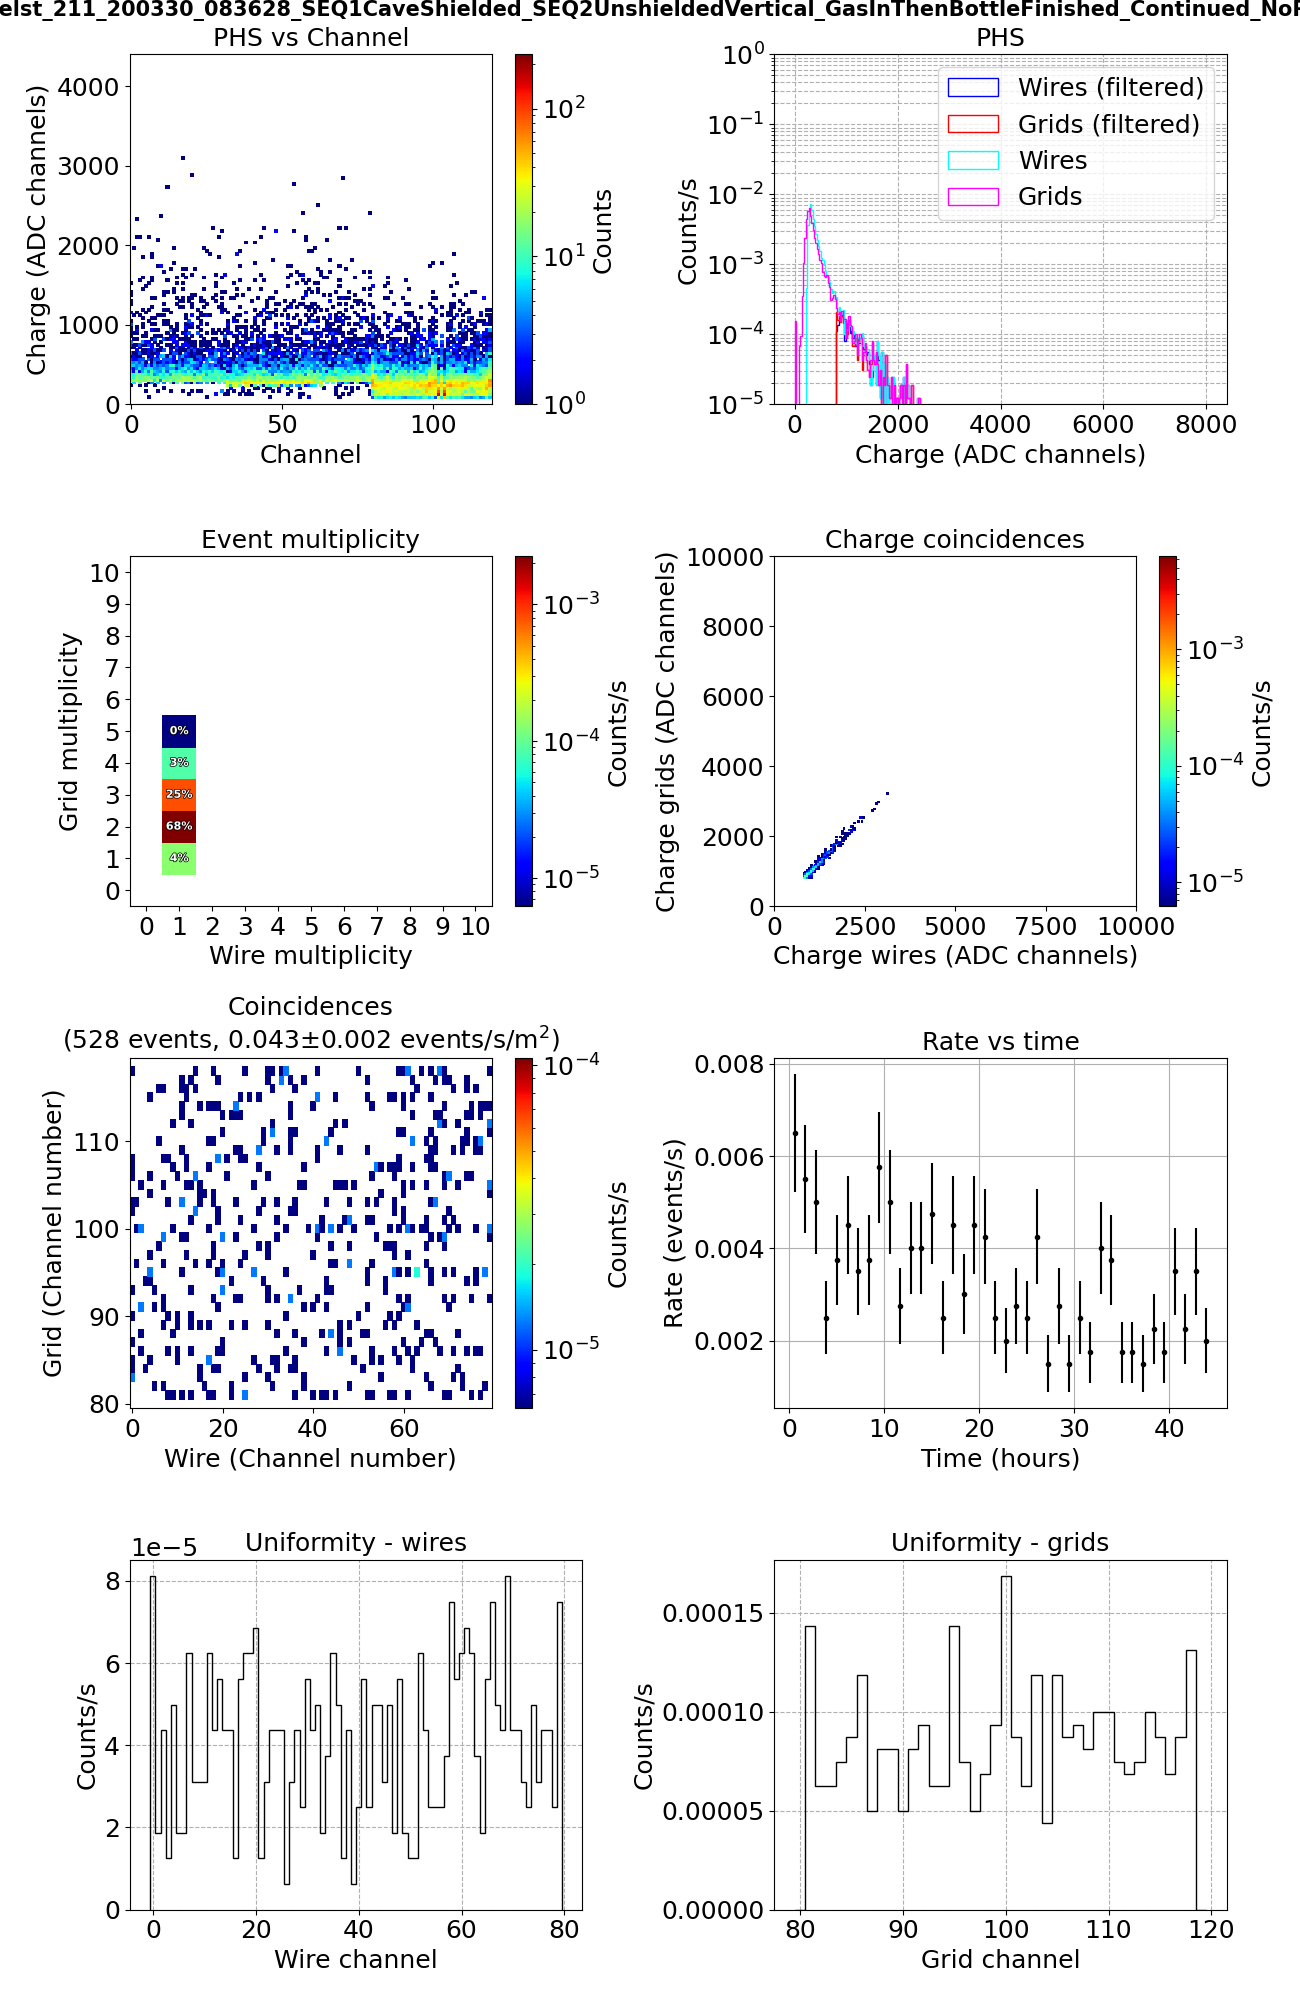

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


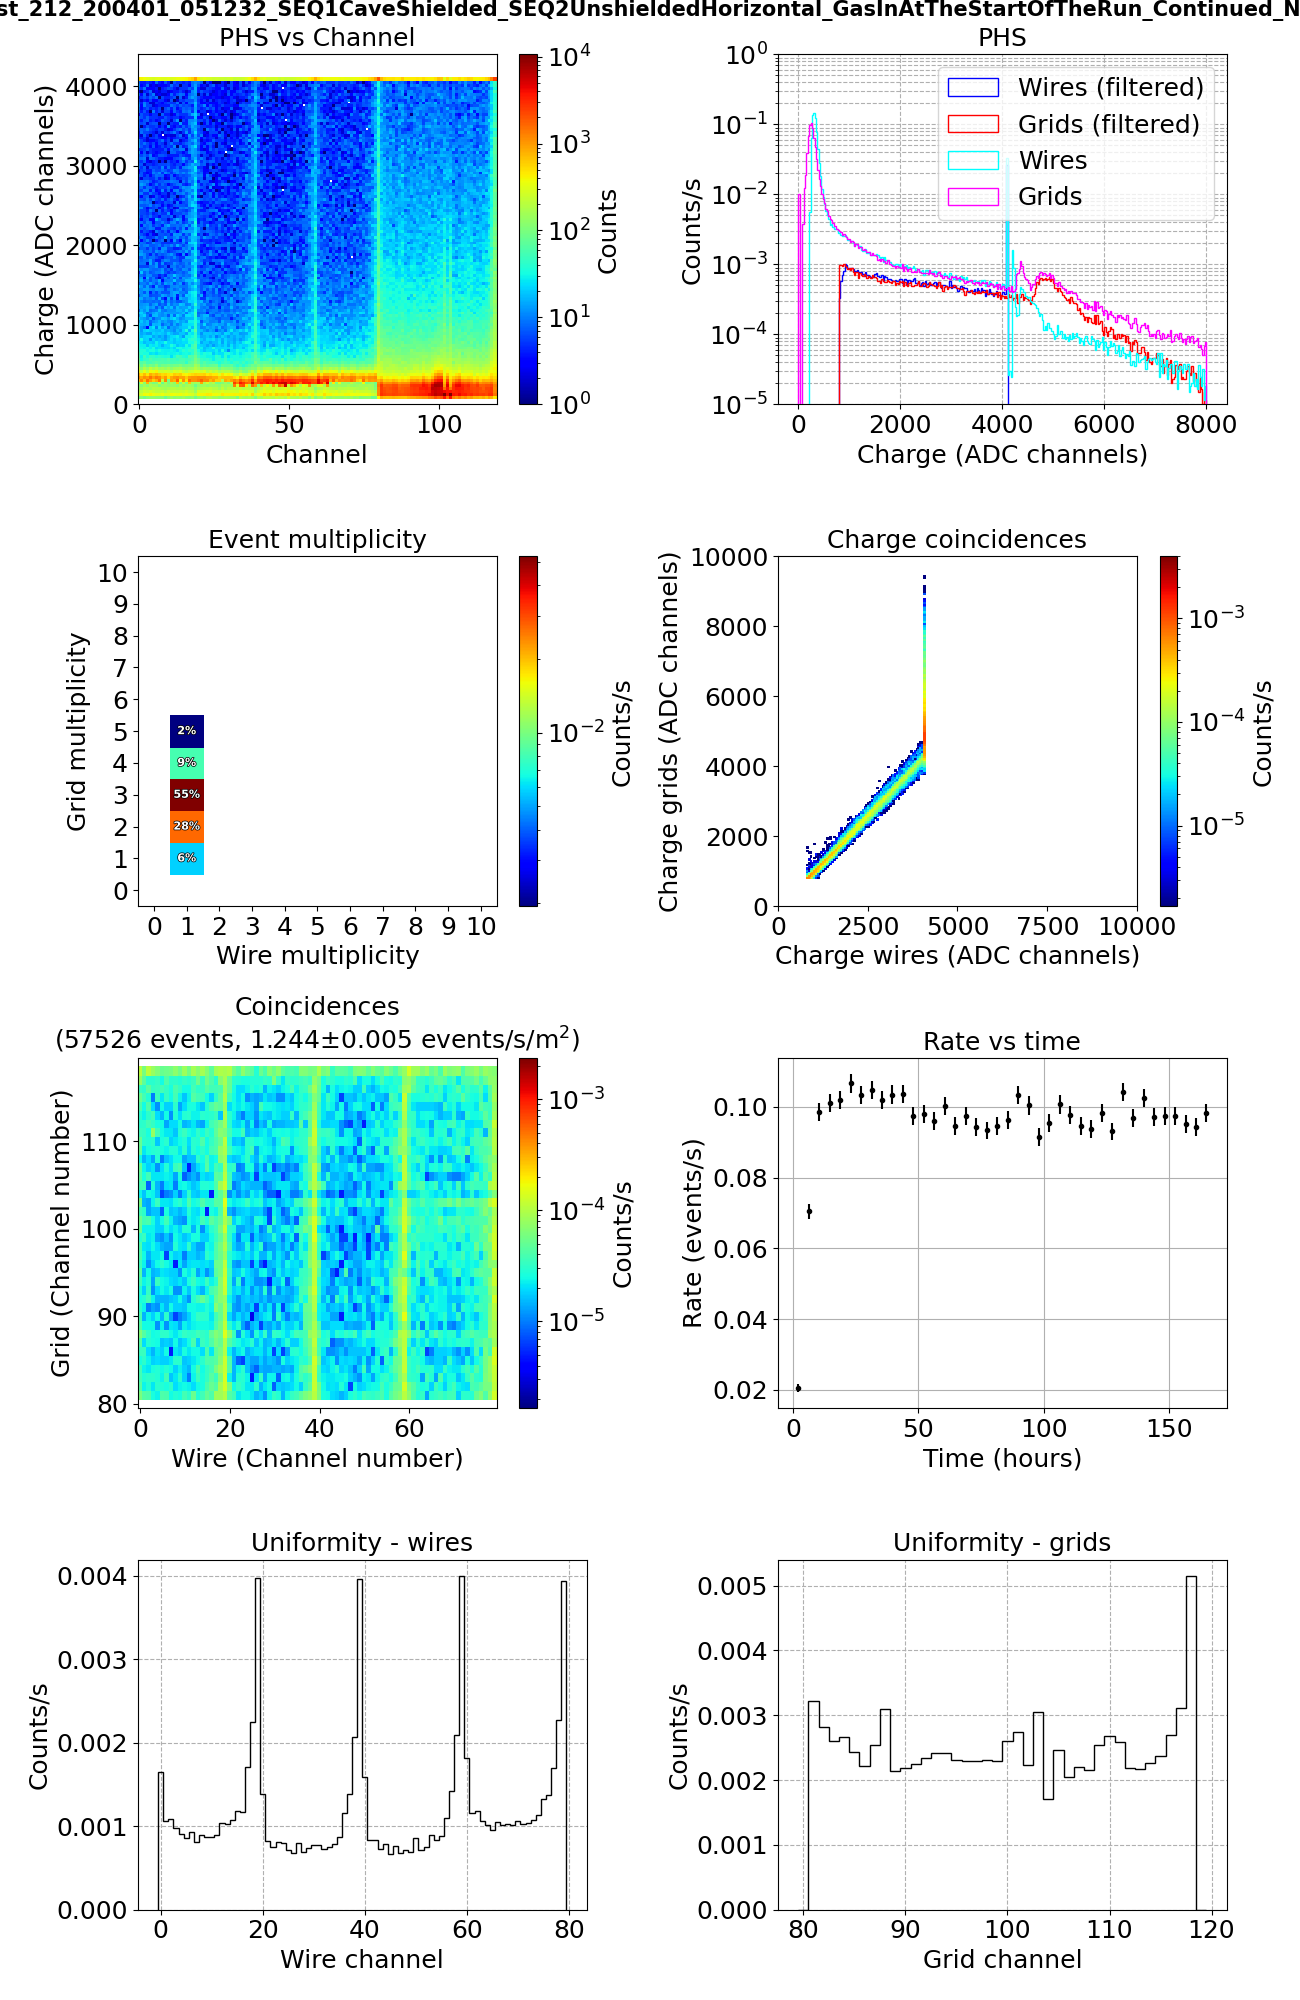

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



<IPython.core.display.Javascript object>


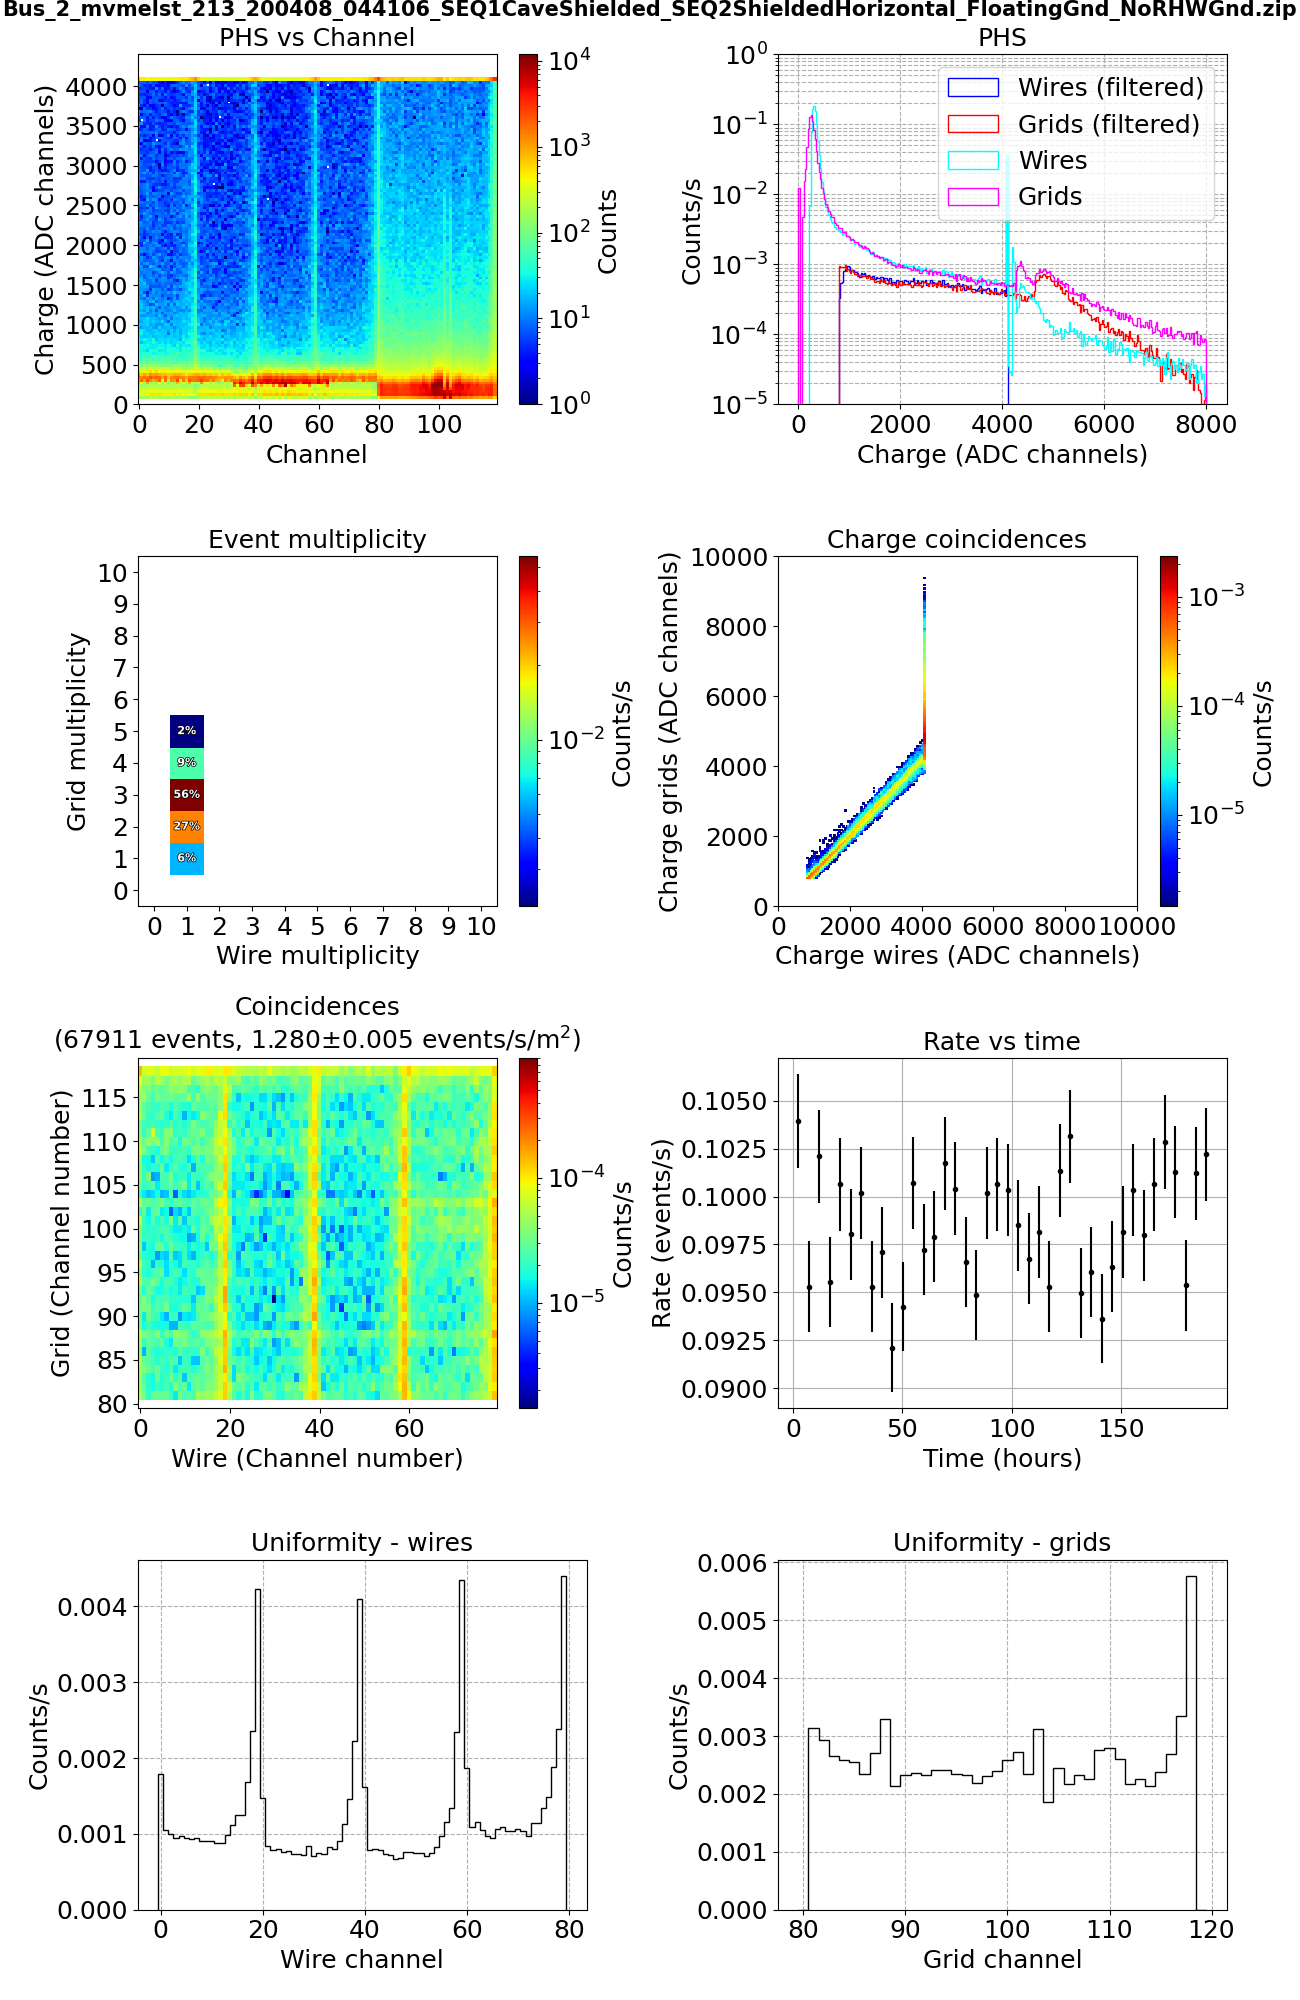

/Users/alexanderbackis/Documents/mg_analysis_notebook/scripts/mg_let/basic_plot.py:391: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



In [13]:
mg_filter_utgard = {'wm': [1, 1, True],                  # Wire multiplicity
                    'gm': [1, 5, True],                  # Grid multiplicity
                    'wadc': [800, np.inf, True],         # Wire charge
                    'gadc': [800, np.inf, True],         # Grid charge
                    'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                    'time': [0, np.inf, False],           # Time (TDC channels)
                    'bus': [0, 8, False],                 # Bus
                    'flag': [0, 1, False],                # =1 if different buses within same coincidence
                    'layer': [0, 19, False],              # Layer, front=0 to back=19
                    'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                    'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     

area_utgard = 0.0225*0.0225*4*38

UTGARD_DATA = np.array(
               [[clu_utgard_run_1, ev_utgard_run_1, 'mvmelst_191_200305_111506_utgard_first_run.zip'],
               [clu_utgard_run_2, ev_utgard_run_2, 'mvmelst_193_200306_040827_mirrobor_covering_front_and_sides.zip'],
               [clu_utgard_run_3, ev_utgard_run_3, 'mvmelst_194_200307_102939_unshielded.zip'],
               [clu_utgard_run_4, ev_utgard_run_4, 'mvmelst_195_200309_033822_mirrorbor_shielding_opening_in_middle.zip'],
               [clu_utgard_run_5, ev_utgard_run_5, 'mvmelst_196_200311_121940_mirrorbor_shielding_opening_at_top.zip'],
               [clu_utgard_run_6, ev_utgard_run_6, 'mvmelst_197_200312_045631_unshielded_first_t0_test.zip'],
               [clu_utgard_run_7, ev_utgard_run_7, 'mvmelst_198_200312_075113_unshielded_second_t0_test.zip'],
               [clu_utgard_run_8, ev_utgard_run_8, 'mvmelst_199_200312_084636_unshielded_no_t0_signals_sent.zip'],
               [clu_utgard_run_9, ev_utgard_run_9, 'mvmelst_200_200312_103913_unshielded_LVgournding_to_be_changed.zip'],
               [clu_utgard_run_10, ev_utgard_run_10,'mvmelst_201_200312_123407_unshielded_RWLVGndC_no_t0.zip'],
               [clu_utgard_run_11, ev_utgard_run_11, 'mvmelst_202_200313_135642_SEQ_1_shielded_in_cave.zip'],
               [clu_utgard_run_12, ev_utgard_run_12, 'mvmelst_203_200316_052259_SEQ1_shielded_in_cave_SEQ2VerticalShielded.zip'],
               [clu_utgard_run_13, ev_utgard_run_13, 'mvmelst_204_200317_133017_SEQ1CaveShielded_SEQ2UnshieldedVertical_NewHV_NORHWGnd.zip'],
               [clu_utgard_run_14, ev_utgard_run_14, 'mvmelst_205_200318_102317_SEQ1CaveShielded_SEQ2UnshieldedVertical_NORHWGnd_GasFlowReducedThenStopped.zip'],
               [clu_utgard_run_15, ev_utgard_run_15, 'mvmelst_206_200323_050803_SEQ1CaveShielded_SEQ2UnshieldedVertical_NoRHWGnd_GasFlowResumed.zip'],
               [clu_utgard_run_16, ev_utgard_run_16, 'mvmelst_207_200324_054624EQ1CaveShieldedwithGas_SEQ2UnshieldedVerticalTopHatOpen_NoRHWGnd_.zip'],
               [clu_utgard_run_17, ev_utgard_run_17, 'mvmelst_210_200325_111153_SEQ1CaveShielded_SEQ2UnshieldedVertical_GasInThenBottleFinished_NoRHWGnd.zip'],
               [clu_utgard_run_18, ev_utgard_run_18, 'mvmelst_211_200330_083628_SEQ1CaveShielded_SEQ2UnshieldedVertical_GasInThenBottleFinished_Continued_NoRHWGnd.zip'],
               [clu_utgard_run_19, ev_utgard_run_19, 'mvmelst_212_200401_051232_SEQ1CaveShielded_SEQ2UnshieldedHorizontal_GasInAtTheStartOfTheRun_Continued_NoRHWGnd.zip'],
               [clu_utgard_run_20, ev_utgard_run_20, 'mvmelst_213_200408_044106_SEQ1CaveShielded_SEQ2ShieldedHorizontal_FloatingGnd_NoRHWGnd.zip'],
               [clu_utgard_run_21, ev_utgard_run_21, 'mvmelst_229_200902_110641_1stRunSep2020-MGSEQ1inCave_MGSEQ2B4CShielded.zip'],
               [clu_utgard_run_22, ev_utgard_run_22, 'mvmelst_214_200902_051721.zip'],
               [clu_utgard_run_23, ev_utgard_run_23, 'mvmelst_231_200911_051736_3RunSep2020-MGSEQ1CaveShielded_MGSEQ2B4CSielded_cardUnplugedPluged_CrateGround.zip'],
               [clu_utgard_run_24, ev_utgard_run_24, 'mvmelst_232_200918_111747_4RunSep2020-MGSEQ1CaveShielded_MGSEQ2B4CShielded_FloatingGnd.zip'],
               [clu_utgard_run_25, ev_utgard_run_25, 'mvmelst_233_200923_105950-MGSEQ1undertableSomeB4C_MGSEQ2B4CShielded_floatingGnd.zip'],
               [clu_utgard_run_26, ev_utgard_run_26, 'mvmelst_265_201210_120808.zip'],
               [clu_utgard_run_27, ev_utgard_run_27, 'bgUtgard_GasFlowStopped_mvmelst_266_201211_084940.zip'],
               [clu_utgard_run_28, ev_utgard_run_28, 'bgUtgard_GasFlowResumed_mvmelst_267_201214_080608.zip'],
               [clu_utgard_run_29, ev_utgard_run_29, 'bgUtgard_LongRun_mvmelst_267_201216_080826.zip'],
               [clu_utgard_run_30, ev_utgard_run_30, 'XmasHolidayLongRun_mvmelst_269_201223_092541.zip'],
               [clu_utgard_run_31, ev_utgard_run_31, 'bgUtgard_LongRun_NewB4CVessel_mvmelst_271_210121_131744.zip'],
               [clu_utgard_run_32, ev_utgard_run_32, 'bgUtgard_NewB4Vessel_GasFlowFixed_mvmelst_273_210128_112409.zip'],
               [clu_utgard_run_33, ev_utgard_run_33, 'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip'],
               [clu_utgard_run_34, ev_utgard_run_34, 'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip'],
               [clu_utgard_run_35, ev_utgard_run_35, 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip'],
               [clu_utgard_run_36, ev_utgard_run_36, 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_279_210211_153557.zip'],
               [clu_utgard_run_37, ev_utgard_run_37, 'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_281_210219_155146.zip'],
               [clu_utgard_run_38, ev_utgard_run_38, 'bgUtgard_NewB4CVessel_GasFlowFixed_Transformer.zip'],
               [clu_utgard_run_39, ev_utgard_run_39, 'bgUtgard_NewB4CVessel_GasFlowFixed_Transformer_mvmelst_284_210312_154900.zip'],
               [clu_utgard_run_40, ev_utgard_run_40, 'mvmelst_177_191115_095131_SEQUOIA__II_15_11_2019_to_18_11_2019_mirrorbor_covering_detector_front.zip'],
               [clu_utgard_run_41, ev_utgard_run_41, 'mvmelst_179_191118_065800_SEQUOIA_II_18_11_2019_to_20_11_2019_no_mirrorbor_shielding.zip'],
               [clu_utgard_run_42, ev_utgard_run_42, 'mvmelst_181_191120_100402_SEQUOIA__II_20_11_2019_to_22_11_2019_mirrorbor_shielding_top_and_bottom.zip'],
               [clu_utgard_run_43, ev_utgard_run_43, 'mvmelst_182_191122_102541_SEQUOIA_II_22_11_2019_to_25_11_2019_mirrorbor_shielding_top_and_bottom_setup_2.zip'],
               [clu_utgard_run_44, ev_utgard_run_44, 'mvmelst_184_191125_054759_SEQUOIA_II_tried_switching_card_3h.zip'],
               [clu_utgard_run_45, ev_utgard_run_45, 'mvmelst_185_191125_091109_SEQUOIA_II_25_11_2019_to_29_11_2019_mirrorbor_shielding_top_and_bottom_setup_2_attempt_2.zip'],
               [clu_utgard_run_46, ev_utgard_run_46, 'mvmelst_186_191129_093348_SEQUOIA_II_raised_voltage_1450V_20_min_test.zip'],
               [clu_utgard_run_47, ev_utgard_run_47, 'mvmelst_187_191129_100050_SEQUOIA_II_1300_V_29_11_2019_to_02_12_2019_mirrorbor_shielding_top_and_bottom_setup_2_no_shielding_on_sequoia_II.zip'],
               [clu_utgard_run_48, ev_utgard_run_48, 'mvmelst_188_191203_101632_SEQUOIA_II_1350_V_03_12_2019_to_05_12_2019_SEQUOIA_II_shielded_with_polyethylene_and_mirrorbor_sides_and_front.zip'],
               [clu_utgard_run_49, ev_utgard_run_49, 'mvmelst_189_191205_093810_SEQUOIA_I_06_12_2019_to_09_12_2019_inside_new_cave.zip'],
               [clu_utgard_run_50, ev_utgard_run_50, 'bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_285_210319_162850.zip'],
               [clu_utgard_run_51, ev_utgard_run_51, 'bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip']
               ])

#indices = np.array([1, 2, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
#                    21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]) - 1
#indices = np.array([1]) #np.arange(11, 21, 1) - 1
#indices = np.array([2, 3, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25]) - 1 
#indices = np.array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]) - 1
#indices = np.array([32, 33, 34, 35, 36, 37, 38, 39]) - 1
#indices = np.array([50, 51]) - 1
indices = np.arange(11, 21, 1) - 1
bus_utgard = 2
for i, data_set in enumerate(UTGARD_DATA[indices]):
    clusters, events, title = data_set
    #mg_plot_basic(title, clusters, events, mg_filter_utgard, 0, 5, 2, area_utgard)
    mg_plot_basic_bus('Bus_%d_' % bus_utgard + title[:-4], bus_utgard, clusters, events, mg_filter_utgard, area_utgard, 'Bus_%d_' % bus_utgard + title)
    #mg_compare_phs(title, [0, 1], ['MG.SEQ.I', 'MG.SEQ.II'], clusters, mg_filter_utgard)

### Plot individual data sets  

<IPython.core.display.Javascript object>


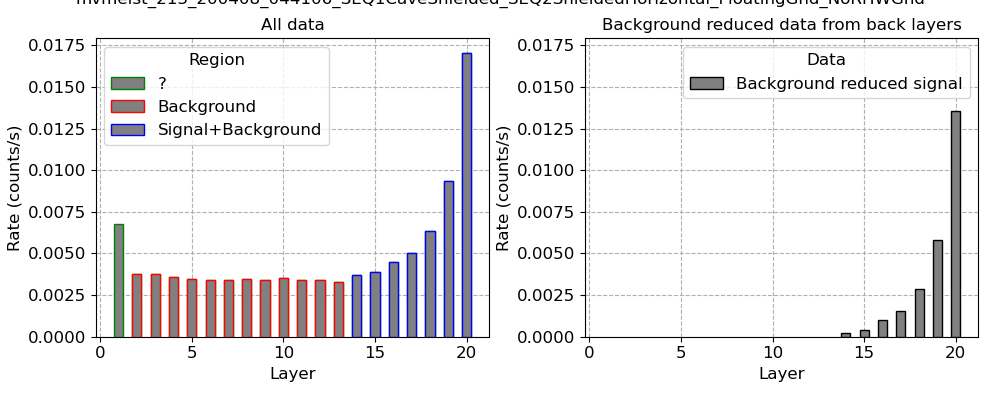

In [77]:
###########################################
## INVESTIGATION OF SIGNAL FROM THE BACK ##
###########################################


'''
File: mvmelst_213_200408_044106_SEQ1CaveShielded_SEQ2ShieldedHorizontal_FloatingGnd_NoRHWGnd.zip

Description: SEQ.I shielded inside of cave, we will only be looking at bus 2

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [2, 2, True],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 2
title = 'mvmelst_213_200408_044106_SEQ1CaveShielded_SEQ2ShieldedHorizontal_FloatingGnd_NoRHWGnd'
mg_hist_side(title,clu_utgard_run_20, mg_filter)

#mg_plot_basic_bus('utgard_run_20', bus, clu_utgard_run_20, ev_utgard_run_20, mg_filter, area, title)

In [ ]:
'''
File: 

Description:  

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [20*MG_H_TO_TDC, 30*MG_H_TO_TDC, True],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'mvmelst_193_200306_040827_mirrobor_covering_front_and_sides.zip '
mg_plot_basic_bus('utgard_run_2', bus, clu_utgard_run_2, ev_utgard_run_2, mg_filter, area, title)

In [ ]:
'''
File: mvmelst_233_200923_105950-MGSEQ1undertableSomeB4C_MGSEQ2B4CShielded_floatingGnd.zip

Description: MG.SEQ.I positioned under table, MG.SEQ.II shielded with B4C. 

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [0, np.inf, False],         # Wire charge
             'gadc': [0, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [80, 119, False]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*40
bus = 0
title = 'mvmelst_233_200923_105950-MGSEQ1undertableSomeB4C_MGSEQ2B4CShielded_floatingGnd.zip'
mg_plot_basic_bus('utgard_run_25', bus, clu_utgard_run_25, ev_utgard_run_25, mg_filter, area, title)

In [ ]:
'''
File: mvmelst_265_201210_120808.zip

Description: First test with MG.LET after LET tests.

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'mvmelst_265_201210_120808.zip'
mg_plot_basic_bus('utgard_run_26', bus, clu_utgard_run_26, ev_utgard_run_26, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_GasFlowStopped_mvmelst_266_201211_084940.zip

Description:

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'bgUtgard_GasFlowStopped_mvmelst_266_201211_084940.zip'
mg_plot_basic_bus('utgard_run_27', bus, clu_utgard_run_27, ev_utgard_run_27, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_GasFlowResumed_mvmelst_267_201214_080608.zip

Description:

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'bgUtgard_GasFlowResumed_mvmelst_267_201214_080608.zip'
mg_plot_basic_bus('utgard_run_28', bus, clu_utgard_run_28, ev_utgard_run_28, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_LongRun_mvmelst_267_201216_080826.zip

Description: 

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'bgUtgard_LongRun_mvmelst_267_201216_080826.zip'
mg_plot_basic_bus('utgard_run_29', bus, clu_utgard_run_29, ev_utgard_run_29, mg_filter, area, title)

In [ ]:
'''
File: XmasHolidayLongRun_mvmelst_269_201223_092541.zip

Description: First test with MG.LET after LET tests.

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'XmasHolidayLongRun_mvmelst_269_201223_092541.zip'
mg_plot_basic_bus('utgard_run_30', bus, clu_utgard_run_30, ev_utgard_run_30, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_LongRun_NewB4CVessel_mvmelst_271_210121_131744.zip

Description:

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 1
title = 'Bus 1 (filters ON): bgUtgard_LongRun_NewB4CVessel_mvmelst_271_210121_131744.zip'
mg_plot_basic_bus('utgard_run_31', bus, clu_utgard_run_31, ev_utgard_run_31, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4Vessel_GasFlowFixed_mvmelst_273_210128_112409.zip

Description:

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 1
title = 'Bus 1 (filters ON): bgUtgard_NewB4Vessel_GasFlowFixed_mvmelst_273_210128_112409.zip'
mg_plot_basic_bus('utgard_run_32', bus, clu_utgard_run_32, ev_utgard_run_32, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip

Description:

'''

mg_filter = {'wm': [1, 1, False],                  # Wire multiplicity
             'gm': [1, 5, False],                  # Grid multiplicity
             'wadc': [800, np.inf, False],         # Wire charge
             'gadc': [800, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*40
bus = 1
title = 'Bus 1 (filters OFF): bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip'
mg_plot_basic_bus('filters_off_utgard_run_33', bus, clu_utgard_run_33, ev_utgard_run_33, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip

Description:

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 1
title = 'Bus 1 (filters ON): bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip'
mg_plot_basic_bus('filters_on_utgard_run_34', bus, clu_utgard_run_34, ev_utgard_run_34, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel

'''

mg_filter = {'wm': [1, 1, False],                  # Wire multiplicity
             'gm': [1, 5, False],                  # Grid multiplicity
             'wadc': [800, np.inf, False],         # Wire charge
             'gadc': [800, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*40
bus = 1
title = 'Bus 1 (filters OFF): bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip'
mg_plot_basic_bus('filters_off_utgard_run_35', bus, clu_utgard_run_35, ev_utgard_run_35, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_279_210211_153557.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel, cards swapped.

'''

mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     
area = 0.0225*0.0225*4*38
bus = 0
title = 'Bus 0 (filters ON): bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_279_210211_153557.zip'
mg_plot_basic_bus('filters_on_utgard_run_36', bus, clu_utgard_run_36, ev_utgard_run_36, mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_281_210219_155146.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel. Same as setup as last run.

'''

mg_filter_on = {'wm': [1, 1, True],                  # Wire multiplicity
                'gm': [1, 5, True],                  # Grid multiplicity
                'wadc': [800, np.inf, True],         # Wire charge
                'gadc': [800, np.inf, True],         # Grid charge
                'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                'time': [0, np.inf, False],           # Time (TDC channels)
                'bus': [0, 8, False],                 # Bus
                'flag': [0, 1, False],                # =1 if different buses within same coincidence
                'layer': [0, 19, False],              # Layer, front=0 to back=19
                'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     

mg_filter_off = {'wm': [1, 1, False],                  # Wire multiplicity
                 'gm': [1, 5, False],                  # Grid multiplicity
                 'wadc': [800, np.inf, False],         # Wire charge
                 'gadc': [800, np.inf, False],         # Grid charge
                 'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                 'time': [0, np.inf, False],           # Time (TDC channels)
                 'bus': [0, 8, False],                 # Bus
                 'flag': [0, 1, False],                # =1 if different buses within same coincidence
                 'layer': [0, 19, False],              # Layer, front=0 to back=19
                 'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                 'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119    

area_filters_on = 0.0225*0.0225*4*38
area_filters_off = 0.0225*0.0225*4*40

# Go through all permutations
areas = [area_filters_on, area_filters_off]
mg_filters = [mg_filter_on, mg_filter_off]
on_or_off_vec = ['on', 'off']
buses = [0, 1]
for area, mg_filter, on_or_off in zip(areas, mg_filters, on_or_off_vec):
    for bus in buses:
        title = 'Bus %d (filters %s): bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_281_210219_155146.zip' % (bus, on_or_off)
        mg_plot_basic_bus('filters_%s_utgard_run_37' % on_or_off, bus, clu_utgard_run_37, ev_utgard_run_37,
                          mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_Transformer.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel. Transformer have been applied.

'''

mg_filter_on = {'wm': [1, 1, True],                  # Wire multiplicity
                'gm': [1, 5, True],                  # Grid multiplicity
                'wadc': [800, np.inf, True],         # Wire charge
                'gadc': [800, np.inf, True],         # Grid charge
                'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                'time': [0, np.inf, False],           # Time (TDC channels)
                'bus': [0, 8, False],                 # Bus
                'flag': [0, 1, False],                # =1 if different buses within same coincidence
                'layer': [0, 19, False],              # Layer, front=0 to back=19
                'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119     

mg_filter_off = {'wm': [1, 1, False],                  # Wire multiplicity
                 'gm': [1, 5, False],                  # Grid multiplicity
                 'wadc': [800, np.inf, False],         # Wire charge
                 'gadc': [800, np.inf, False],         # Grid charge
                 'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                 'time': [0, np.inf, False],           # Time (TDC channels)
                 'bus': [0, 8, False],                 # Bus
                 'flag': [0, 1, False],                # =1 if different buses within same coincidence
                 'layer': [0, 19, False],              # Layer, front=0 to back=19
                 'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                 'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119    

area_filters_on = 0.0225*0.0225*4*38
area_filters_off = 0.0225*0.0225*4*40

# Go through all permutations
areas = [area_filters_on, area_filters_off]
mg_filters = [mg_filter_on, mg_filter_off]
on_or_off_vec = ['on', 'off']
buses = [0, 1]
for area, mg_filter, on_or_off in zip(areas, mg_filters, on_or_off_vec):
    for bus in buses:
        title = 'Bus %d (filters %s): bgUtgard_NewB4CVessel_GasFlowFixed_Transformer.zip' % (bus, on_or_off)
        mg_plot_basic_bus('filters_%s_utgard_run_38' % on_or_off, bus, clu_utgard_run_38, ev_utgard_run_38,
                          mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_GasFlowFixed_Transformer_mvmelst_284_210312_154900.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel. Transformer have been applied.

'''

mg_filter_on = {'wm': [1, 1, True],                   # Wire multiplicity
                'gm': [1, 5, True],                   # Grid multiplicity
                'wadc': [800, np.inf, True],          # Wire charge
                'gadc': [800, np.inf, True],          # Grid charge
                'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                'time': [0, np.inf, False],           # Time (TDC channels)
                'bus': [0, 8, False],                 # Bus
                'flag': [0, 1, False],                # =1 if different buses within same coincidence
                'layer': [0, 19, False],              # Layer, front=0 to back=19
                'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                'gch': [81, 118, True]}               # Grid channel, bottom=80 to top=119     

mg_filter_off = {'wm': [1, 1, False],                  # Wire multiplicity
                 'gm': [1, 5, False],                  # Grid multiplicity
                 'wadc': [800, np.inf, False],         # Wire charge
                 'gadc': [800, np.inf, False],         # Grid charge
                 'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                 'time': [0, np.inf, False],           # Time (TDC channels)
                 'bus': [0, 8, False],                 # Bus
                 'flag': [0, 1, False],                # =1 if different buses within same coincidence
                 'layer': [0, 19, False],              # Layer, front=0 to back=19
                 'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                 'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119    

area_filters_on = 0.0225*0.0225*4*38
area_filters_off = 0.0225*0.0225*4*40

# Go through all permutations
areas = [area_filters_on, area_filters_off]
mg_filters = [mg_filter_on, mg_filter_off]
on_or_off_vec = ['on', 'off']
buses = [0, 1]
for area, mg_filter, on_or_off in zip(areas, mg_filters, on_or_off_vec):
    for bus in buses:
        title = 'Bus %d (filters %s): bgUtgard_NewB4CVessel_GasFlowFixed_Transformer_mvmelst_284_210312_154900.zip' % (bus, on_or_off)
        mg_plot_basic_bus('filters_%s_utgard_run_39' % on_or_off, bus, clu_utgard_run_39, ev_utgard_run_39,
                          mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_285_210319_162850.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel. Transformer have been applied.
             HV-connection fixed.

'''

mg_filter_on = {'wm': [1, 1, True],                   # Wire multiplicity
                'gm': [1, 5, True],                   # Grid multiplicity
                'wadc': [800, np.inf, True],          # Wire charge
                'gadc': [800, np.inf, True],          # Grid charge
                'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                'time': [0, np.inf, False],           # Time (TDC channels)
                'bus': [0, 8, False],                 # Bus
                'flag': [0, 1, False],                # =1 if different buses within same coincidence
                'layer': [0, 19, False],              # Layer, front=0 to back=19
                'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                'gch': [81, 118, True]}               # Grid channel, bottom=80 to top=119     

mg_filter_off = {'wm': [1, 1, False],                  # Wire multiplicity
                 'gm': [1, 5, False],                  # Grid multiplicity
                 'wadc': [800, np.inf, False],         # Wire charge
                 'gadc': [800, np.inf, False],         # Grid charge
                 'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                 'time': [0, np.inf, False],           # Time (TDC channels)
                 'bus': [0, 8, False],                 # Bus
                 'flag': [0, 1, False],                # =1 if different buses within same coincidence
                 'layer': [0, 19, False],              # Layer, front=0 to back=19
                 'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                 'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119    

area_filters_on = 0.0225*0.0225*4*38
area_filters_off = 0.0225*0.0225*4*40

# Go through all permutations
areas = [area_filters_on, area_filters_off]
mg_filters = [mg_filter_on, mg_filter_off]
on_or_off_vec = ['on', 'off']
buses = [0, 1]
for area, mg_filter, on_or_off in zip(areas, mg_filters, on_or_off_vec):
    for bus in buses:
        title = 'Bus %d (filters %s): bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_285_210319_162850.zip' % (bus, on_or_off)
        mg_plot_basic_bus('filters_%s_utgard_run_50' % on_or_off, bus, clu_utgard_run_50, ev_utgard_run_50,
                          mg_filter, area, title)

In [ ]:
'''
File: bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip

Description: Both SEQ.I (bus 1) and SEQ.II (bus 0) in the same vessel. Same setup as previous measurement.

'''

mg_filter_on = {'wm': [1, 1, True],                   # Wire multiplicity
                'gm': [1, 5, True],                   # Grid multiplicity
                'wadc': [800, np.inf, True],          # Wire charge
                'gadc': [800, np.inf, True],          # Grid charge
                'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                'time': [0, np.inf, False],           # Time (TDC channels)
                'bus': [0, 8, False],                 # Bus
                'flag': [0, 1, False],                # =1 if different buses within same coincidence
                'layer': [0, 19, False],              # Layer, front=0 to back=19
                'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                'gch': [81, 118, True]}               # Grid channel, bottom=80 to top=119     

mg_filter_off = {'wm': [1, 1, False],                  # Wire multiplicity
                 'gm': [1, 5, False],                  # Grid multiplicity
                 'wadc': [800, np.inf, False],         # Wire charge
                 'gadc': [800, np.inf, False],         # Grid charge
                 'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
                 'time': [0, np.inf, False],           # Time (TDC channels)
                 'bus': [0, 8, False],                 # Bus
                 'flag': [0, 1, False],                # =1 if different buses within same coincidence
                 'layer': [0, 19, False],              # Layer, front=0 to back=19
                 'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                 'gch': [81, 118, False]}              # Grid channel, bottom=80 to top=119    

area_filters_on = 0.0225*0.0225*4*38
area_filters_off = 0.0225*0.0225*4*40

# Go through all permutations
areas = [area_filters_on, area_filters_off]
mg_filters = [mg_filter_on, mg_filter_off]
on_or_off_vec = ['on', 'off']
buses = [0, 1]
for area, mg_filter, on_or_off in zip(areas, mg_filters, on_or_off_vec):
    for bus in buses:
        title = 'Bus %d (filters %s): bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip' % (bus, on_or_off)
        mg_plot_basic_bus('filters_%s_utgard_run_51' % on_or_off, bus, clu_utgard_run_51, ev_utgard_run_51,
                          mg_filter, area, title)

mg_compare_phs('bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip',
               [0, 1], ['MG.SEQ.I', 'MG.SEQ.II'], clu_utgard_run_51, mg_filter_on)

### Helium-3 data

In [ ]:
# Declare paths
he3_folder = '../data/let_preparations/raw/he3_tube/'
path_he3_30cm3He1200V_86510s_mp = he3_folder + '2020_12_24_3HeBg_Utgard/30cm3He1200V_86510s.mp'
path_he3_30cm_1350_B4CShielded_928527s_mp = he3_folder + '2020_12_24_3HeBg_Utgard/30cm_1350_B4CShielded_928527s.mp'
path_he3_30cm_1350_UnShielded_786511s_mp = he3_folder + '30cm_1350_UnShielded_786511s.mp'
path_he3_TEST_lst = he3_folder + '2020_12_24_3HeBg_Utgard/TEST.lst'
path_he3_30cm3He1300_77042s_lst = he3_folder + '30cm3He1300_77042s.lst'
path_v20_test_data = he3_folder + '2019_09_HZB_He3InBeam54304s_overnight.lst'
path_testData_lst = he3_folder +'testData.lst'
path_30cm3He1300V_UnShielded_336814s_Thrs500mV_lst = he3_folder + '30cm3He1300V_UnShielded_336814s_Thrs500mV.lst'
path_30cm_1300V_Shielded_259741s_Thrs500mV_lst = he3_folder +'30cm_1300V_Shielded_259741s_Thrs500mV.lst'
path_30cm3He1300V_Shielded_520175s_Thrs500mV_lst = he3_folder +'30cm3He1300V_Shielded_520175s_Thrs500mV.lst'
path_30cm3He1300V_Shielded_692630s_lst = he3_folder + '30cm3He1300V_Shielded_692630s.lst'
path_30cm3He1300v_Shielded_1620267s_Thrs500mV_lst = he3_folder + '30cm3He1300v_Shielded_1620267s_Thrs500mV.lst'
path_30cm3He1300V_UnShielded_183989s_Thrs500mV_lst = he3_folder + '30cm3He1300V_UnShielded_183989s_Thrs500mV.lst'
path_30cm3He1300V_UnShielded_516500s_Thr500mV_lst = he3_folder + '30cm3He1300V_UnShielded_516500s_Thr500mV.lst'
path_30cm3He1300V_UnShielded_335049s_Thr500mV_lst = he3_folder + '30cm3He1300V_UnShielded_335049s_Thr500mV.lst'
path_30cm3He1300V_UnShielded_1979600s_Thr500mV_lst = he3_folder + '30cm3He1300V_UnShielded_1979600s_Thr500mV.lst'

# Load '.mp'-data
he3_30cm3He1200V_86510s_mp = np.loadtxt(path_he3_30cm3He1200V_86510s_mp, skiprows=27, dtype=int)
he3_30cm_1350_B4CShielded_928527s_mp = np.loadtxt(path_he3_30cm_1350_B4CShielded_928527s_mp, skiprows=27, dtype=int)
he3_30cm_1350_UnShielded_786511s_mp = np.loadtxt(path_he3_30cm_1350_UnShielded_786511s_mp, skiprows=27, dtype=int)

# Load '.lst'-data
#he3_TEST_lst = he3_mca4_read.extract_binary_events(path_he3_TEST_lst)
#he3_30cm3He1300_77042s_lst = he3_mca4_read.extract_events(path_he3_30cm3He1300_77042s_lst)
#v20_test_data_lst = he3_mca4_read.extract_events(path_v20_test_data)
#he3_testData_df = he3_mca4_read.extract_events(path_testData_lst, TDC_to_time=1e-6)

he3_30cm3He1300V_UnShielded_336814s_Thrs500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_UnShielded_336814s_Thrs500mV_lst,
                                                                                TDC_to_time=1e-3)

he3_30cm_1300V_Shielded_259741s_Thrs500mV_df = he3_mca4_read.extract_events(path_30cm_1300V_Shielded_259741s_Thrs500mV_lst,
                                                                            TDC_to_time=1e-3)

he3_30cm3He1300V_Shielded_520175s_Thrs500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_Shielded_520175s_Thrs500mV_lst,
                                                                              TDC_to_time=1e-3)

he3_30cm3He1300V_Shielded_692630s_df = he3_mca4_read.extract_events(path_30cm3He1300V_Shielded_692630s_lst,
                                                                    TDC_to_time=1e-3)

he3_30cm3He1300v_Shielded_1620267s_Thrs500mV_df = he3_mca4_read.extract_events(path_30cm3He1300v_Shielded_1620267s_Thrs500mV_lst,
                                                                               TDC_to_time=1e-3)

he3_30cm3He1300V_UnShielded_183989s_Thrs500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_UnShielded_183989s_Thrs500mV_lst,
                                                                                TDC_to_time=1e-3)

he3_30cm3He1300V_UnShielded_516500s_Thr500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_UnShielded_516500s_Thr500mV_lst,
                                                                                TDC_to_time=1e-3)

he3_30cm3He1300V_UnShielded_335049s_Thr500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_UnShielded_335049s_Thr500mV_lst,
                                                                                TDC_to_time=1e-3)

he3_30cm3He1300V_UnShielded_1979600s_Thr500mV_df = he3_mca4_read.extract_events(path_30cm3He1300V_UnShielded_1979600s_Thr500mV_lst,
                                                                                TDC_to_time=1e-3)


In [ ]:
save_path = he3_folder + '30cm3He1300_77042s.h5'
he3_mca4_read.save_data(he3_30cm3He1300_77042s_lst, save_path)

In [ ]:
def plot_he3(df, sup_title, he3_filter, adc_bins=100, time_bins=50):
    # Filter data
    df_f = he3_mca4_read.filter_data(df, he3_filter)
    # Plot data
    mg_hf.set_thick_labels(9.5)
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(6)
    plt.suptitle(sup_title, fontsize=15, fontweight='bold', y=1.005)
        
    plt.subplot(2, 2, 2)
    plt.title('Rate vs Time')
    # Prepare histogram
    time = (df.tof)/(60 ** 2)
    hist, bin_edges = np.histogram(time, bins=time_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    delta_t = (60 ** 2) * (bin_centers[1] - bin_centers[0])
    # Get rate
    number_events = len(df.tof)
    duration = df.tof.values[-1] - df.tof.values[0]
    print(duration)
    he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
    print(he3_area)
    average_rate_per_m2 = number_events/(duration*he3_area)
    average_rate_per_m2_error = np.sqrt(number_events)/(duration*he3_area)
    # Plot
    plt.errorbar(bin_centers, (hist/delta_t), np.sqrt(hist)/delta_t, marker='.', linestyle='',
                 zorder=5, color='blue', label='OFF')
    # Prepare histogram
    time_f = (df_f.tof)/(60 ** 2)
    hist_f, bin_edges_f = np.histogram(time_f, bins=time_bins)
    bin_centers_f = 0.5 * (bin_edges_f[1:] + bin_edges_f[:-1])
    delta_t_f = (60 ** 2) * (bin_centers_f[1] - bin_centers_f[0])
    # Get rate
    number_events_f = len(df_f.tof)
    duration_f = df_f.tof.values[-1] - df_f.tof.values[0]
    print(duration_f)
    average_rate_per_m2_f = number_events_f/(duration_f*he3_area)
    average_rate_per_m2_error_f = np.sqrt(number_events_f)/(duration_f*he3_area)
    #Plot
    plt.errorbar(bin_centers_f, (hist_f/delta_t_f), np.sqrt(hist_f)/delta_t_f, marker='.', linestyle='',
                 zorder=5, color='red', label='ON')
    plt.legend(title='Filter')
    plt.xlabel('Time (hours)')
    plt.ylabel('Rate (Hz)')
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    
    plt.subplot(2, 2, 1)
    plt.title('Channel histogram')
    a_rate = average_rate_per_m2
    a_error = average_rate_per_m2_error
    a_rate_f = average_rate_per_m2_f
    a_error_f = average_rate_per_m2_error_f
    plt.hist(df.ch, histtype='step', color='blue', label='OFF (Rate: %.3f ± %.3f Hz/m$^2$)' % (a_rate, a_error),
             zorder=5, bins=4)
    plt.hist(df_f.ch, histtype='step', color='red', label='ON (Rate: %.3f ± %.3f Hz/m$^2$)' % (a_rate_f, a_error_f),
             zorder=5, bins=4)
    plt.legend(title='Filter')
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.xlim(0, 4)
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    
    plt.subplot(2, 2, 3)
    plt.title('ADC histogram')
    plt.hist(df.adc, histtype='step', color='blue', label='OFF', zorder=5, range=[0, 66000], bins=adc_bins)
    plt.hist(df_f.adc, histtype='step', color='red', label='ON', zorder=5, range=[0, 66000], bins=adc_bins)
    plt.legend(title='Filter')
    plt.xlabel('Charge (ADC channels)')
    plt.ylabel('Counts')
    plt.xlim(0, 80000)
    plt.yscale('log')
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    
    plt.subplot(2, 2, 4)
    plt.title('Pile-up histogram')
    plt.hist(df.pile_up, histtype='step', color='blue', label='OFF', zorder=5)
    plt.hist(df_f.pile_up, histtype='step', color='red', label='ON', zorder=5)
    plt.legend(title='Filter')
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.xlabel('Pile up (0=no, 1=yes)')
    plt.ylabel('Counts')
    plt.xlim(0, 1)

    plt.tight_layout()
    output_path = '../output/%s.png' % sup_title
    fig.savefig(output_path, bbox_inches='tight')

In [ ]:
# Plot '.mp'-data

adc_values = np.arange(0, 4096, 1)
mg_hf.set_thick_labels(12)

fig = plt.figure()
plt.step(adc_values, he3_30cm3He1200V_86510s_mp, color='black')
plt.title('30cm3He1200V_86510s.mp')
plt.yscale('log')
plt.xlabel('Charge (ADC channels)')
plt.ylabel('Counts')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
output_path = '../output/30cm3He1200V_86510s.png'
fig.savefig(output_path, bbox_inches='tight')

fig = plt.figure()
plt.step(adc_values, he3_30cm_1350_B4CShielded_928527s_mp, color='black')
plt.title('he3_30cm_1350_B4CShielded_928527s.mp')
plt.yscale('log')
plt.xlabel('Charge (ADC channels)')
plt.ylabel('Counts')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
output_path = '../output/he3_30cm_1350_B4CShielded_928527s_mp.png'
fig.savefig(output_path, bbox_inches='tight')

fig = plt.figure()
plt.title('he3_30cm_1350_UnShielded_786511s.mp')
plt.step(adc_values, he3_30cm_1350_UnShielded_786511s_mp, color='black')
plt.yscale('log')
plt.xlabel('Charge (ADC channels)')
plt.ylabel('Counts')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
output_path = '../output/he3_30cm_1350_UnShielded_786511s_mp.png'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_UnShielded_336814s_Thrs500mV_df,
         '30cm3He1300V_UnShielded_336814s_Thrs500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
 
# Plot data
plot_he3(he3_30cm_1300V_Shielded_259741s_Thrs500mV_df,
         '30cm_1300V_Shielded_259741s_Thrs500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [0, 11500, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_Shielded_520175s_Thrs500mV_df,
         '30cm3He1300V_Shielded_520175s_Thrs500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_Shielded_692630s_df,
         '30cm3He1300V_Shielded_692630s',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300v_Shielded_1620267s_Thrs500mV_df,
         '30cm3He1300v_Shielded_1620267s_Thrs500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_UnShielded_183989s_Thrs500mV_df,
         '30cm3He1300V_UnShielded_183989s_Thrs500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_UnShielded_516500s_Thr500mV_df,
         '30cm3He1300V_UnShielded_516500s_Thr500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_UnShielded_335049s_Thr500mV_df,
         '30cm3He1300V_UnShielded_335049s_Thr500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
# Declare filter
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 1, False]} # Pile-up
 
# Plot data
plot_he3(he3_30cm3He1300V_UnShielded_1979600s_Thr500mV_df,
         '30cm3He1300V_UnShielded_1979600s_Thr500mV',
         he3_filter,
         adc_bins=200,
         time_bins=30)

In [ ]:
def plot_summer_2019_data():
    # Declare parameters
    folder = '../data/let_preparations/raw/he3_tube/2019_06_25_He3BKGD_Utg/'
    files = np.array([file for file in os.listdir(folder) if file[-3:] == '.mp'])
    durations = [277196, 70711, 334529, 173018, 432801,
                 79048, 277196, 70711, 334529, 173018,
                 432801, 409564, 409564, 61780, 173100, 79048]
    lengths = np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
    areas = (lengths * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
    adc_values = np.arange(0, 4096, 1)
    threshold = 700#673
    # Plot all data
    for file, duration, area in zip(files, durations, areas):
        # Load data
        path = folder + file
        print('File: %s,' % file, 'Duration: %d,' % duration, 'Area: %.5f m$^2$' % area)
        phs_hist = np.loadtxt(path, skiprows=27, dtype=int)
        # Calculate rate
        nf_r = sum(phs_hist)/(duration*area)
        nf_r_error = np.sqrt(sum(phs_hist))/(duration*area)
        f_r = sum(phs_hist[threshold:])/(duration*area)
        f_r_error = np.sqrt(sum(phs_hist[threshold:]))/(duration*area)
        # Plot data
        fig = plt.figure()
        plt.step(adc_values, phs_hist, color='blue',
                 label='Filter OFF (Rate: %.2f ± %.2f Hz/m$^2$)' % (nf_r, nf_r_error))
        plt.step(adc_values[threshold:], phs_hist[threshold:], color='red',
                 label='Filter ON (Rate: %.2f ± %.2f Hz/m$^2$)' % (f_r, f_r_error))
        plt.title('File: %s\nDuration: %d s, Threshold= %d ADC channels' % (file, duration, threshold))
        plt.yscale('log')
        plt.xlabel('Charge (ADC channels)')
        plt.ylabel('Counts')
        plt.legend(title='Label')
        plt.grid(True, which='major', linestyle='--', zorder=0)
        plt.grid(True, which='minor', linestyle='--', zorder=0)
        output_path = '../output/%s.png' % file[:-3]
        fig.savefig(output_path, bbox_inches='tight')
        

plot_summer_2019_data()

### Compare Multi-Grid detector and helium-3 data

In [ ]:
def get_weather_data():
    # Declare paths
    folder = '../data/weather_data/LogFiles/'
    files = np.array([file for file in os.listdir(folder)
                      if file[-16:-4] != 'PowerFailure' and file[-4:] == '.txt'])
    # Extract data
    dates_and_times = []
    temperature_in_celcius = []
    pressure_in_mbar = []
    relative_humidity = []
    for file in files:
        path = folder + file
        # Get date
        date = np.loadtxt(path, dtype='str', max_rows=1)[-1]
        year = int(date[0:4])
        month = int(date[5:7])
        day = int(date[-2:])
        # Get data
        data = np.loadtxt(path, dtype='str', skiprows=2).transpose()
        # Store in vectors
        for time in data[0]:
            hour = int(time[:2])
            minute = int(time[3:5])
            second = int(time[6:])
            dt = datetime.datetime(year, month, day, hour, minute, second)
            dates_and_times.append(dt)
        temperature_in_celcius.extend(data[1].astype(float))
        pressure_in_mbar.extend(data[2].astype(float))
        relative_humidity.extend(data[3].astype(float))
    # Convert to numpy arrays
    dates_and_times = np.array(dates_and_times)
    temperature_in_celcius = np.array(temperature_in_celcius)
    pressure_in_mbar = np.array(pressure_in_mbar)
    relative_humidity = np.array(relative_humidity)
    return dates_and_times, temperature_in_celcius, pressure_in_mbar, relative_humidity

In [ ]:
def plot_rate_vs_time(he3_df_uf, mg_df_uf, he3_filter, mg_filter, he3_start_posix, mg_start_posix,
                      he3_area, mg_area, he3_filename, mg_filename, time_bins=30, seq_1_bus=1,
                      seq_2_bus=0):
    def get_dates_and_hist(times, time_bins, start_time_posix):
        hist, bin_edges = np.histogram(times, bins=time_bins)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        delta_t = (bin_centers[1] - bin_centers[0])
        dates_and_times = []
        for i, bin_value in enumerate(bin_centers):
            time_in_posix = start_time_posix + bin_value - 60*60*1.5 # Remove 1.5h because of off-shift
            time_in_dt = datetime.datetime.fromtimestamp(time_in_posix)
            dates_and_times.append(time_in_dt)
        return hist, delta_t, dates_and_times
    
    def get_mean_and_std(values):
        mean = sum(values)/len(values)
        std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
        return mean, std
        
    
    # Filter data
    he3_df = he3_mca4_read.filter_data(he3_df_uf, he3_filter)
    mg_df = mg_read.filter_data(mg_df_uf, mg_filter)
    
    # Get dates for helium-3 tube
    he3_hist, he3_delta_t, he3_dates_and_times = get_dates_and_hist(he3_df.tof, time_bins, he3_start_posix)
    
    # Get dates for multi-grid data
    mg_df_0 = mg_df[mg_df.bus == seq_2_bus]
    mg_df_1 = mg_df[mg_df.bus == seq_1_bus]
    mg_hist_0, mg_delta_t_0, mg_dates_and_times_0 = get_dates_and_hist(mg_df_0.time * 62.5e-9, time_bins, mg_start_posix)
    mg_hist_1, mg_delta_t_1, mg_dates_and_times_1 = get_dates_and_hist(mg_df_1.time * 62.5e-9, time_bins, mg_start_posix)
    
    # Get weather data
    dts_weather, temps, pressures, humidities = get_weather_data()
    
    # Plot data
    mg_hf.set_thick_labels(10)
    #fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(6, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0:3, 0])
    ax2 = fig.add_subplot(gs[3:, 0])
    ax3 = fig.add_subplot(gs[0:2, 1])
    ax4 = fig.add_subplot(gs[2:4, 1])
    ax5 = fig.add_subplot(gs[4:, 1])
    
    fig.autofmt_xdate()
    fig.set_figwidth(10)
    fig.set_figheight(8)
    formatter = matplotlib.dates.DateFormatter('%d-%m-%y %H:%M')
    
    # Subplot 1
    ax1.xaxis.set_major_formatter(formatter)
    ax1.set_ylabel('Hz')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    
    ax1.errorbar(he3_dates_and_times, he3_hist/he3_delta_t, np.sqrt(he3_hist)/he3_delta_t, 
                 linestyle='', marker='.', zorder=5, color='blue',
                 label='Helium-3 tube')
    
    ax1.errorbar(mg_dates_and_times_1, mg_hist_1/mg_delta_t_1, np.sqrt(mg_hist_1)/mg_delta_t_1, 
                 linestyle='', marker='.', zorder=5, color='red',
                 label='Multi-Grid detector (SEQ.I)')
    
    ax1.errorbar(mg_dates_and_times_0, mg_hist_0/mg_delta_t_0, np.sqrt(mg_hist_0)/mg_delta_t_0, 
                 linestyle='', marker='.', zorder=5, color='green',
                 label='Multi-Grid detector (SEQ.II)')
    
    ax1.legend(title='Data')
    #ax1.set_ylim(0, 0.4)
    ax1.set_title('Rate\nMG: %s\nHe-3: %s' % (mg_filename, he3_filename))
    ax1.set_yscale('log')
    
    # Subplot 2
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_ylabel('Hz/m$^2$')
    #ax2.set_ylim(1, 10)
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    
    ax2.errorbar(he3_dates_and_times, (he3_hist/he3_delta_t)/he3_area,
                 (np.sqrt(he3_hist)/he3_delta_t)/he3_area, 
                 linestyle='', marker='.', zorder=5, color='blue',
                 label='Helium-3 tube: %.2f±%.2f Hz/m$^2$' % get_mean_and_std(((he3_hist/he3_delta_t)/he3_area)))
    
    ax2.errorbar(mg_dates_and_times_1, (mg_hist_1/mg_delta_t_1)/mg_area,
                 (np.sqrt(mg_hist_1)/mg_delta_t_1)/mg_area, 
                 linestyle='', marker='.', zorder=5, color='red',
                 label='Multi-Grid detector (SEQ.I): %.2f±%.2f Hz/m$^2$' % get_mean_and_std(((mg_hist_1/mg_delta_t_1)/mg_area)))
    
    ax2.errorbar(mg_dates_and_times_0, (mg_hist_0/mg_delta_t_0)/mg_area,
                 (np.sqrt(mg_hist_0)/mg_delta_t_0)/mg_area, 
                 linestyle='', marker='.', zorder=5, color='green',
                 label='Multi-Grid detector (SEQ.II): %.2f±%.2f Hz/m$^2$' % get_mean_and_std(((mg_hist_0/mg_delta_t_0)/mg_area)))
    
    print('Values:')
    print('Helium-3 tube: %.3f±%.3f Hz/m$^2$' % get_mean_and_std(((he3_hist/he3_delta_t)/he3_area)))
    print('Multi-Grid detector (SEQ.I): %.3f±%.3f Hz/m$^2$' % get_mean_and_std(((mg_hist_1/mg_delta_t_1)/mg_area)))
    print('Multi-Grid detector (SEQ.II): %.3f±%.3f Hz/m$^2$' % get_mean_and_std(((mg_hist_0/mg_delta_t_0)/mg_area)))
    
    ax2.legend(title='Data')
    #ax2.set_ylim(0, 0.35)
    #ax2.set_title('MG: %s\nHe-3: %s' % (mg_filename, he3_filename))
    ax2.set_yscale('log')
    
    xmin, xmax = ax1.get_xlim()
    idxs = np.where((dts_weather > matplotlib.dates.num2date(xmin).replace(tzinfo=None)) &
                    (dts_weather < matplotlib.dates.num2date(xmax).replace(tzinfo=None)))[0]

    # Subplot 3, 4, 5 (weather data)
    ax3.plot(dts_weather, temps, marker='o', linestyle='', color='black', label='Temperature',
             markersize=3)
    ax3.set_ylabel('Temperature (°C)')
    ax3.grid(True, which='major', linestyle='--', zorder=0)
    ax3.grid(True, which='minor', linestyle='--', zorder=0)
    ax3.set_title('Weather station data\n\n')
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(0.95*min(temps[idxs]), 1.10*max(temps[idxs]))
    ax3.legend(loc=0)
    
    ax4.plot(dts_weather, pressures, marker='^', linestyle='', color='black', label='Pressure',
             markersize=3)
    ax4.set_ylabel('Pressure (mBar)')
    ax4.grid(True, which='major', linestyle='--', zorder=0)
    ax4.grid(True, which='minor', linestyle='--', zorder=0)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(0.999*min(pressures[idxs]), 1.002*max(pressures[idxs]))
    ax4.legend(loc=0)
    
    ax5.plot(dts_weather, humidities, marker='s', linestyle='', color='black', label='Humidity',
             markersize=3)
    ax5.set_ylabel('Relative humidity (%)')
    ax5.grid(True, which='major', linestyle='--', zorder=0)
    ax5.grid(True, which='minor', linestyle='--', zorder=0)
    ax5.xaxis.set_major_formatter(formatter)
    ax5.set_xlim(xmin, xmax)
    ax5.set_ylim(0.95*min(humidities[idxs]), 1.10*max(humidities[idxs]))
    ax5.legend(loc=0)
    
    
    #format_axes(fig)
    plt.tight_layout()
    # Save data
    output_path = '../output/mg_he3_comparison.png'
    fig.savefig(output_path, bbox_inches='tight')

In [ ]:
##############################################
###    Plot summary of all measurements    ###
##############################################

# Define helper functions
def get_dates_and_hist(times, time_bins, start_time_posix):
    hist, bin_edges = np.histogram(times, bins=time_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    delta_t = (bin_centers[1] - bin_centers[0])
    dates_and_times = []
    for i, bin_value in enumerate(bin_centers):
        time_in_posix = start_time_posix + bin_value - 60*60*1.5 # Remove 1.5h because of off-shift
        time_in_dt = datetime.datetime.fromtimestamp(time_in_posix)
        dates_and_times.append(time_in_dt)
    return hist, delta_t, dates_and_times

def get_mean_and_std(values):
    mean = sum(values)/len(values)
    std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
    return mean, std

# Define vectors with data, paths and SEQ.I and SEQ.II buses
mg_dfs_and_paths = [[clu_utgard_run_33, UTGARD_PATHS['utgard_run_33'], 1, 0],
                    [clu_utgard_run_34, UTGARD_PATHS['utgard_run_34'], 1, 0],
                    [clu_utgard_run_35, UTGARD_PATHS['utgard_run_35'], 1, 0],
                    [clu_utgard_run_36, UTGARD_PATHS['utgard_run_36'], 1, 0],
                    [clu_utgard_run_37, UTGARD_PATHS['utgard_run_37'], 1, 0],
                    [clu_utgard_run_39, UTGARD_PATHS['utgard_run_39'], 1, 0],
                    [clu_utgard_run_50, UTGARD_PATHS['utgard_run_50'], 0, 1],
                    [clu_utgard_run_51, UTGARD_PATHS['utgard_run_51'], 0, 1]]

he3_dfs_and_paths = [[he3_30cm_1300V_Shielded_259741s_Thrs500mV_df,
                     path_30cm_1300V_Shielded_259741s_Thrs500mV_lst,
                     'He-3 (Shielded)', 'blue', 259741],
                     [he3_30cm3He1300V_Shielded_520175s_Thrs500mV_df,
                     path_30cm3He1300V_Shielded_520175s_Thrs500mV_lst,
                     None, 'blue', 520175],
                     [he3_30cm3He1300V_Shielded_692630s_df,
                     path_30cm3He1300V_Shielded_692630s_lst,
                     None, 'blue', 692630],
                     [he3_30cm3He1300v_Shielded_1620267s_Thrs500mV_df,
                     path_30cm3He1300v_Shielded_1620267s_Thrs500mV_lst,
                     None, 'blue', 1620267],
                     [he3_30cm3He1300V_UnShielded_183989s_Thrs500mV_df,
                     path_30cm3He1300V_UnShielded_183989s_Thrs500mV_lst,
                     'He-3 (Unshielded)', 'orange', 183989],
                     [he3_30cm3He1300V_UnShielded_516500s_Thr500mV_df,
                     path_30cm3He1300V_UnShielded_516500s_Thr500mV_lst,
                     None, 'orange', 516500],
                     [he3_30cm3He1300V_UnShielded_335049s_Thr500mV_df,
                     path_30cm3He1300V_UnShielded_335049s_Thr500mV_lst,
                     None, 'orange', 335049],
                     [he3_30cm3He1300V_UnShielded_1979600s_Thr500mV_df,
                     path_30cm3He1300V_UnShielded_1979600s_Thr500mV_lst,
                     None, 'orange', 1979600],
                     [he3_30cm3He1300V_UnShielded_336814s_Thrs500mV_df, 
                      path_30cm3He1300V_UnShielded_336814s_Thrs500mV_lst,
                     None, 'orange', 336814]
                     ]

# Define filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Define areas
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Define parameters
delta_t = 30000

# Get weather data
dts_weather, temps, pressures, humidities = get_weather_data()

# Prepare plot
fig = plt.figure(constrained_layout=True)
gs = GridSpec(6, 1, figure=fig)
ax1 = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[3, 0])
ax3 = fig.add_subplot(gs[4, 0])
ax4 = fig.add_subplot(gs[5, 0])
fig.set_figheight(15)
fig.set_figwidth(10)
fig.autofmt_xdate()
formatter = matplotlib.dates.DateFormatter('%d-%m-%y %H:%M')

# Plot Multi-Grid data
mg_seq_1_rates_1 = []
mg_seq_1_rates_2 = []
mg_seq_2_rates_1 = []
mg_seq_2_rates_2 = []
for i, (mg_df_uf, mg_file_path, seq_1_bus, seq_2_bus) in enumerate(mg_dfs_and_paths):
    # Filter MG data
    mg_df = mg_read.filter_data(mg_df_uf, mg_filter)
    
    # Get start times
    mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)
    
    # Calculate number of time bins
    duration_mg = (mg_df.time.values[-1] - mg_df.time.values[0]) * 62.5e-9
    time_bins = int(duration_mg/delta_t)
    
    # Get dates for multi-grid data
    mg_df_0 = mg_df[mg_df.bus == seq_2_bus]
    mg_df_1 = mg_df[mg_df.bus == seq_1_bus]
    mg_hist_0, mg_delta_t_0, mg_dates_and_times_0 = get_dates_and_hist(mg_df_0.time * 62.5e-9, time_bins, mg_start_posix)
    mg_hist_1, mg_delta_t_1, mg_dates_and_times_1 = get_dates_and_hist(mg_df_1.time * 62.5e-9, time_bins, mg_start_posix)
    
    print('Delta T: %f, %f' % (mg_delta_t_0, mg_delta_t_1))
    
    # Plot rates and times
    if i == 0:
        label_mg_seq_1 = 'MG.SEQ.I (Shielded)'
        label_mg_seq_2 = 'MG.SEQ.II (Shielded)'
    else:
        label_mg_seq_1 = None
        label_mg_seq_2 = None    
        
    ax1.errorbar(mg_dates_and_times_1, (mg_hist_1/mg_delta_t_1)/mg_area,
                 (np.sqrt(mg_hist_1)/mg_delta_t_1)/mg_area, 
                 linestyle='', marker='.', zorder=5, color='red',
                 label=label_mg_seq_1)
    
    ax1.errorbar(mg_dates_and_times_0, (mg_hist_0/mg_delta_t_0)/mg_area,
                 (np.sqrt(mg_hist_0)/mg_delta_t_0)/mg_area, 
                 linestyle='', marker='.', zorder=5, color='green',
                 label=label_mg_seq_2)
    if i > 5:
        mg_seq_1_rates_2.extend((mg_hist_1/mg_delta_t_1)/mg_area)
        mg_seq_2_rates_2.extend((mg_hist_0/mg_delta_t_0)/mg_area)
    else:
        mg_seq_1_rates_1.extend((mg_hist_1/mg_delta_t_1)/mg_area)
        mg_seq_2_rates_1.extend((mg_hist_0/mg_delta_t_0)/mg_area)
    
# Plot He-3 data
he3_rates_shielded = []
he3_rates_unshielded = []
for i, (he3_df_uf, he3_file_path, label, color, duration_he3) in enumerate(he3_dfs_and_paths):
    # Filter data
    he3_df = he3_mca4_read.filter_data(he3_df_uf, he3_filter)
    
    # Extract start times
    he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
    
    # Calculate number of time bins
    time_bins = int(duration_he3/delta_t)
    
    # Get dates for helium-3 tube
    he3_hist, he3_delta_t, he3_dates_and_times = get_dates_and_hist(he3_df.tof, time_bins, he3_start_posix)
        
    # Plot rates and times
    ax1.errorbar(he3_dates_and_times, (he3_hist/he3_delta_t)/he3_area,
                 (np.sqrt(he3_hist)/he3_delta_t)/he3_area, 
                 linestyle='', marker='.', zorder=5, color=color,
                 label=label)
    
    if i > 3:
        he3_rates_unshielded.extend((he3_hist/he3_delta_t)/he3_area)
    else:
        he3_rates_shielded.extend((he3_hist/he3_delta_t)/he3_area)
    
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.set_ylabel('Rate (Hz/m$^2$)')
ax1.legend(loc=4)
#ax1.set_yscale('log')
#ax1.set_title('Stability measurement\n')

# Plot weather data
xmin, xmax = ax1.get_xlim()
idxs = np.where((dts_weather > matplotlib.dates.num2date(xmin).replace(tzinfo=None)) &
                (dts_weather < matplotlib.dates.num2date(xmax).replace(tzinfo=None)))[0]

# Subplot 3, 4, 5 (weather data)
ax2.plot(dts_weather, temps, marker='o', linestyle='', color='black', label='Temperature',
         markersize=3)
ax2.set_ylabel('Temperature (°C)')
ax2.grid(True, which='major', linestyle='--', zorder=0)
ax2.grid(True, which='minor', linestyle='--', zorder=0)
#ax2.set_title('Weather station data\n\n')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0.95*min(temps[idxs]), 1.10*max(temps[idxs]))
ax2.legend(loc=1)

ax3.plot(dts_weather, pressures, marker='^', linestyle='', color='black', label='Pressure',
         markersize=3)
ax3.set_ylabel('Pressure (mBar)')
ax3.grid(True, which='major', linestyle='--', zorder=0)
ax3.grid(True, which='minor', linestyle='--', zorder=0)
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(0.999*min(pressures[idxs]), 1.002*max(pressures[idxs]))
ax3.legend(loc=1)

ax4.plot(dts_weather, humidities, marker='s', linestyle='', color='black', label='Humidity',
         markersize=3)
ax4.set_ylabel('Relative humidity (%)')
ax4.grid(True, which='major', linestyle='--', zorder=0)
ax4.grid(True, which='minor', linestyle='--', zorder=0)
ax4.xaxis.set_major_formatter(formatter)
ax4.set_xlim(xmin, xmax)
ax4.set_ylim(0.95*min(humidities[idxs]), 1.10*max(humidities[idxs]))
ax4.legend(loc=1)

# Save figure
output_path = '../output/mg_he3_comparison_summary.png'
fig.savefig(output_path, bbox_inches='tight')
    
# Convert all lists to numpy arrays
mg_seq_1_rates_1 = np.array(mg_seq_1_rates_1)
mg_seq_1_rates_2 = np.array(mg_seq_1_rates_2)
mg_seq_2_rates_1 = np.array(mg_seq_2_rates_1)
mg_seq_2_rates_2 = np.array(mg_seq_2_rates_2)
he3_rates_shielded = np.array(he3_rates_shielded)
he3_rates_unshielded = np.array(he3_rates_unshielded)
    
# Print all averages with variations
print('SEQ_1_rates_1: %.3f$\pm$%.3f' % get_mean_and_std(mg_seq_1_rates_1))
print('SEQ_1_rates_2: %.3f$\pm$%.3f' % get_mean_and_std(mg_seq_1_rates_2))
print('SEQ_2_rates_1: %.3f$\pm$%.3f' % get_mean_and_std(mg_seq_2_rates_1))
print('SEQ_2_rates_2: %.3f$\pm$%.3f' % get_mean_and_std(mg_seq_2_rates_2))
print('He3_shielded: %.3f$\pm$%.3f' % get_mean_and_std(he3_rates_shielded))
print('He3_unshielded: %.3f$\pm$%.3f' % get_mean_and_std(he3_rates_unshielded))

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip
    He3: 30cm3He1300V_UnShielded_336814s_Thrs500mV.lst

Description: 
    Background run in Utgård. First data sets to try overlaying rate vs time.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_UnShielded_336814s_Thrs500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_33']

# Extract start times
he3_start_posix= he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_UnShielded_336814s_Thrs500mV_df,
                  clu_utgard_run_33,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_UnShielded_336814s_Thrs500mV.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip
    He3: 30cm_1300V_Shielded_259741s_Thrs500mV.lst

Description: 
    Background run in Utgård. Both He-3 and MG shielded. SEQ.I and SEQ.II in the same vessel.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm_1300V_Shielded_259741s_Thrs500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_34']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm_1300V_Shielded_259741s_Thrs500mV_df,
                  clu_utgard_run_34,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  'he3_30cm_1300V_Shielded_259741s_Thrs500mV.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip
    He3: 30cm3He1300V_Shielded_520175s_Thrs500mV.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel. Both MG and He-3 shielded.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_Shielded_520175s_Thrs500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_35']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_Shielded_520175s_Thrs500mV_df,
                  clu_utgard_run_35,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_Shielded_520175s_Thrs500mV.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_279_210211_153557.zip
    He3: 30cm3He1300V_Shielded_692630s.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel, cards swapped. Both MG and He-3 shielded.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_Shielded_692630s_lst
mg_file_path = UTGARD_PATHS['utgard_run_36']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_Shielded_692630s_df,
                  clu_utgard_run_36,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_Shielded_692630s.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_281_210219_155146.zip
    He3: 30cm3He1300v_Shielded_1620267s_Thrs500mV.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel. Both MG and He-3 shielded. (i.e. same setup as
    previous measurement)

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300v_Shielded_1620267s_Thrs500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_37']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300v_Shielded_1620267s_Thrs500mV_df,
                  clu_utgard_run_37,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300v_Shielded_1620267s_Thrs500mV.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_GasFlowFixed_Transformer_mvmelst_284_210312_154900.zip
    He3: 30cm3He1300V_UnShielded_516500s_Thr500mV.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel. MG shielded and He-3 unshielded.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_UnShielded_516500s_Thr500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_39']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_UnShielded_516500s_Thr500mV_df,
                  clu_utgard_run_39,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_UnShielded_516500s_Thr500mV.lst',
                  'bgUtgard_NewB4CVessel_GasFlowFixed_Transformer...',
                  time_bins=30)

In [ ]:
'''
Files:
    MG: bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_285_210319_162850.zip
    He3: 30cm3He1300V_UnShielded_335049s_Thr500mV.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel. MG shielded and He-3 unshielded.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_UnShielded_335049s_Thr500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_50']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_UnShielded_335049s_Thr500mV_df,
                  clu_utgard_run_50,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_UnShielded_516500s_Thr500mV.lst',
                  'bgUtgard_NewB4CVessel_Transformer_SEQ2HVCable...',
                  time_bins=30,
                  seq_1_bus=0,
                  seq_2_bus=1)

In [ ]:
'''
Files:
    MG: bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable_mvmelst_286_210322_122839.zip
    He3: 30cm3He1300V_UnShielded_1979600s_Thr500mV.lst

Description: 
    Background run in Utgård, SEQ.I and SEQ.II in same vessel. MG shielded and He-3 unshielded.

'''

# Declare filters
he3_filter = {'adc': [11500, np.inf, True], # Collected charge (ADC channels)
              'pile_up': [0, 0, True]} # Pile-up
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [800, np.inf, True],         # Wire charge
             'gadc': [800, np.inf, True],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119   

# Declare file paths
he3_file_path = path_30cm3He1300V_UnShielded_1979600s_Thr500mV_lst
mg_file_path = UTGARD_PATHS['utgard_run_51']

# Extract start times
he3_start_posix = he3_mca4_read.get_start_time_in_posix(he3_file_path)
mg_start_posix = mg_read.get_start_time_in_posix(mg_file_path)

# Calculate area
he3_area = (0.3048 * np.pi * 0.0254)/2 # Divided by a factor 2 as only half the area is seen in an instrument
mg_area = 0.0225 * 0.0225 * 4 * 38

# Plot rate vs time
plot_rate_vs_time(he3_30cm3He1300V_UnShielded_1979600s_Thr500mV_df,
                  clu_utgard_run_51,
                  he3_filter,
                  mg_filter,
                  he3_start_posix,
                  mg_start_posix,
                  he3_area,
                  mg_area,
                  '30cm3He1300V_UnShielded_1979600s_Thr500mV.lst',
                  'bgUtgard_EasterRun_NewB4CVessel_Transformer_SEQ2HVCable...',
                  time_bins=30,
                  seq_1_bus=0,
                  seq_2_bus=1)

### Investigate rate-dependence on threshold in Multi-Grid detector

In [ ]:
def get_rate_vs_threshold(df_uf, df_filter, bus, area):
    mg_hf.set_thick_labels(10)
    # Perform initial filter to get a single bus
    df = mg_read.filter_data(df_uf, df_filter)
    df_bus = df[df.bus == bus]
    # Declare parameters
    duration = (df_bus.time.values[-1] - df_bus.time.values[0]) * 62.5e-9
    # Declare threshold vector
    thresholds = np.arange(0, 4000, 100)
    rates_values = np.empty(len(thresholds))
    rates_uncs = np.empty(len(thresholds))
    # Get rates
    for i, threshold in enumerate(thresholds):
        clusters_above_threshold = df_bus[(df_bus.gadc >= threshold) & 
                                          (df_bus.wadc >= threshold)]
        number_clusters = clusters_above_threshold.shape[0]
        rate_value = number_clusters/(area*duration)
        rate_unc = np.sqrt(number_clusters)/(area*duration)
        rates_values[i] = rate_value
        rates_uncs[i] = rate_unc
    return thresholds, rates_values, rates_uncs

In [ ]:
# Define threshold without ADC cut
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 5, True],                  # Grid multiplicity
             'wadc': [0, np.inf, False],         # Wire charge
             'gadc': [0, np.inf, False],         # Grid charge
             'tof': [0, np.inf, False],            # Time-of-flight (TDC channels)
             'time': [0, np.inf, False],           # Time (TDC channels)
             'bus': [0, 8, False],                 # Bus
             'flag': [0, 1, False],                # =1 if different buses within same coincidence
             'layer': [0, 19, False],              # Layer, front=0 to back=19
             'row': [0, 11, False],                # Row, right to left (seen from neutrons)
             'gch': [81, 118, True]}              # Grid channel, bottom=80 to top=119  
area = 0.0225 * 0.0225 * 4 * 38
clusters = [clu_utgard_run_29,
            clu_utgard_run_30,
           # clu_utgard_run_31,
            clu_utgard_run_32,
            clu_utgard_run_33,
            clu_utgard_run_34,
            clu_utgard_run_35]

labels = ['bgUtgard_LongRun_mvmelst_267_201216_080826.zip',
          'XmasHolidayLongRun_mvmelst_269_201223_092541.zip',
         # 'bgUtgard_LongRun_NewB4CVessel_mvmelst_271_210121_131744.zip',
          'bgUtgard_NewB4Vessel_GasFlowFixed_mvmelst_273_210128_112409.zip',
          'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_274_210129_100905.zip',
          'bgUtgard_NewB4CVessel_GasFlowFixed_LONG_mvmelst_275_210202_080546.zip',
          'bgUtgard_NewB4CVessel_GasFlowFixed_VLONG_mvmelst_277_210205_142026.zip']

# Compare MG.SEQ.II for different data sets
fig = plt.figure()
bus = 0
markers = ['^', '>', '<', '.', 'x', '+']
for i, (df_uf, label, marker) in enumerate(zip(clusters, labels, markers)):
    thresholds, rates_values, rates_uncs = get_rate_vs_threshold(df_uf, mg_filter, bus, area)
    plt.errorbar(thresholds, rates_values, rates_uncs, linestyle='--',
                 marker=marker, zorder=5, label=label[:-30])
    print(i)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.xlabel('Threshold (ADC channels)')
plt.ylabel('Rate (Hz/m$^2$)')
plt.title('Rate vs ADC threshold (MG.SEQ.II)')
plt.legend(title='Data')
plt.yscale('log')
# Save data
output_path = '../output/rate_vs_threshold_bus_%d.png' % bus
fig.savefig(output_path, bbox_inches='tight')

# Compare MG.SEQ.I and MG.SEQ.II for several data sets
for i, (df_uf, label) in enumerate(zip(clusters[2:], labels[2:])):
    fig = plt.figure()
    thresholds, rates_values, rates_uncs = get_rate_vs_threshold(df_uf, mg_filter, 1, area)
    plt.errorbar(thresholds, rates_values, rates_uncs, linestyle='--',
                 marker='.', zorder=5, label='MG.SEQ.I', color='blue')
    thresholds, rates_values, rates_uncs = get_rate_vs_threshold(df_uf, mg_filter, 0, area)
    plt.errorbar(thresholds, rates_values, rates_uncs, linestyle='--',
             marker='x', zorder=5, label='MG.SEQ.II', color='red')
    print(i)
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.xlabel('Threshold (ADC channels)')
    plt.ylabel('Rate (Hz/m$^2$)')
    plt.title(label)
    plt.legend(title='Data')
    plt.yscale('log')
    # Save data
    output_path = '../output/rate_vs_threshold_%s.png' % label[:-4]
    fig.savefig(output_path, bbox_inches='tight')

# 7. Additional calculations<a class="anchor" id="ADDCALC"></a>

## Neutron incident angle at Multi-Grid detector

In [ ]:
# The midpoint on the detector was used
x = 1.792631
y = -1.566412
z = 3.004646
incident_angle = np.arctan(np.absolute(y)/np.sqrt(x**2 + z**2))*(180/np.pi)
print('Incident angle: %.2f' % incident_angle)

## Area and solid-angle calculation cross-check

In [ ]:
print('Area: %.2f m^2' % he3_get_area(len(he3_mapping_1['x'])))
print('Solid angle: %.2f Steradians' % he3_get_solid_angle(he3_mapping_1))

## Beam monitor data cross-check

In [ ]:
#bm_he3_run_1 = bm_read.import_data(HE3_PATHS['he3_run_1'])
run_test = 'LET00068153.nxs'
fig = plt.figure()
for i in np.arange(0, 8, 1):
    df_bm = bm_he3_run_1.loc[i]
    hist, bins, __ = plt.hist(df_bm.index, weights=df_bm.values, label='Monitor %d' % (i+1), zorder=5,
                              histtype='step', range=[0, 100000], bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    print(sum(df_bm.values))
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.yscale('log')
    plt.title('LET beam monitor time-of-flight histogram')
    plt.xlabel('tof (us)')
    plt.ylabel('counts')
    # Save as text_file
    np.savetxt('../output/bm_%d_run_%s.txt' % (i+1, run_test),
               np.transpose(np.array([bin_centers, hist, np.sqrt(hist)])),
               delimiter=",",header='tof (us), counts, error')
# Save data
plt.legend()
plt.show()
output_path = '../output/bm_run_%s_tof_histogram.png' % run_test
fig.savefig(output_path, bbox_inches='tight')